In [4]:
import os
import subprocess
# os.environ["HDXER_PATH"] = "/home/alexi/Documents/HDXer"
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd

# VDX_dir = '/home/alexi/Documents/ValDX'

VDX_dir = "/home/alexi/Documents/ValDX/"

import sys
sys.path.append(VDX_dir)

from ValDX.VDX_dataclasses import merge_AnalysisData_classes

/home/alexi/Documents/interpretable-hdxer/notebooks/Figure-2.5_RW_Splits_Compare_Experiments


/home/alexi/anaconda3/envs/HDXER_ENV/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alexi/anaconda3/envs/HDXER_ENV/lib/python3.8/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [5]:
def transform_naming(df):
    """
    Transform complex naming patterns in DataFrame to standardized ensemble categories.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame containing 'name' column with patterns like
                      'BPTI_10Start_RW_bench_R3_k_sequence'
    
    Returns:
    pd.DataFrame: DataFrame with transformed naming columns
    """
    df = df.copy()
    
    # Extract method and fit from name
    df["protein"] = df["name"].apply(lambda x: x.split("_")[0])
    df["method"] = df["name"].apply(lambda x: x.split("_")[2])

    df["fit"] = df["name"].apply(lambda x: x.split("_")[3])
    

    # Initialize ensemble based on the core system type from name
    def determine_ensemble(name):
        parts = name.split("_")
        
        # Check for start conditions
        if "10Start" in name:
            return "MD-10Start"
        if "1Start" in name:
            return "MD-1Start"
            
        # Check for shaw_400
        if "shaw_400" in name:
            return "MD-Shaw"
            
        # Check for TFES
        if "TFES" in name:
            return "MD-TFES"
            
        # Check for clean/dirty
        if ("clean" or "cleaned") in name:
            return "AF2-Filtered"
        if ("dirty" or "MSAss") in name:
            return "AF2-MSAss"
            
        # Default to method if no special case
        return parts[2]
    
    def determine_split_name(split_type):
        if split_type == "r":
            return "Random"
        if split_type == "s":
            return "Sequence"
        if split_type == "R3":
            return "Non-Redundant"
        if split_type == "Sp":
            return "Spatial"
            
    
    df["ensemble"] = df["name"].apply(determine_ensemble)
    
    df["split_type"] = df ["name"].apply(lambda x: x.split("_")[-3])

    df["split_name"] = df["split_type"].apply(determine_split_name)
    df["replicate"] = df["calc_name"].apply(lambda x: x.split("_")[-1])  

    df["analysis"] = df["name"].apply(lambda x: x.split("_")[3])

    return df

In [6]:
dataset_colours = {
    "af_dirty": "navy",
    "AF2-Filtered": "dodgerblue",
    "1Start": "orhid",
    "10Start": "orange",
    "TFES": "purple"
}

full_dataset_colours = {
    "AF2-MSAss": "navy",
    "AF2-Filtered": "dodgerblue",
    "MD-1Start": "orchid",
    "MD-10Start": "orange",
    "MD-TFES": "purple"
}

split_name_dataset_colours = {
    "Random": "fuchsia",
    "Sequence": "black",
    "Non-Redundant": "green",
    "Spatial": "grey"
}


split_type_dataset_colours = {
    "r": "fuchsia",
    "s": "black",
    "R3": "green",
    "Sp": "grey"
}

split_name_mapping = {
    "r": "Random",
    "s": "Sequence",
    "R3": "Non-Redundant",
    "Sp": "Spatial"
}

dataset_order = ["af_clean", "1Start"]
full_dataset_order = ["AF2-Filtered", "MD-1Start"] 

split_name_dataset_order = ["Non-Redundant", "Spatial"]


metric_name_mapping = {
    "delta_H_opt_kj" : "Shape Change ($Work_{shape}$)",
    "-Tdelta_S_opt_kj" : "Redistribution of PFs ($Work_{density}$) ",
    "delta_G_opt_kj" : "Work Done ($Work_{opt}$)",
    "delta_H_abs_kj" : "Uptake-Scale Change ($Work_{scale}$)",
    "dMSE" : "Validation Error Change ($\Delta MSE_{opt}$)",
    "mse" : "Validation Error ($MSE_{Validation}$)"
}


metric_axis_mapping = {
    "delta_H_opt_kj": "$Work_{shape}$ [kJ/mol]",
    "-Tdelta_S_opt_kj": "$Work_{density}$ [kJ/mol]",
    "delta_G_opt_kj": "$Work_{opt}$ [kJ/mol]",
    "delta_H_abs_kj": "$Work_{scale}$ [kJ/mol]",
    "dMSE": "$\Delta MSE_{opt}$",
    "mse": "$MSE_{Validation}$",
    "c_frac1": "Cluster Fraction"
}


protein = "BPTI"
# set plain white style
sns.set_style("ticks")
# set font scales

sns.set_context("paper", rc={
    "axes.labelsize": 20,
    "axes.titlesize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 12,
})

In [7]:
def p_to_stars(p_val):
    """Convert p-value to significance stars."""
    if pd.isna(p_val):
        return 'n.s.'
    elif p_val < 0.0001:
        return '****'
    elif p_val < 0.001:
        return '***'
    elif p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    elif p_val < 0.1:
        return '‡'  # Unicode double dagger (U+2021)
    elif p_val < 0.25:
        return '†'  # Unicode single dagger (U+2020)
    else:
        return 'n.s.'

In [8]:
results_dir ="/home/alexi/Documents/interpretable-hdxer/data/fig2.5/Benchmark_Ensembles_TFES"

results_dir = '/home/alexi/Documents/ValDX/results/Benchmark_Ensembles/'

# results_dir = "/home/alexi/Documents/ValDX/results/Find-Clusters2"
csvs = glob.glob(results_dir + '/**/*.csv', recursive=True)

# only include csvs that include BPTI

csvs = [csv for csv in csvs if 'BPTI' in csv]

print(len(csvs))


24


In [9]:
pkls = glob.glob(results_dir + '/**/*.pkl', recursive=True)


pkls = [pkl for pkl in pkls if 'BPTI' in pkl]

print(len(pkls))

print(len(pkls))

from ValDX.VDX_dataclasses import merge_AnalysisData_classes

import pickle

# load all the pkls
pkl_list = []
for pkl in pkls:
    with open(pkl, 'rb') as f:
        pkl_list.append(pickle.load(f))


# merge all the pkls
pkl_list = merge_AnalysisData_classes(pkl_list)



24
24
Merging AnalysisData classes
['train_dfs', 'val_dfs', 'expt_df', 'merge_df', 'expt_segs', 'train_segs', 'val_segs', 'HDX_data', 'weights', 'features', 'BV_constants', 'LogPfs', 'analysis_df']


In [10]:
def extract_protein_name(pkl_list:dict, protein_names: list):
    """
    Extracts the protein name from the name in the dictionary of pandas dataframes
    """

    for key, df in pkl_list.items():
        # iterate through the rows
        for i, row in df.iterrows():
            # print(row["name"])
            # iterate through the protein names
            for protein_name in protein_names:
                # check if the protein name is in the row name
                if protein_name in row["name"]:
                    print(i, protein_name)
                    # if it is, set the protein name to the protein name
                    row["protein"] = protein_name
            df.loc[i] = row
        
        pkl_list[key] = df

                    
    return pkl_list

protein_names = ["BPTI", "HOIP", "BRD4", "LXRa", "MBP"]

pkl_list = extract_protein_name(pkl_list, protein_names)
        
pkl_list["analysis_df"]



0 BPTI
1 BPTI
2 BPTI
3 BPTI
4 BPTI
5 BPTI
6 BPTI
7 BPTI
8 BPTI
9 BPTI
10 BPTI
11 BPTI
12 BPTI
13 BPTI
14 BPTI
15 BPTI
16 BPTI
17 BPTI
18 BPTI
19 BPTI
20 BPTI
21 BPTI
22 BPTI
23 BPTI
24 BPTI
25 BPTI
26 BPTI
27 BPTI
28 BPTI
29 BPTI
30 BPTI
31 BPTI
32 BPTI
33 BPTI
34 BPTI
35 BPTI
36 BPTI
37 BPTI
38 BPTI
39 BPTI
40 BPTI
41 BPTI
42 BPTI
43 BPTI
44 BPTI
45 BPTI
46 BPTI
47 BPTI
48 BPTI
49 BPTI
50 BPTI
51 BPTI
52 BPTI
53 BPTI
54 BPTI
55 BPTI
56 BPTI
57 BPTI
58 BPTI
59 BPTI
60 BPTI
61 BPTI
62 BPTI
63 BPTI
64 BPTI
65 BPTI
66 BPTI
67 BPTI
68 BPTI
69 BPTI
70 BPTI
71 BPTI
72 BPTI
73 BPTI
74 BPTI
75 BPTI
76 BPTI
77 BPTI
78 BPTI
79 BPTI
80 BPTI
81 BPTI
82 BPTI
83 BPTI
84 BPTI
85 BPTI
86 BPTI
87 BPTI
88 BPTI
89 BPTI
90 BPTI
91 BPTI
92 BPTI
93 BPTI
94 BPTI
95 BPTI
96 BPTI
97 BPTI
98 BPTI
99 BPTI
100 BPTI
101 BPTI
102 BPTI
103 BPTI
104 BPTI
105 BPTI
106 BPTI
107 BPTI
108 BPTI
109 BPTI
110 BPTI
111 BPTI
112 BPTI
113 BPTI
114 BPTI
115 BPTI
116 BPTI
117 BPTI
118 BPTI
119 BPTI
120 BPTI
121 BPTI
122 BPTI
123

739 BPTI
740 BPTI
741 BPTI
742 BPTI
743 BPTI
744 BPTI
745 BPTI
746 BPTI
747 BPTI
748 BPTI
749 BPTI
750 BPTI
751 BPTI
752 BPTI
753 BPTI
754 BPTI
755 BPTI
756 BPTI
757 BPTI
758 BPTI
759 BPTI
760 BPTI
761 BPTI
762 BPTI
763 BPTI
764 BPTI
765 BPTI
766 BPTI
767 BPTI
768 BPTI
769 BPTI
770 BPTI
771 BPTI
772 BPTI
773 BPTI
774 BPTI
775 BPTI
776 BPTI
777 BPTI
778 BPTI
779 BPTI
780 BPTI
781 BPTI
782 BPTI
783 BPTI
784 BPTI
785 BPTI
786 BPTI
787 BPTI
788 BPTI
789 BPTI
790 BPTI
791 BPTI
792 BPTI
793 BPTI
794 BPTI
795 BPTI
796 BPTI
797 BPTI
798 BPTI
799 BPTI
800 BPTI
801 BPTI
802 BPTI
803 BPTI
804 BPTI
805 BPTI
806 BPTI
807 BPTI
808 BPTI
809 BPTI
810 BPTI
811 BPTI
812 BPTI
813 BPTI
814 BPTI
815 BPTI
816 BPTI
817 BPTI
818 BPTI
819 BPTI
820 BPTI
821 BPTI
822 BPTI
823 BPTI
824 BPTI
825 BPTI
826 BPTI
827 BPTI
828 BPTI
829 BPTI
830 BPTI
831 BPTI
832 BPTI
833 BPTI
834 BPTI
835 BPTI
836 BPTI
837 BPTI
838 BPTI
839 BPTI
840 BPTI
841 BPTI
842 BPTI
843 BPTI
844 BPTI
845 BPTI
846 BPTI
847 BPTI
848 BPTI
849 BPTI
8

,time,Type,R,calc_name,mse,name,system,analysis,split_type,protein,name_name,dataset,class
0,0.167,Train,0.656338,train_BPTI_10Start_1,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3
1,0.167,Val,0.261163,val_BPTI_10Start_1,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3
2,0.167,Train,0.681620,train_BPTI_10Start_2,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3
3,0.167,Val,0.370043,val_BPTI_10Start_2,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3
4,0.167,Train,0.673177,train_BPTI_10Start_3,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,10.000,Train,NaN,train_BPTI_1Start_2,0.018450,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,train_s
932,10.000,Train,NaN,train_BPTI_1Start_3,0.145847,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,train_s
933,10.000,Val,NaN,val_BPTI_1Start_1,0.020129,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s
934,10.000,Val,NaN,val_BPTI_1Start_2,0.158534,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s


In [11]:
print(pkl_list.keys())

dict_keys(['train_dfs', 'val_dfs', 'expt_df', 'merge_df', 'expt_segs', 'train_segs', 'val_segs', 'HDX_data', 'weights', 'features', 'BV_constants', 'LogPfs', 'analysis_df'])


In [12]:
features = pkl_list["features"]

In [13]:
merge_df = pkl_list["merge_df"]


In [14]:
merge_df["replicate"] = merge_df["calc_name"].apply(lambda x: x.split("_")[-1])

merge_df.columns



Index([       0.167,          1.0,         10.0,    'peptide',  'calc_name',
           'ResStr',     'ResEnd',       'path',       'name',     'system',
         'analysis', 'split_type',    'protein',  'name_name',    'dataset',
            'class',  'replicate'],
      dtype='object')

In [15]:

def calc_MSE_difference(merge_df:pd.DataFrame, key='mse', prior_dataset='prior', val_dataset='val', exp_dataset="Experimental"):

    # extract only the values that contain the prior dataset
    prior_df = merge_df[merge_df["dataset"]==prior_dataset]

    val_df = merge_df[merge_df["dataset"]==val_dataset]

    exp_df = merge_df[merge_df["dataset"]==exp_dataset]

    systems = prior_df["system"].unique()

    print(len(systems))
    # iterate through the systems

    # create a new dataframe to store the differences
    dMSE_df = pd.DataFrame()

    mean_dMSE_df = pd.DataFrame()

    columns = val_df.columns.tolist()
    print(columns)
    # find all columns that are numbers
    times = [col for col in columns if col != str(col)]

    string_columns = [col for col in columns if col not in times]

    columns_to_remove = ["peptide"]

    final_string_columns = [col for col in string_columns if col not in columns_to_remove]

    # print(times)
    # break


    for system in systems:


        system_prior_df = prior_df[prior_df["system"]==system]
        system_df = val_df[val_df["system"]==system]
        system_exp_df = exp_df[exp_df["system"]==system]
        # print(system_exp_df)

        # break
    # break
        # for each system remove the times that are NaN values to find the valid times for the system
        system_times = [time for time in times if not np.isnan(system_df[time].values).all()]
        print(system_times)

        system_replicates = system_df["replicate"].unique()
        print(system_replicates)
        # break

        for rep in system_replicates:

            system_calc_df = system_df[system_df["replicate"]==rep]
            system_prior_calc_df = system_prior_df[system_prior_df["replicate"]==rep]

            val_peptides = system_calc_df["peptide"].unique()

            system_prior_calc_df = system_prior_calc_df[system_prior_calc_df["peptide"].isin(val_peptides)]

            # system_exp_calc_df = system_exp_df[system_exp_df["replicate"]==rep]

            system_exp_calc_df = system_exp_df[system_exp_df["peptide"].isin(val_peptides)]

            # print(system_exp_calc_df)




            print("system_prior_calc_df")
            print(system_prior_calc_df.peptide.value_counts())
            print("system_calc_df")
            print(system_calc_df.peptide.value_counts())


            df_to_add = system_calc_df.copy()

            for time in system_times:
                print(time)
                print(system_calc_df[time].values)
                print(system_prior_calc_df[time].values)
                # break
                experimental_values = system_exp_calc_df[time].values
                df_to_add[time] = np.abs(system_calc_df[time].values-experimental_values)**2 - np.abs(system_prior_calc_df[time].values-experimental_values)**2

                print(df_to_add[time].values)
                # break


            dMSE_df = pd.concat([dMSE_df, df_to_add])


            # average the dMSE values for each peptide from df_to_add for each system_time
            mean_dMSE = df_to_add.groupby("calc_name")[system_times].mean().values

            mean_dMSE = pd.DataFrame(mean_dMSE, columns=system_times)

            # add the string columns to the mean_dMSE
            for col in string_columns:
                mean_dMSE[col] = df_to_add[col].values[0]

            print(mean_dMSE)

            # pivot mean_dMSE so that the system_time columns are under Time and the value is the dMSE
            mean_dMSE = pd.melt(mean_dMSE, id_vars=final_string_columns, value_vars=system_times, var_name="time", value_name="dMSE")

            print(mean_dMSE)


            mean_dMSE_df = pd.concat([mean_dMSE_df, mean_dMSE])



        #     break
        # break

    column_order = times + string_columns
    # dMSE_df = dMSE_df[column_order]
    # mean_dMSE_df = mean_dMSE_df[column_order]


    return dMSE_df, mean_dMSE_df

dMSE_df, mean_dMSE_df = calc_MSE_difference(merge_df, key='mse', prior_dataset='prior')

24
[0.167, 1.0, 10.0, 'peptide', 'calc_name', 'ResStr', 'ResEnd', 'path', 'name', 'system', 'analysis', 'split_type', 'protein', 'name_name', 'dataset', 'class', 'replicate']
[0.167, 1.0, 10.0]
['1' '2' '3']
system_prior_calc_df
peptide
14    1
15    1
33    1
32    1
31    1
30    1
29    1
28    1
27    1
25    1
24    1
23    1
22    1
21    1
20    1
19    1
18    1
17    1
16    1
35    1
Name: count, dtype: int64
system_calc_df
peptide
14    1
15    1
33    1
32    1
31    1
30    1
29    1
28    1
27    1
25    1
24    1
23    1
22    1
21    1
20    1
19    1
18    1
17    1
16    1
35    1
Name: count, dtype: int64
0.167
[8.39562306e-01 2.52013750e-02 5.55559895e-03 1.03906855e-01
 3.26010838e-03 1.11033995e-01 1.19237876e-03 1.45635744e-01
 2.52238149e-04 8.51647890e-04 2.00654523e-01 4.90460109e-01
 4.27398455e-01 2.47439944e-03 2.40766116e-01 1.43816387e-03
 3.63294729e-03 1.02514562e-01 1.34369389e-01 1.03570718e-02]
[8.44593615e-01 2.58624243e-02 4.88385387e-03 1.09187507

0.167
[5.95767364e-02 1.87068674e-02 2.34639805e-01 5.75679168e-04
 1.90376634e-03 9.89986117e-01 1.92897686e-02 3.46150358e-03
 7.60207954e-02 2.04637275e-01 5.48537089e-01 6.66841280e-04
 2.97514119e-03 8.48287801e-02 9.27096667e-02 2.83979278e-03
 3.25715286e-03]
[6.21533960e-02 2.04770399e-02 2.72064842e-01 6.13295646e-04
 1.87180040e-03 9.88011268e-01 1.96671310e-02 4.34794632e-03
 6.28371670e-02 2.36500175e-01 5.70420942e-01 8.10983383e-04
 3.18995758e-03 8.27287551e-02 9.35166515e-02 2.29958656e-03
 3.27858354e-03]
[ 4.93816465e-04  2.50649508e-04 -1.69686857e-02 -4.47250444e-08
  9.57561048e-08  2.17951705e-03  5.13073695e-05 -4.12147114e-06
 -2.45363414e-02 -3.66287784e-03  1.92114398e-02  2.10767110e-06
  2.81299937e-06  2.78080146e-04  9.30750511e-06 -4.24635614e-06
  7.25737848e-06]
1.0
[0.30775526 0.10691915 0.79835565 0.00344224 0.01134581 1.
 0.11009111 0.02054945 0.37714865 0.74614704 0.99145192 0.00398643
 0.01768355 0.41186751 0.44155072 0.01688477 0.01934616]
[0.3190

In [16]:
mean_dMSE_df

,calc_name,ResStr,ResEnd,path,name,system,analysis,split_type,protein,name_name,dataset,class,replicate,time,dMSE
0,val_BPTI_10Start_1,26.0,27.0,/home/alexi/Documents/ValDX/data/Benchmark_Ens...,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,1,0.167,-0.011113
1,val_BPTI_10Start_1,26.0,27.0,/home/alexi/Documents/ValDX/data/Benchmark_Ens...,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,1,1.0,-0.013303
2,val_BPTI_10Start_1,26.0,27.0,/home/alexi/Documents/ValDX/data/Benchmark_Ens...,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,1,10.0,0.012539
0,val_BPTI_10Start_2,4.0,5.0,/home/alexi/Documents/ValDX/data/Benchmark_Ens...,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,2,0.167,-0.001110
1,val_BPTI_10Start_2,4.0,5.0,/home/alexi/Documents/ValDX/data/Benchmark_Ens...,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,2,1.0,0.000921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,val_BPTI_1Start_2,30.0,31.0,/home/alexi/Documents/ValDX/data/Benchmark_Ens...,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,2,1.0,-0.001647
2,val_BPTI_1Start_2,30.0,31.0,/home/alexi/Documents/ValDX/data/Benchmark_Ens...,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,2,10.0,-0.000904
0,val_BPTI_1Start_3,4.0,5.0,/home/alexi/Documents/ValDX/data/Benchmark_Ens...,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,3,0.167,0.001923
1,val_BPTI_1Start_3,4.0,5.0,/home/alexi/Documents/ValDX/data/Benchmark_Ens...,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,3,1.0,0.000391


In [17]:
weights = pkl_list["weights"]
weights = transform_naming(weights)

In [18]:
# mean_fit_mean_dMSE_df

In [19]:
dMSE_df

# for each time point calculate the mean of the dMSE across all the peptides at each calc_name




,0.167,1.0,10.0,peptide,calc_name,ResStr,ResEnd,path,name,system,analysis,split_type,protein,name_name,dataset,class,replicate
71,-4.074333e-03,-1.936898e-07,0.000000e+00,14,val_BPTI_10Start_1,26.0,27.0,/home/alexi/Documents/ValDX/data/Benchmark_Ens...,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,1
72,8.187506e-05,1.937524e-03,3.598300e-03,15,val_BPTI_10Start_1,27.0,28.0,/home/alexi/Documents/ValDX/data/Benchmark_Ens...,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,1
73,4.889937e-06,1.678816e-04,1.054898e-02,16,val_BPTI_10Start_1,28.0,29.0,/home/alexi/Documents/ValDX/data/Benchmark_Ens...,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,1
74,9.435922e-03,1.836666e-02,9.978073e-07,17,val_BPTI_10Start_1,29.0,30.0,/home/alexi/Documents/ValDX/data/Benchmark_Ens...,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,1
75,-2.535115e-07,-8.870836e-06,-6.758903e-04,18,val_BPTI_10Start_1,30.0,31.0,/home/alexi/Documents/ValDX/data/Benchmark_Ens...,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5719,-2.133242e-10,-7.644448e-09,-7.547491e-07,12,val_BPTI_1Start_3,22.0,23.0,/home/alexi/Documents/ValDX/data/Benchmark_Ens...,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,3
5720,-2.586434e-07,-9.153747e-06,-7.817487e-04,13,val_BPTI_1Start_3,23.0,24.0,/home/alexi/Documents/ValDX/data/Benchmark_Ens...,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,3
5721,-1.873295e-02,-8.024005e-07,0.000000e+00,14,val_BPTI_1Start_3,26.0,27.0,/home/alexi/Documents/ValDX/data/Benchmark_Ens...,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,3
5722,5.763468e-05,1.364744e-03,2.554358e-03,15,val_BPTI_1Start_3,27.0,28.0,/home/alexi/Documents/ValDX/data/Benchmark_Ens...,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,3


In [20]:

mean_dMSE_df = transform_naming(mean_dMSE_df)


fit_mean_dMSE_df = mean_dMSE_df

mean_fit_mean_dMSE_df = fit_mean_dMSE_df.groupby(["name", "replicate", "protein", "split_type"])["dMSE"].mean().reset_index()

In [21]:
dMSE_df = transform_naming(dMSE_df)



dMSE_df["ensemble"].unique()

array(['MD-10Start', 'MD-Shaw', 'MD-TFES', 'AF2-Filtered', 'AF2-MSAss',
       'MD-1Start'], dtype=object)

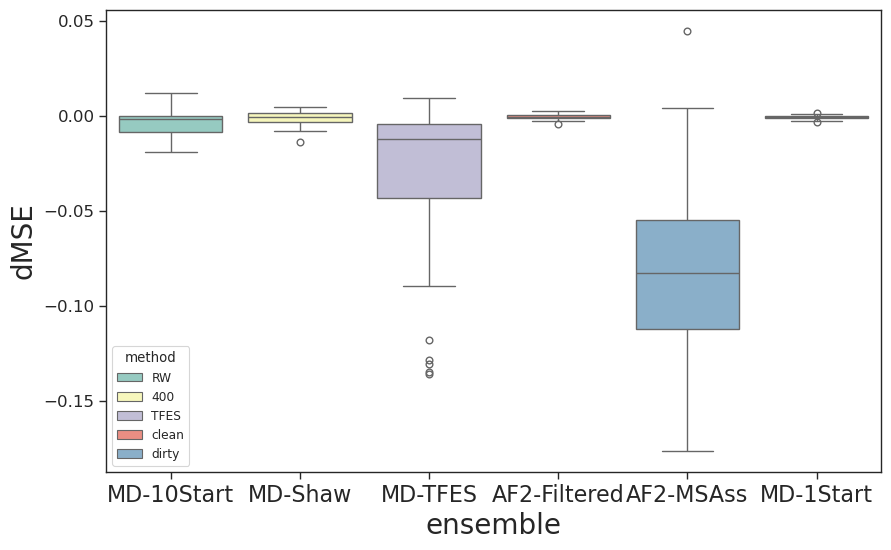

In [22]:
methord_order = ["RW"]
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

fit_val_df = mean_dMSE_df[mean_dMSE_df["fit"] == "bench"]


sns.boxplot(data=mean_dMSE_df, x="ensemble", y="dMSE", hue="method", ax=ax, palette="Set3")#,order=method_order)
 
# ax.set_yscale("log")

plt.show()


In [23]:

data_frames = []

for csv in csvs:
    data_frames.append(pd.read_csv(csv))

df = pd.concat(data_frames)
df.head()



,time,Type,R,calc_name,mse,name,system,analysis,split_type,protein,name_name,dataset,class
0,0.167,Train,0.656338,train_BPTI_10Start_1,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,bench,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3
1,0.167,Val,0.261163,val_BPTI_10Start_1,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,bench,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3
2,0.167,Train,0.681620,train_BPTI_10Start_2,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,bench,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3
3,0.167,Val,0.370043,val_BPTI_10Start_2,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,bench,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3
4,0.167,Train,0.673177,train_BPTI_10Start_3,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,bench,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3


In [24]:
#
df["method"] = df["name"].apply(lambda x: x.split("_")[2])

In [25]:
df["fit"] = df["name"].apply(lambda x: x.split("_")[4])

In [26]:
print(df["fit"].unique())    

['R3' 'r' 'Sp' 's' 'bench']


In [27]:
protein_names = ["BPTI", "HOIP", "BRD4", "LXRa", "MBP"]

df['protein'] = df['name'].apply(lambda x: x.split('_')[0])
df

,time,Type,R,calc_name,mse,name,system,analysis,split_type,protein,name_name,dataset,class,method,fit
0,0.167,Train,0.656338,train_BPTI_10Start_1,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3,RW,R3
1,0.167,Val,0.261163,val_BPTI_10Start_1,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,RW,R3
2,0.167,Train,0.681620,train_BPTI_10Start_2,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3,RW,R3
3,0.167,Val,0.370043,val_BPTI_10Start_2,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,RW,R3
4,0.167,Train,0.673177,train_BPTI_10Start_3,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3,RW,R3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,10.000,Train,NaN,train_BPTI_1Start_2,0.018450,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,train_s,RW,s
35,10.000,Train,NaN,train_BPTI_1Start_3,0.145847,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,train_s,RW,s
36,10.000,Val,NaN,val_BPTI_1Start_1,0.020129,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,RW,s
37,10.000,Val,NaN,val_BPTI_1Start_2,0.158534,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,RW,s


In [28]:
# only include df that has non nan mse values
mse_df = df.dropna(subset=["mse"])
val_df = mse_df[mse_df["Type"] == "Val"]

# remove val mse = 0
val_df = val_df[val_df["mse"] != 0]


print(val_df.method.value_counts())

method
RW       72
400      36
TFES     36
clean    36
dirty    36
Name: count, dtype: int64


In [29]:
val_df



,time,Type,R,calc_name,mse,name,system,analysis,split_type,protein,name_name,dataset,class,method,fit
22,0.167,Val,NaN,val_BPTI_10Start_1,0.122628,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,RW,R3
23,0.167,Val,NaN,val_BPTI_10Start_2,0.140999,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,RW,R3
24,0.167,Val,NaN,val_BPTI_10Start_3,0.113142,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,RW,R3
29,1.000,Val,NaN,val_BPTI_10Start_1,0.143339,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,RW,R3
30,1.000,Val,NaN,val_BPTI_10Start_2,0.108500,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,RW,R3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,1.000,Val,NaN,val_BPTI_1Start_2,0.102913,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,RW,s
31,1.000,Val,NaN,val_BPTI_1Start_3,0.056555,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,RW,s
36,10.000,Val,NaN,val_BPTI_1Start_1,0.020129,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,RW,s
37,10.000,Val,NaN,val_BPTI_1Start_2,0.158534,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,RW,s


In [30]:
val_df.columns

Index(['time', 'Type', 'R', 'calc_name', 'mse', 'name', 'system', 'analysis',
       'split_type', 'protein', 'name_name', 'dataset', 'class', 'method',
       'fit'],
      dtype='object')

In [31]:
val_df = transform_naming(val_df)
print(val_df["method"].unique())

['RW' '400' 'TFES' 'clean' 'dirty']


In [32]:
split_order = ["r", "s", "R3", "Sp"]


['MD-10Start' 'MD-Shaw' 'MD-TFES' 'AF2-Filtered' 'AF2-MSAss' 'MD-1Start']


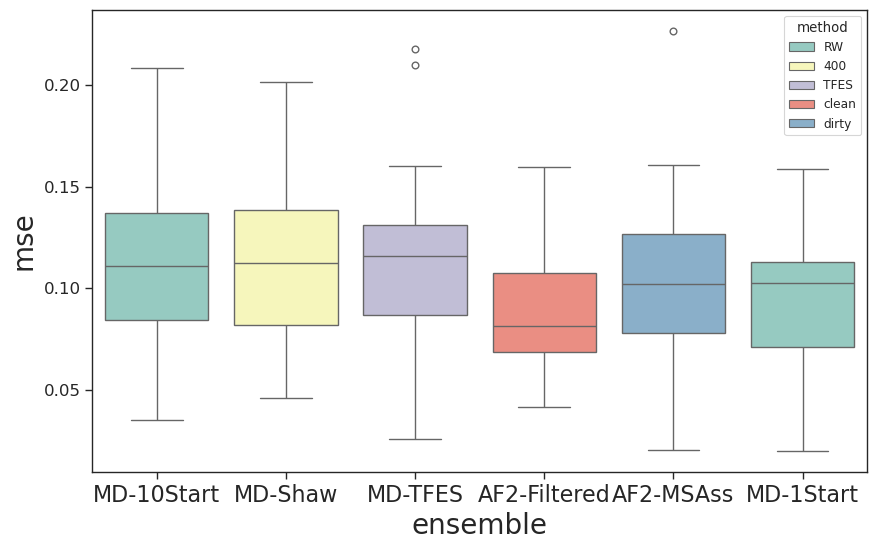

In [33]:
methord_order = ["RW"]
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

fit_val_df = val_df[val_df["replicate"] != 0]
print(fit_val_df["ensemble"].unique())

sns.boxplot(data=val_df, x="ensemble", y="mse", hue="method", ax=ax, palette="Set3")#,order=method_order)

# ax.set_yscale("log")

plt.show()


In [34]:
fit_val_df = val_df
fit_val_df["ensemble"].unique()

fit_val_df = transform_naming(fit_val_df)

In [35]:
print(val_df.method.value_counts())

method
RW       72
400      36
TFES     36
clean    36
dirty    36
Name: count, dtype: int64


In [36]:
expt_segs = pkl_list["expt_segs"]
weightslog_PFs = pkl_list["LogPfs"]
print(expt_segs.columns)
# print(log_PFs.columns)

Index(['ResStr', 'ResEnd', 'peptide', 'calc_name', 'Residue', 'name', 'system',
       'analysis', 'split_type', 'protein', 'name_name', 'dataset', 'class'],
      dtype='object')


In [37]:
expt_segs

,ResStr,ResEnd,peptide,calc_name,Residue,name,system,analysis,split_type,protein,name_name,dataset,class
0,4,5,0,Experimental,"(4, 5)",BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3
1,5,6,1,Experimental,"(5, 6)",BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3
2,6,7,2,Experimental,"(6, 7)",BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3
3,9,10,3,Experimental,"(9, 10)",BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3
4,11,12,4,Experimental,"(11, 12)",BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,51,52,31,Experimental,"(51, 52)",BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_Experi...,Experimental,Experimental_s
860,52,53,32,Experimental,"(52, 53)",BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_Experi...,Experimental,Experimental_s
861,53,54,33,Experimental,"(53, 54)",BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_Experi...,Experimental,Experimental_s
862,54,55,34,Experimental,"(54, 55)",BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_Experi...,Experimental,Experimental_s


In [38]:
log_PFs = pkl_list["LogPfs"]
log_PFs = transform_naming(log_PFs)
print(log_PFs.ensemble.unique())
print(len(log_PFs.ensemble.unique()))
print(log_PFs.ensemble.value_counts())

['MD-10Start' 'MD-Shaw' 'MD-TFES' 'AF2-Filtered' 'AF2-MSAss' 'MD-1Start']
6
ensemble
MD-10Start      1079
MD-Shaw         1079
MD-TFES         1079
AF2-Filtered    1079
AF2-MSAss       1079
MD-1Start       1079
Name: count, dtype: int64


In [39]:
log_PFs

,Residues,LogPf,calc_name,name,system,analysis,split_type,protein,name_name,dataset,class,method,fit,ensemble,split_name,replicate
0,5,8.363000,prior_BPTI_10Start_1,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_prior_BPTI...,prior,prior_R3,RW,bench,MD-10Start,Non-Redundant,1
1,6,7.371500,prior_BPTI_10Start_1,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_prior_BPTI...,prior,prior_R3,RW,bench,MD-10Start,Non-Redundant,1
2,7,4.943000,prior_BPTI_10Start_1,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_prior_BPTI...,prior,prior_R3,RW,bench,MD-10Start,Non-Redundant,1
3,10,3.585000,prior_BPTI_10Start_1,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_prior_BPTI...,prior,prior_R3,RW,bench,MD-10Start,Non-Redundant,1
4,12,4.629000,prior_BPTI_10Start_1,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_prior_BPTI...,prior,prior_R3,RW,bench,MD-10Start,Non-Redundant,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6469,52,12.094713,test_BPTI_1Start_3,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_test_B...,test,test_s,RW,bench,MD-1Start,Sequence,3
6470,53,8.401760,test_BPTI_1Start_3,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_test_B...,test,test_s,RW,bench,MD-1Start,Sequence,3
6471,54,7.588907,test_BPTI_1Start_3,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_test_B...,test,test_s,RW,bench,MD-1Start,Sequence,3
6472,55,13.074914,test_BPTI_1Start_3,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_test_B...,test,test_s,RW,bench,MD-1Start,Sequence,3


In [40]:

weights

,weights,calc_name,likelihood,name,system,analysis,split_type,protein,name_name,dataset,class,method,fit,ensemble,split_name,replicate
0,"[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0...",prior_BPTI_10Start,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_prior_BPTI...,prior,prior_R3,RW,bench,MD-10Start,Non-Redundant,10Start
1,"[0.02372835877872393, 0.006114595773371032, 0....",train_BPTI_10Start_1,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3,RW,bench,MD-10Start,Non-Redundant,1
2,NaN,train_BPTI_10Start_1,0.793763,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3,RW,bench,MD-10Start,Non-Redundant,1
3,"[0.007834767316414666, 0.006925636727012411, 0...",train_BPTI_10Start_2,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3,RW,bench,MD-10Start,Non-Redundant,2
4,NaN,train_BPTI_10Start_2,0.970512,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3,RW,bench,MD-10Start,Non-Redundant,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,NaN,train_BPTI_1Start_1,1.172043,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,train_s,RW,bench,MD-1Start,Sequence,1
164,"[0.006278355792773425, 0.015094219480372258, 0...",train_BPTI_1Start_2,NaN,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,train_s,RW,bench,MD-1Start,Sequence,2
165,NaN,train_BPTI_1Start_2,0.985110,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,train_s,RW,bench,MD-1Start,Sequence,2
166,"[0.004174238331941743, 0.017184303825371065, 0...",train_BPTI_1Start_3,NaN,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,train_s,RW,bench,MD-1Start,Sequence,3


In [41]:
# explode "weights" array in weights dataframe - such that each element in the array is a new row - labelled by array index in the "frame" column



In [42]:
import pandas as pd
import numpy as np

# Assuming you have a DataFrame called 'weights' with a column 'weights' containing arrays
# If not, you can create a sample DataFrame like this:
# weights = pd.DataFrame({'weights': [[1, 2, 3], [4, 5], [6, 7, 8, 9]]})

# Explode the 'weights' column
exploded = weights.explode('weights')

# Reset the index and rename it to 'frame'
exploded = exploded.reset_index().rename(columns={'index': 'frame'})

# If you want 'frame' to represent the index within each array instead of the original DataFrame index,
# you can modify it like this:
exploded['frame'] = exploded.groupby('frame').cumcount()

# Reset the index again to have a clean numeric index
exploded = exploded.reset_index(drop=True)

# Display the result
print(exploded)

      frame   weights            calc_name  likelihood  \
0         0      0.01   prior_BPTI_10Start         NaN   
1         1      0.01   prior_BPTI_10Start         NaN   
2         2      0.01   prior_BPTI_10Start         NaN   
3         3      0.01   prior_BPTI_10Start         NaN   
4         4      0.01   prior_BPTI_10Start         NaN   
...     ...       ...                  ...         ...   
9667     96  0.006427  train_BPTI_1Start_3         NaN   
9668     97  0.003528  train_BPTI_1Start_3         NaN   
9669     98  0.004622  train_BPTI_1Start_3         NaN   
9670     99  0.004334  train_BPTI_1Start_3         NaN   
9671      0       NaN  train_BPTI_1Start_3    1.163253   

                                         name  \
0         BPTI_10Start_RW_bench_R3_k_sequence   
1         BPTI_10Start_RW_bench_R3_k_sequence   
2         BPTI_10Start_RW_bench_R3_k_sequence   
3         BPTI_10Start_RW_bench_R3_k_sequence   
4         BPTI_10Start_RW_bench_R3_k_sequence   
...      

In [43]:
exploded.frame.value_counts()

frame
0     168
63     96
73     96
72     96
71     96
     ... 
30     96
29     96
28     96
27     96
99     96
Name: count, Length: 100, dtype: int64

In [44]:
log_PFs



,Residues,LogPf,calc_name,name,system,analysis,split_type,protein,name_name,dataset,class,method,fit,ensemble,split_name,replicate
0,5,8.363000,prior_BPTI_10Start_1,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_prior_BPTI...,prior,prior_R3,RW,bench,MD-10Start,Non-Redundant,1
1,6,7.371500,prior_BPTI_10Start_1,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_prior_BPTI...,prior,prior_R3,RW,bench,MD-10Start,Non-Redundant,1
2,7,4.943000,prior_BPTI_10Start_1,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_prior_BPTI...,prior,prior_R3,RW,bench,MD-10Start,Non-Redundant,1
3,10,3.585000,prior_BPTI_10Start_1,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_prior_BPTI...,prior,prior_R3,RW,bench,MD-10Start,Non-Redundant,1
4,12,4.629000,prior_BPTI_10Start_1,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_prior_BPTI...,prior,prior_R3,RW,bench,MD-10Start,Non-Redundant,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6469,52,12.094713,test_BPTI_1Start_3,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_test_B...,test,test_s,RW,bench,MD-1Start,Sequence,3
6470,53,8.401760,test_BPTI_1Start_3,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_test_B...,test,test_s,RW,bench,MD-1Start,Sequence,3
6471,54,7.588907,test_BPTI_1Start_3,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_test_B...,test,test_s,RW,bench,MD-1Start,Sequence,3
6472,55,13.074914,test_BPTI_1Start_3,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_test_B...,test,test_s,RW,bench,MD-1Start,Sequence,3


In [45]:
weights

,weights,calc_name,likelihood,name,system,analysis,split_type,protein,name_name,dataset,class,method,fit,ensemble,split_name,replicate
0,"[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0...",prior_BPTI_10Start,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_prior_BPTI...,prior,prior_R3,RW,bench,MD-10Start,Non-Redundant,10Start
1,"[0.02372835877872393, 0.006114595773371032, 0....",train_BPTI_10Start_1,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3,RW,bench,MD-10Start,Non-Redundant,1
2,NaN,train_BPTI_10Start_1,0.793763,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3,RW,bench,MD-10Start,Non-Redundant,1
3,"[0.007834767316414666, 0.006925636727012411, 0...",train_BPTI_10Start_2,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3,RW,bench,MD-10Start,Non-Redundant,2
4,NaN,train_BPTI_10Start_2,0.970512,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3,RW,bench,MD-10Start,Non-Redundant,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,NaN,train_BPTI_1Start_1,1.172043,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,train_s,RW,bench,MD-1Start,Sequence,1
164,"[0.006278355792773425, 0.015094219480372258, 0...",train_BPTI_1Start_2,NaN,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,train_s,RW,bench,MD-1Start,Sequence,2
165,NaN,train_BPTI_1Start_2,0.985110,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,train_s,RW,bench,MD-1Start,Sequence,2
166,"[0.004174238331941743, 0.017184303825371065, 0...",train_BPTI_1Start_3,NaN,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,train_s,RW,bench,MD-1Start,Sequence,3


In [46]:
(features)

,sum_contacts,sum_hbonds,calc_name,name,system,analysis,split_type,protein,name_name,dataset,class
0,"[832.0, 774.0, 824.0, 765.0, 841.0, 814.0, 722...","[25.0, 25.0, 25.0, 28.0, 24.0, 25.0, 24.0, 24....",Experimental,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3
1,"[832.0, 774.0, 824.0, 765.0, 841.0, 814.0, 722...","[25.0, 25.0, 25.0, 28.0, 24.0, 25.0, 24.0, 24....",Experimental,BPTI_10Start_RW_bench_r_naive_random,BPTI_10Start_RW_bench_r_naive_random,RW_bench,r,BPTI,BPTI_10Start_RW_bench_r_naive_random_Experimental,Experimental,Experimental_r
2,"[832.0, 774.0, 824.0, 765.0, 841.0, 814.0, 722...","[25.0, 25.0, 25.0, 28.0, 24.0, 25.0, 24.0, 24....",Experimental,BPTI_10Start_RW_bench_Sp_res_neighbours,BPTI_10Start_RW_bench_Sp_res_neighbours,RW_bench,Sp,BPTI,BPTI_10Start_RW_bench_Sp_res_neighbours_Experi...,Experimental,Experimental_Sp
3,"[832.0, 774.0, 824.0, 765.0, 841.0, 814.0, 722...","[25.0, 25.0, 25.0, 28.0, 24.0, 25.0, 24.0, 24....",Experimental,BPTI_10Start_RW_bench_s_naive_sequential,BPTI_10Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_10Start_RW_bench_s_naive_sequential_Exper...,Experimental,Experimental_s
4,"[876.0, 873.0, 869.0, 836.0, 807.0, 839.0, 850...","[24.0, 21.0, 25.0, 21.0, 21.0, 22.0, 21.0, 20....",Experimental,BPTI_shaw_400_RW_bench_R3_k_sequence,BPTI_shaw_400_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_shaw_400_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3
5,"[876.0, 873.0, 869.0, 836.0, 807.0, 839.0, 850...","[24.0, 21.0, 25.0, 21.0, 21.0, 22.0, 21.0, 20....",Experimental,BPTI_shaw_400_RW_bench_Sp_res_neighbours,BPTI_shaw_400_RW_bench_Sp_res_neighbours,RW_bench,Sp,BPTI,BPTI_shaw_400_RW_bench_Sp_res_neighbours_Exper...,Experimental,Experimental_Sp
6,"[876.0, 873.0, 869.0, 836.0, 807.0, 839.0, 850...","[24.0, 21.0, 25.0, 21.0, 21.0, 22.0, 21.0, 20....",Experimental,BPTI_shaw_400_RW_bench_r_naive_random,BPTI_shaw_400_RW_bench_r_naive_random,RW_bench,r,BPTI,BPTI_shaw_400_RW_bench_r_naive_random_Experime...,Experimental,Experimental_r
7,"[876.0, 873.0, 869.0, 836.0, 807.0, 839.0, 850...","[24.0, 21.0, 25.0, 21.0, 21.0, 22.0, 21.0, 20....",Experimental,BPTI_shaw_400_RW_bench_s_naive_sequential,BPTI_shaw_400_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_shaw_400_RW_bench_s_naive_sequential_Expe...,Experimental,Experimental_s
8,"[858.0, 713.0, 755.0, 710.0, 754.0, 691.0, 774...","[23.0, 23.0, 23.0, 25.0, 21.0, 22.0, 24.0, 26....",Experimental,BPTI_MD_TFES_RW_bench_s_naive_sequential,BPTI_MD_TFES_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_MD_TFES_RW_bench_s_naive_sequential_Exper...,Experimental,Experimental_s
9,"[858.0, 713.0, 755.0, 710.0, 754.0, 691.0, 774...","[23.0, 23.0, 23.0, 25.0, 21.0, 22.0, 24.0, 26....",Experimental,BPTI_MD_TFES_RW_bench_r_naive_random,BPTI_MD_TFES_RW_bench_r_naive_random,RW_bench,r,BPTI,BPTI_MD_TFES_RW_bench_r_naive_random_Experimental,Experimental,Experimental_r


In [47]:
BV_constants = pkl_list["BV_constants"]

BV_constants

,Bc,Bh,calc_name,name,system,analysis,split_type,protein,name_name,dataset,class
0,0.35,2.0,prior_BPTI_10Start,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_prior_BPTI...,prior,prior_R3
1,0.35,2.0,train_BPTI_10Start_1,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3
2,0.35,2.0,train_BPTI_10Start_2,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3
3,0.35,2.0,train_BPTI_10Start_3,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3
4,0.35,2.0,prior_BPTI_10Start,BPTI_10Start_RW_bench_r_naive_random,BPTI_10Start_RW_bench_r_naive_random,RW_bench,r,BPTI,BPTI_10Start_RW_bench_r_naive_random_prior_BPT...,prior,prior_r
...,...,...,...,...,...,...,...,...,...,...,...
91,0.35,2.0,train_BPTI_1Start_3,BPTI_1Start_RW_bench_r_naive_random,BPTI_1Start_RW_bench_r_naive_random,RW_bench,r,BPTI,BPTI_1Start_RW_bench_r_naive_random_train_BPTI...,train,train_r
92,0.35,2.0,prior_BPTI_1Start,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_prior_...,prior,prior_s
93,0.35,2.0,train_BPTI_1Start_1,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,train_s
94,0.35,2.0,train_BPTI_1Start_2,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,train_s


In [48]:
weights

,weights,calc_name,likelihood,name,system,analysis,split_type,protein,name_name,dataset,class,method,fit,ensemble,split_name,replicate
0,"[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0...",prior_BPTI_10Start,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_prior_BPTI...,prior,prior_R3,RW,bench,MD-10Start,Non-Redundant,10Start
1,"[0.02372835877872393, 0.006114595773371032, 0....",train_BPTI_10Start_1,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3,RW,bench,MD-10Start,Non-Redundant,1
2,NaN,train_BPTI_10Start_1,0.793763,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3,RW,bench,MD-10Start,Non-Redundant,1
3,"[0.007834767316414666, 0.006925636727012411, 0...",train_BPTI_10Start_2,NaN,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3,RW,bench,MD-10Start,Non-Redundant,2
4,NaN,train_BPTI_10Start_2,0.970512,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,train_R3,RW,bench,MD-10Start,Non-Redundant,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,NaN,train_BPTI_1Start_1,1.172043,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,train_s,RW,bench,MD-1Start,Sequence,1
164,"[0.006278355792773425, 0.015094219480372258, 0...",train_BPTI_1Start_2,NaN,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,train_s,RW,bench,MD-1Start,Sequence,2
165,NaN,train_BPTI_1Start_2,0.985110,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,train_s,RW,bench,MD-1Start,Sequence,2
166,"[0.004174238331941743, 0.017184303825371065, 0...",train_BPTI_1Start_3,NaN,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,train_s,RW,bench,MD-1Start,Sequence,3


In [49]:
features

,sum_contacts,sum_hbonds,calc_name,name,system,analysis,split_type,protein,name_name,dataset,class
0,"[832.0, 774.0, 824.0, 765.0, 841.0, 814.0, 722...","[25.0, 25.0, 25.0, 28.0, 24.0, 25.0, 24.0, 24....",Experimental,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3
1,"[832.0, 774.0, 824.0, 765.0, 841.0, 814.0, 722...","[25.0, 25.0, 25.0, 28.0, 24.0, 25.0, 24.0, 24....",Experimental,BPTI_10Start_RW_bench_r_naive_random,BPTI_10Start_RW_bench_r_naive_random,RW_bench,r,BPTI,BPTI_10Start_RW_bench_r_naive_random_Experimental,Experimental,Experimental_r
2,"[832.0, 774.0, 824.0, 765.0, 841.0, 814.0, 722...","[25.0, 25.0, 25.0, 28.0, 24.0, 25.0, 24.0, 24....",Experimental,BPTI_10Start_RW_bench_Sp_res_neighbours,BPTI_10Start_RW_bench_Sp_res_neighbours,RW_bench,Sp,BPTI,BPTI_10Start_RW_bench_Sp_res_neighbours_Experi...,Experimental,Experimental_Sp
3,"[832.0, 774.0, 824.0, 765.0, 841.0, 814.0, 722...","[25.0, 25.0, 25.0, 28.0, 24.0, 25.0, 24.0, 24....",Experimental,BPTI_10Start_RW_bench_s_naive_sequential,BPTI_10Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_10Start_RW_bench_s_naive_sequential_Exper...,Experimental,Experimental_s
4,"[876.0, 873.0, 869.0, 836.0, 807.0, 839.0, 850...","[24.0, 21.0, 25.0, 21.0, 21.0, 22.0, 21.0, 20....",Experimental,BPTI_shaw_400_RW_bench_R3_k_sequence,BPTI_shaw_400_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_shaw_400_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3
5,"[876.0, 873.0, 869.0, 836.0, 807.0, 839.0, 850...","[24.0, 21.0, 25.0, 21.0, 21.0, 22.0, 21.0, 20....",Experimental,BPTI_shaw_400_RW_bench_Sp_res_neighbours,BPTI_shaw_400_RW_bench_Sp_res_neighbours,RW_bench,Sp,BPTI,BPTI_shaw_400_RW_bench_Sp_res_neighbours_Exper...,Experimental,Experimental_Sp
6,"[876.0, 873.0, 869.0, 836.0, 807.0, 839.0, 850...","[24.0, 21.0, 25.0, 21.0, 21.0, 22.0, 21.0, 20....",Experimental,BPTI_shaw_400_RW_bench_r_naive_random,BPTI_shaw_400_RW_bench_r_naive_random,RW_bench,r,BPTI,BPTI_shaw_400_RW_bench_r_naive_random_Experime...,Experimental,Experimental_r
7,"[876.0, 873.0, 869.0, 836.0, 807.0, 839.0, 850...","[24.0, 21.0, 25.0, 21.0, 21.0, 22.0, 21.0, 20....",Experimental,BPTI_shaw_400_RW_bench_s_naive_sequential,BPTI_shaw_400_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_shaw_400_RW_bench_s_naive_sequential_Expe...,Experimental,Experimental_s
8,"[858.0, 713.0, 755.0, 710.0, 754.0, 691.0, 774...","[23.0, 23.0, 23.0, 25.0, 21.0, 22.0, 24.0, 26....",Experimental,BPTI_MD_TFES_RW_bench_s_naive_sequential,BPTI_MD_TFES_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_MD_TFES_RW_bench_s_naive_sequential_Exper...,Experimental,Experimental_s
9,"[858.0, 713.0, 755.0, 710.0, 754.0, 691.0, 774...","[23.0, 23.0, 23.0, 25.0, 21.0, 22.0, 24.0, 26....",Experimental,BPTI_MD_TFES_RW_bench_r_naive_random,BPTI_MD_TFES_RW_bench_r_naive_random,RW_bench,r,BPTI,BPTI_MD_TFES_RW_bench_r_naive_random_Experimental,Experimental,Experimental_r


In [50]:
weights.system.unique()


array(['BPTI_10Start_RW_bench_R3_k_sequence',
       'BPTI_10Start_RW_bench_r_naive_random',
       'BPTI_10Start_RW_bench_Sp_res_neighbours',
       'BPTI_10Start_RW_bench_s_naive_sequential',
       'BPTI_shaw_400_RW_bench_R3_k_sequence',
       'BPTI_shaw_400_RW_bench_Sp_res_neighbours',
       'BPTI_shaw_400_RW_bench_r_naive_random',
       'BPTI_shaw_400_RW_bench_s_naive_sequential',
       'BPTI_MD_TFES_RW_bench_s_naive_sequential',
       'BPTI_MD_TFES_RW_bench_r_naive_random',
       'BPTI_MD_TFES_RW_bench_R3_k_sequence',
       'BPTI_MD_TFES_RW_bench_Sp_res_neighbours',
       'BPTI_af_clean_RW_bench_s_naive_sequential',
       'BPTI_af_clean_RW_bench_R3_k_sequence',
       'BPTI_af_clean_RW_bench_r_naive_random',
       'BPTI_af_clean_RW_bench_Sp_res_neighbours',
       'BPTI_af_dirty_RW_bench_R3_k_sequence',
       'BPTI_af_dirty_RW_bench_Sp_res_neighbours',
       'BPTI_af_dirty_RW_bench_r_naive_random',
       'BPTI_af_dirty_RW_bench_s_naive_sequential',
       'BPTI_1Star

In [51]:
features

,sum_contacts,sum_hbonds,calc_name,name,system,analysis,split_type,protein,name_name,dataset,class
0,"[832.0, 774.0, 824.0, 765.0, 841.0, 814.0, 722...","[25.0, 25.0, 25.0, 28.0, 24.0, 25.0, 24.0, 24....",Experimental,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3
1,"[832.0, 774.0, 824.0, 765.0, 841.0, 814.0, 722...","[25.0, 25.0, 25.0, 28.0, 24.0, 25.0, 24.0, 24....",Experimental,BPTI_10Start_RW_bench_r_naive_random,BPTI_10Start_RW_bench_r_naive_random,RW_bench,r,BPTI,BPTI_10Start_RW_bench_r_naive_random_Experimental,Experimental,Experimental_r
2,"[832.0, 774.0, 824.0, 765.0, 841.0, 814.0, 722...","[25.0, 25.0, 25.0, 28.0, 24.0, 25.0, 24.0, 24....",Experimental,BPTI_10Start_RW_bench_Sp_res_neighbours,BPTI_10Start_RW_bench_Sp_res_neighbours,RW_bench,Sp,BPTI,BPTI_10Start_RW_bench_Sp_res_neighbours_Experi...,Experimental,Experimental_Sp
3,"[832.0, 774.0, 824.0, 765.0, 841.0, 814.0, 722...","[25.0, 25.0, 25.0, 28.0, 24.0, 25.0, 24.0, 24....",Experimental,BPTI_10Start_RW_bench_s_naive_sequential,BPTI_10Start_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_10Start_RW_bench_s_naive_sequential_Exper...,Experimental,Experimental_s
4,"[876.0, 873.0, 869.0, 836.0, 807.0, 839.0, 850...","[24.0, 21.0, 25.0, 21.0, 21.0, 22.0, 21.0, 20....",Experimental,BPTI_shaw_400_RW_bench_R3_k_sequence,BPTI_shaw_400_RW_bench_R3_k_sequence,RW_bench,R3,BPTI,BPTI_shaw_400_RW_bench_R3_k_sequence_Experimental,Experimental,Experimental_R3
5,"[876.0, 873.0, 869.0, 836.0, 807.0, 839.0, 850...","[24.0, 21.0, 25.0, 21.0, 21.0, 22.0, 21.0, 20....",Experimental,BPTI_shaw_400_RW_bench_Sp_res_neighbours,BPTI_shaw_400_RW_bench_Sp_res_neighbours,RW_bench,Sp,BPTI,BPTI_shaw_400_RW_bench_Sp_res_neighbours_Exper...,Experimental,Experimental_Sp
6,"[876.0, 873.0, 869.0, 836.0, 807.0, 839.0, 850...","[24.0, 21.0, 25.0, 21.0, 21.0, 22.0, 21.0, 20....",Experimental,BPTI_shaw_400_RW_bench_r_naive_random,BPTI_shaw_400_RW_bench_r_naive_random,RW_bench,r,BPTI,BPTI_shaw_400_RW_bench_r_naive_random_Experime...,Experimental,Experimental_r
7,"[876.0, 873.0, 869.0, 836.0, 807.0, 839.0, 850...","[24.0, 21.0, 25.0, 21.0, 21.0, 22.0, 21.0, 20....",Experimental,BPTI_shaw_400_RW_bench_s_naive_sequential,BPTI_shaw_400_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_shaw_400_RW_bench_s_naive_sequential_Expe...,Experimental,Experimental_s
8,"[858.0, 713.0, 755.0, 710.0, 754.0, 691.0, 774...","[23.0, 23.0, 23.0, 25.0, 21.0, 22.0, 24.0, 26....",Experimental,BPTI_MD_TFES_RW_bench_s_naive_sequential,BPTI_MD_TFES_RW_bench_s_naive_sequential,RW_bench,s,BPTI,BPTI_MD_TFES_RW_bench_s_naive_sequential_Exper...,Experimental,Experimental_s
9,"[858.0, 713.0, 755.0, 710.0, 754.0, 691.0, 774...","[23.0, 23.0, 23.0, 25.0, 21.0, 22.0, 24.0, 26....",Experimental,BPTI_MD_TFES_RW_bench_r_naive_random,BPTI_MD_TFES_RW_bench_r_naive_random,RW_bench,r,BPTI,BPTI_MD_TFES_RW_bench_r_naive_random_Experimental,Experimental,Experimental_r


In [52]:
BV_constants.system.unique()

array(['BPTI_10Start_RW_bench_R3_k_sequence',
       'BPTI_10Start_RW_bench_r_naive_random',
       'BPTI_10Start_RW_bench_Sp_res_neighbours',
       'BPTI_10Start_RW_bench_s_naive_sequential',
       'BPTI_shaw_400_RW_bench_R3_k_sequence',
       'BPTI_shaw_400_RW_bench_Sp_res_neighbours',
       'BPTI_shaw_400_RW_bench_r_naive_random',
       'BPTI_shaw_400_RW_bench_s_naive_sequential',
       'BPTI_MD_TFES_RW_bench_s_naive_sequential',
       'BPTI_MD_TFES_RW_bench_r_naive_random',
       'BPTI_MD_TFES_RW_bench_R3_k_sequence',
       'BPTI_MD_TFES_RW_bench_Sp_res_neighbours',
       'BPTI_af_clean_RW_bench_s_naive_sequential',
       'BPTI_af_clean_RW_bench_R3_k_sequence',
       'BPTI_af_clean_RW_bench_r_naive_random',
       'BPTI_af_clean_RW_bench_Sp_res_neighbours',
       'BPTI_af_dirty_RW_bench_R3_k_sequence',
       'BPTI_af_dirty_RW_bench_Sp_res_neighbours',
       'BPTI_af_dirty_RW_bench_r_naive_random',
       'BPTI_af_dirty_RW_bench_s_naive_sequential',
       'BPTI_1Star

In [53]:
expt_segs = pkl_list["expt_segs"]
expt_segs

proteins_num_res = {}

for protein_name in protein_names:
    protein_expt_segs = expt_segs[expt_segs["protein"] == protein_name]

    residue_lists = protein_expt_segs["Residue"].unique()
    # expand list of list
    residues = [residue for residue_list in residue_lists for residue in residue_list]
    residues = list(set(residues))
    proteins_num_res[protein_name] = len(residues)

def calc_energy(features: pd.DataFrame, BV_constants: pd.DataFrame, weights: pd.DataFrame, R=8.31, T=300) -> pd.DataFrame:
    """
    Calculate the energy of the system from the dataframes provided.
    Features contains the sum of the contacts/hbonds for each system,
    these are multiplied by the BV Bc and Bh constants respectively.
    Weights are simply added to the dataframe aligned by calc_name.
    sum_contacts, sum_hbonds, Bc, Bh, weights are arrays of the same length.
    Features are aligned based on "system" as there are multiple replicates designated by calc_name in BV_constants and weights.
    Returns a dataframe with the energy for each system and calc_name.
    """
    # merge BV_constants and weights on calc_name
    # select weights and calc_name columns 
    weights = weights[["calc_name", "weights"]]

    merged = pd.concat([BV_constants, weights], axis=1, join="inner")
    print(merged.columns)
    print(merged.system.value_counts())

    systems = features.system.unique()
    # iterate through the systems
    features = features[['system', 'sum_contacts', 'sum_hbonds']]

    data_frames = []

    for system in systems:
        print(system)
        system_features = features[features["system"] == system]

        # get the sum_contacts and sum_hbonds
        sum_contacts = system_features["sum_contacts"].to_list()
        sum_hbonds = system_features["sum_hbonds"].to_list()

        system_merged = merged[merged["system"] == system]

        # add the sum_contacts and sum_hbonds to the system_merged
        system_merged["sum_contacts"] = sum_contacts*len(system_merged)
        system_merged["sum_hbonds"] = sum_hbonds*len(system_merged)

        protein = system_merged["protein"].values[0]

        num_res = proteins_num_res[protein]


        # calculate the energy
        system_merged["energy"] = (system_merged["Bc"]*system_merged["sum_contacts"] + system_merged["Bh"]*system_merged["sum_hbonds"])*R*T/num_res

        # multiply each element in the weights array by the energy and sum

        system_merged["weighted_energy"] = system_merged["weights"]*system_merged["energy"]

        system_merged["mean_energy"] = system_merged["weighted_energy"].apply(lambda x: np.sum(x))

        data_frames.append(system_merged)


    merged = pd.concat(data_frames)
 
    # remove duplicate columns
    merged = merged.loc[:,~merged.columns.duplicated()]

    return merged




energy_df = calc_energy(features, BV_constants, weights)

energy_df = transform_naming(energy_df)
energy_df["replicate"] = energy_df["calc_name"].apply(lambda x: x.split("_")[-1])

Index(['Bc', 'Bh', 'calc_name', 'name', 'system', 'analysis', 'split_type',
       'protein', 'name_name', 'dataset', 'class', 'calc_name', 'weights'],
      dtype='object')
system
BPTI_10Start_RW_bench_R3_k_sequence          4
BPTI_10Start_RW_bench_r_naive_random         4
BPTI_1Start_RW_bench_r_naive_random          4
BPTI_1Start_RW_bench_Sp_res_neighbours       4
BPTI_1Start_RW_bench_R3_k_sequence           4
BPTI_af_dirty_RW_bench_s_naive_sequential    4
BPTI_af_dirty_RW_bench_r_naive_random        4
BPTI_af_dirty_RW_bench_Sp_res_neighbours     4
BPTI_af_dirty_RW_bench_R3_k_sequence         4
BPTI_af_clean_RW_bench_Sp_res_neighbours     4
BPTI_af_clean_RW_bench_r_naive_random        4
BPTI_af_clean_RW_bench_R3_k_sequence         4
BPTI_af_clean_RW_bench_s_naive_sequential    4
BPTI_MD_TFES_RW_bench_Sp_res_neighbours      4
BPTI_MD_TFES_RW_bench_R3_k_sequence          4
BPTI_MD_TFES_RW_bench_r_naive_random         4
BPTI_MD_TFES_RW_bench_s_naive_sequential     4
BPTI_shaw_400_RW_ben

/tmp/ipykernel_2066443/2651857176.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  system_merged["sum_contacts"] = sum_contacts*len(system_merged)
/tmp/ipykernel_2066443/2651857176.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  system_merged["sum_hbonds"] = sum_hbonds*len(system_merged)
/tmp/ipykernel_2066443/2651857176.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [54]:
# features[features["name"]=="BPTI_MD_Good+Bad_RW_bench_s_naive_sequential"].sum_contacts.values

In [55]:
energy_df.ensemble.unique()

array(['MD-10Start', 'MD-Shaw', 'MD-TFES', 'AF2-Filtered', 'AF2-MSAss',
       'MD-1Start'], dtype=object)

In [56]:
import numpy as np
from scipy.constants import Boltzmann

def calc_absolute_entropy(energy_df: pd.DataFrame, key="weights", R=8.31):
    """
    Calculates the absolute entropy for the energy dataframe provided.
    The key is the column in the energy_df that contains the weights.
    The entropy is calculated for each array in the weights column.
    
    Parameters:
    energy_df (pd.DataFrame): DataFrame containing the weights
    key (str): Column name for the weights
    T (float): Temperature in Kelvin
    
    Returns:
    pd.DataFrame: Original dataframe with added entropy columns
    """
    
    def entropy(p):
        # Avoid log(0) by adding a small constant
        return -np.sum(p * np.log(p + 1e-10))
    
    entropies = []
    for weights in energy_df[key]:
        # Convert weights to numpy array if it's not already
        weights = np.array(weights)
        
        # Normalize weights to sum to 1
        weights = weights / np.sum(weights)
        
        # Calculate entropy
        S = entropy(weights)
        entropies.append(S)
    
    # Add entropy as a new column to the dataframe
    energy_df['Entropy_nats'] = entropies
    
    # Convert entropy to J/K/mol
    energy_df['Entropy_JKmol'] = energy_df['Entropy_nats'] * R
    


    return energy_df

# Usage:
energy_df = calc_absolute_entropy(energy_df)

In [57]:
def calc_energy_difference(energy_df: pd.DataFrame, dataset="prior", key="mean_energy", T=300, R=8.31):
    """
    Calculates the energy change upon reweighting from the prior
    """

    systems = energy_df.system.unique()


    dfs= []
    for system in systems:
        # print(system)
        system_df = energy_df[energy_df["system"] == system]
        prior = system_df[system_df["dataset"] == dataset]
        prior_energy = prior[key].values
        # print(prior_energy)
        system_df["signed_energy_difference"] = system_df[key].values - prior_energy
        # take absolute value
        system_df["energy_difference"] = system_df["signed_energy_difference"].apply(lambda x: np.abs(x))
        # print(system_df["energy_difference"])
        system_df["%_energy_difference"] = system_df["energy_difference"].apply(lambda x: 100*x/np.abs(prior_energy))

        # convert %_energy_difference from a list
        system_df["%_energy_difference"] = system_df["%_energy_difference"].apply(lambda x: x[0])



        system_df["ratio_energy_difference"] = system_df["%_energy_difference"].apply(lambda x: x/100+1)


        system_df["entropy_difference"] = system_df["Entropy_JKmol"].values - prior["Entropy_JKmol"].values

        system_df["signed_enthalpy"] = system_df["signed_energy_difference"] 

        print(system_df.entropy_difference.values)

        system_df["gibbs_free_energy"] = system_df["energy_difference"] - T*system_df["entropy_difference"]

        # convert to equilibrium constant
        system_df["equilibrium_constant"] = system_df["gibbs_free_energy"].apply(lambda x: np.exp(-x/(R*T)))


   
        dfs.append(system_df)

    energy_df = pd.concat(dfs)

    return energy_df

energy_df = calc_energy_difference(energy_df)

energy_df.columns

[ 0.         -1.79795449         nan -1.35088632]
[nan nan nan nan]
[ 0.                 nan -2.82169941         nan]
[0.                nan 1.81650813 0.3985887 ]
[nan nan nan nan]
[nan nan nan nan]
[ 0.                 nan -1.02473792         nan]
[ 0.         -1.30039723         nan -0.95726825]
[nan nan nan nan]
[ 0.                 nan -1.26832474         nan]
[0.                nan 1.5602906  1.00493617]
[nan nan nan nan]
[nan nan nan nan]
[ 0.                 nan -1.02525758         nan]
[ 0.         -4.57153292         nan -3.9013587 ]
[nan nan nan nan]
[ 0.                 nan -2.35289768         nan]
[0.                nan 3.60995888 0.11153605]
[nan nan nan nan]
[nan nan nan nan]
[0.                nan 0.52186114        nan]
[ 0.         -0.19706282         nan -1.02299811]
[nan nan nan nan]
[0.                nan 1.51695162        nan]


/tmp/ipykernel_2066443/4026106190.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  system_df["signed_energy_difference"] = system_df[key].values - prior_energy
/tmp/ipykernel_2066443/4026106190.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  system_df["energy_difference"] = system_df["signed_energy_difference"].apply(lambda x: np.abs(x))
/tmp/ipykernel_2066443/4026106190.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

Index(['Bc', 'Bh', 'calc_name', 'name', 'system', 'analysis', 'split_type',
       'protein', 'name_name', 'dataset', 'class', 'weights', 'sum_contacts',
       'sum_hbonds', 'energy', 'weighted_energy', 'mean_energy', 'method',
       'fit', 'ensemble', 'split_name', 'replicate', 'Entropy_nats',
       'Entropy_JKmol', 'signed_energy_difference', 'energy_difference',
       '%_energy_difference', 'ratio_energy_difference', 'entropy_difference',
       'signed_enthalpy', 'gibbs_free_energy', 'equilibrium_constant'],
      dtype='object')

In [58]:
energy_df.ensemble.unique()

array(['MD-10Start', 'MD-Shaw', 'MD-TFES', 'AF2-Filtered', 'AF2-MSAss',
       'MD-1Start'], dtype=object)

In [59]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # Create a custom palette
# shaw_free_dataset_order = ["af_dirty", "af_clean", "af_conftop", "af_confbottom", "af_conf0.0", "af_conf0.1", "af_conf0.2", "af_conf0.3", "af_conf0.4", "af_conf0.5", "af_conf0.6", "af_conf0.7", "af_conf0.8", "af_conf0.9"]
# _dataset_order = ["af_dirty", "af_clean", "Shaw_400"]
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad"]#, "af_conftop", "af_confbottom", "af_conf0.0", "af_conf0.1", "af_conf0.2", "af_conf0.3", "af_conf0.4", "af_conf0.5", "af_conf0.6", "af_conf0.7", "af_conf0.8", "af_conf0.9"]
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]

# _free_energy_df = energy_df[energy_df["ensemble"].isin(_dataset_order)]
# _free_energy_df = _free_energy_df[_free_energy_df["dataset"]!="prior"]

# _free_energy_df = _free_energy_df[_free_energy_df["split_type"].isin(["R3","Sp"])]
# palette = sns.color_palette("Set1", n_colors=len(energy_df["replicate"].unique()))
# # Create the FacetGrid
# g = sns.FacetGrid(_free_energy_df, row="protein",height=5, aspect=1.5, sharey=False, sharex=False, row_order=protein_names)#, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.boxplot, x="ensemble", y="gibbs_free_energy", hue="split_type", palette="Set2", order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("Ensemble", fontsize=14)
# g.set_ylabels("gibbs_free_energy", fontsize=14)
# # Rotate x-tick labels
# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# g.set(yscale="log")
# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [60]:
energy_df

,Bc,Bh,calc_name,name,system,analysis,split_type,protein,name_name,dataset,...,Entropy_nats,Entropy_JKmol,signed_energy_difference,energy_difference,%_energy_difference,ratio_energy_difference,entropy_difference,signed_enthalpy,gibbs_free_energy,equilibrium_constant
0,0.35,2.0,prior_BPTI_10Start,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_prior_BPTI...,prior,...,4.605170,38.268964,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
1,0.35,2.0,train_BPTI_10Start_1,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,...,4.388810,36.471010,368.112922,368.112922,2.161165,1.021612,-1.797954,368.112922,907.499268,0.694878
2,0.35,2.0,train_BPTI_10Start_2,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.35,2.0,train_BPTI_10Start_3,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_train_BPTI...,train,...,4.442609,36.918078,-1.387044,1.387044,0.008143,1.000081,-1.350886,-1.387044,406.652941,0.849491
4,0.35,2.0,prior_BPTI_10Start,BPTI_10Start_RW_bench_r_naive_random,BPTI_10Start_RW_bench_r_naive_random,bench,r,BPTI,BPTI_10Start_RW_bench_r_naive_random_prior_BPT...,prior,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.35,2.0,train_BPTI_1Start_3,BPTI_1Start_RW_bench_r_naive_random,BPTI_1Start_RW_bench_r_naive_random,bench,r,BPTI,BPTI_1Start_RW_bench_r_naive_random_train_BPTI...,train,...,4.605170,38.268964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,0.35,2.0,prior_BPTI_1Start,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_prior_...,prior,...,4.409674,36.644393,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
93,0.35,2.0,train_BPTI_1Start_1,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,0.35,2.0,train_BPTI_1Start_2,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_train_...,train,...,4.592220,38.161345,31.251853,31.251853,0.169985,1.001700,1.516952,31.251853,-423.833634,1.185316


In [61]:
# merge MSE and energy dataframes
# fit_val_df 

mse_fit_val_df = fit_val_df[fit_val_df["mse"]!=0]

mean_fit_val_df = mse_fit_val_df.groupby(["name", "replicate", "protein", "split_type"])["mse"].mean().reset_index()


mean_fit_val_df

,name,replicate,protein,split_type,mse
0,BPTI_10Start_RW_bench_R3_k_sequence,1,BPTI,R3,0.131164
1,BPTI_10Start_RW_bench_R3_k_sequence,2,BPTI,R3,0.110752
2,BPTI_10Start_RW_bench_R3_k_sequence,3,BPTI,R3,0.113751
3,BPTI_10Start_RW_bench_Sp_res_neighbours,1,BPTI,Sp,0.119807
4,BPTI_10Start_RW_bench_Sp_res_neighbours,2,BPTI,Sp,0.078241
...,...,...,...,...,...
67,BPTI_shaw_400_RW_bench_r_naive_random,2,BPTI,r,0.072157
68,BPTI_shaw_400_RW_bench_r_naive_random,3,BPTI,r,0.138525
69,BPTI_shaw_400_RW_bench_s_naive_sequential,1,BPTI,s,0.069538
70,BPTI_shaw_400_RW_bench_s_naive_sequential,2,BPTI,s,0.125742


In [62]:
RW_energy_df = energy_df[energy_df["dataset"]!= "prior"]

RW_energy_df = transform_naming(RW_energy_df)

RW_energy_df.ensemble.unique()

array(['MD-10Start', 'MD-Shaw', 'MD-TFES', 'AF2-Filtered', 'AF2-MSAss',
       'MD-1Start'], dtype=object)

In [63]:
RW_mean_fit_val_df = mean_fit_val_df[["name", "replicate", "mse"]]

MSE_energy_df = pd.merge(RW_mean_fit_val_df, RW_energy_df, on=["name", "replicate"], how="outer")

MSE_energy_df.ensemble.unique()


array(['MD-10Start', 'MD-1Start', 'MD-TFES', 'AF2-Filtered', 'AF2-MSAss',
       'MD-Shaw'], dtype=object)

In [64]:
mean_fit_mean_dMSE_df

,name,replicate,protein,split_type,dMSE
0,BPTI_10Start_RW_bench_R3_k_sequence,1,BPTI,R3,-0.003959
1,BPTI_10Start_RW_bench_R3_k_sequence,2,BPTI,R3,0.000021
2,BPTI_10Start_RW_bench_R3_k_sequence,3,BPTI,R3,-0.007948
3,BPTI_10Start_RW_bench_Sp_res_neighbours,1,BPTI,Sp,-0.003464
4,BPTI_10Start_RW_bench_Sp_res_neighbours,2,BPTI,Sp,0.000501
...,...,...,...,...,...
67,BPTI_shaw_400_RW_bench_r_naive_random,2,BPTI,r,0.000613
68,BPTI_shaw_400_RW_bench_r_naive_random,3,BPTI,r,-0.002826
69,BPTI_shaw_400_RW_bench_s_naive_sequential,1,BPTI,s,0.001049
70,BPTI_shaw_400_RW_bench_s_naive_sequential,2,BPTI,s,-0.005104


In [65]:
RW_mean_fit_mean_dMSE_df = mean_fit_mean_dMSE_df[["name", "replicate", "dMSE"]]

dMSE_energy_df = pd.merge(RW_mean_fit_mean_dMSE_df, RW_energy_df, on=["name", "replicate"], how="outer")


In [66]:

dMSE_energy_df.ensemble.unique()


array(['MD-10Start', 'MD-1Start', 'MD-TFES', 'AF2-Filtered', 'AF2-MSAss',
       'MD-Shaw'], dtype=object)

In [67]:
MSE_energy_df["%_energy_difference"].values

array([2.16116504e+00,            nan, 8.14324002e-03,            nan,
       5.55259685e-01,            nan,            nan,            nan,
                  nan,            nan, 4.10933863e-01, 8.34337653e-01,
                  nan, 3.08646591e-01,            nan, 2.21964936e-03,
                  nan, 1.13812578e-01,            nan,            nan,
                  nan,            nan, 1.69985485e-01,            nan,
                  nan, 6.05527509e-02, 4.64986267e-01,            nan,
                  nan,            nan,            nan, 3.91468931e-01,
                  nan,            nan,            nan,            nan,
                  nan, 9.10572623e-02,            nan,            nan,
                  nan,            nan, 1.34681680e-01,            nan,
       1.84898947e-02,            nan,            nan,            nan,
                  nan, 1.95033877e+00,            nan,            nan,
       4.47493536e+00, 2.06058760e+00,            nan,            nan,
      

In [68]:
import numpy as np
import pandas as pd
log_PF_df = pkl_list["LogPfs"]


def calc_pmf(logPfs: pd.DataFrame, R=8.31, T=300):
    """
    Calculates ensemble-average conformational and optimization thermodynamic quantities at each residue position.
    Returns a tuple of two dataframes: (result_df, ensemble_df)
    
    Calculates:
    - Optimization metrics (opt): Total changes during optimization
    - Conformational metrics (conf): Changes in conformational dynamics at fixed interaction strength
    """
    logPfs = logPfs.copy()
    logPfs["rep"] = logPfs["calc_name"].apply(lambda x: x.split("_")[-1])
    logPfs["system_name"] = logPfs["system"] + "_" + logPfs["rep"]
    logPfs = logPfs[logPfs["dataset"] != "val"]
    
    systems = logPfs.system_name.unique()
    dfs = []
    ensemble_data = []
    
    for system in systems:
        # Get data for this system
        system_df = logPfs[logPfs["system_name"] == system].copy()
        
        # Calculate initial metrics for all data points
        system_df["beta_star"] = system_df.groupby("calc_name")["LogPf"].transform("std")/(R*T)
        system_df["avg_logPF"] = system_df.groupby("calc_name")["LogPf"].transform("mean")
        system_df["log_delta_PFi"] = np.abs(system_df["LogPf"] - system_df["avg_logPF"])
        system_df["N_quanta"] = system_df["log_delta_PFi"] / system_df["beta_star"]
        
        # Get prior data after calculating initial metrics
        prior_df = system_df[system_df["dataset"] == "prior"].copy()


        # Calculate delta metrics using prior data
        system_df["delta_beta_star"] = system_df["beta_star"] - prior_df["beta_star"].iloc[0]
        system_df["delta_avg_logPF"] = np.abs(system_df["avg_logPF"] - prior_df["avg_logPF"].iloc[0])
        system_df["delta_N_quanta"] = system_df["N_quanta"] - prior_df["N_quanta"].iloc[0]
        
        # Calculate enthalpies
        system_df["H_opt"] = R * T * system_df["log_delta_PFi"].abs()
        system_df["H_conf"] = R * T * system_df["beta_star"] * np.abs(system_df["delta_N_quanta"])
        system_df["H_interaction"] = R * T * np.abs(system_df["delta_beta_star"]) * system_df["N_quanta"]
        
        # Calculate partition function and probabilities
        system_df["omega_opt"] = R*T*np.log(system_df.groupby("calc_name")["log_delta_PFi"].transform("sum"))
        # system_df["Z_opt"] = 1/np.exp(-system_df["omega_opt"] / (R * T))
        system_df["q"] = np.exp(-system_df["log_delta_PFi"].abs())
        system_df["Z_opt"] = system_df.groupby("calc_name")["q"].transform("sum")
        print(system_df["Z_opt"])


        system_df["Pi_opt"] = system_df["Z_opt"] * np.exp(-system_df["H_opt"].abs() / (R * T))
        system_df["Pi_conf"] = system_df["Z_opt"] * np.exp(-system_df["H_conf"] / (R * T))
        
        # Calculate entropy terms
        system_df["S_opt"] = -R * system_df["Pi_opt"] * np.log(system_df["Pi_opt"])
        system_df["S_conf"] = -R * system_df["Pi_conf"] * np.log(system_df["Pi_conf"])
        
        # Calculate TdS terms
        system_df["TdS_opt"] = T * system_df["S_opt"]
        system_df["TdS_conf"] = T * system_df["S_conf"]
        
        # Calculate Gibbs free energy terms
        system_df["G_opt"] = system_df["H_opt"] - T * system_df["S_opt"]
        system_df["G_conf"] = system_df["H_conf"] - T * system_df["S_conf"]
        system_df["G_quasi"] = (R*T * system_df.groupby("calc_name")["delta_avg_logPF"].transform("mean")) - T * system_df["S_opt"]
        
        # Convert to kJ/mol
        for metric in ["H_opt", "H_conf", "H_interaction", "S_opt", "S_conf", "G_opt", "G_conf"]:
            system_df[f"{metric}_kj"] = system_df[metric] / 1000
        
        system_df["TdS_opt_kj"] = system_df["TdS_opt"] / 1000
        system_df["TdS_conf_kj"] = system_df["TdS_conf"] / 1000
        
        dfs.append(system_df)
        
        # Calculate ensemble averages for test data
        test_df = system_df[system_df["dataset"] == "test"].copy()
        prior_df = system_df[system_df["dataset"] == "prior"].copy()

            
        # Create aligned prior and test dataframes based on shared indices
        common_cols = test_df.columns.intersection(prior_df.columns)
        test_data = test_df[common_cols]
        prior_data = prior_df[common_cols]
        
        # Ensure we have matching indices/positions for comparison
        test_data = test_data.reset_index(drop=True)
        prior_data = prior_data.reset_index(drop=True)
        
        if len(test_df) > 0:
            ensemble_metrics = {
                'dataset': 'test',
                'name': test_df['name'].iloc[0],
                'system': test_df['system'].iloc[0],
                'system_name': test_df['system_name'].iloc[0],
                'calc_name': test_df['calc_name'].iloc[0],
                
                # Optimization metrics
                'avg_H_opt': test_df['H_opt'].mean(),
                'avg_H_opt_kj': test_df['H_opt_kj'].mean(),
                'avg_S_opt': test_df['S_opt'].mean(),
                'avg_S_opt_k': test_df['S_opt_kj'].mean(),
                'avg_TdS_opt': test_df['TdS_opt'].mean(),
                'avg_TdS_opt_kj': test_df['TdS_opt_kj'].mean(),
                '-avg_TdS_opt_kj': -test_df['TdS_opt_kj'].mean(),
                'avg_G_opt': test_df['G_opt'].mean(),
                'avg_G_opt_kj': test_df['G_opt_kj'].mean(),
                'avg_G_quasi': test_df['G_quasi'].mean(),
                'avg_G_quasi_kj': test_df['G_quasi'].mean()/1000,
                
                # Conformational metrics
                'avg_H_conf': test_df['H_conf'].mean(),
                'avg_H_conf_kj': test_df['H_conf_kj'].mean(),
                'avg_S_conf': test_df['S_conf'].mean(),
                'avg_S_conf_k': test_df['S_conf_kj'].mean(),
                'avg_TdS_conf': test_df['TdS_conf'].mean(),
                'avg_TdS_conf_kj': test_df['TdS_conf_kj'].mean(),
                'avg_G_conf': test_df['G_conf'].mean(),
                'avg_G_conf_kj': test_df['G_conf_kj'].mean(),
                
                # Interaction metrics
                'avg_H_interaction': test_df['H_interaction'].mean(),
                'avg_H_interaction_kj': test_df['H_interaction_kj'].mean(),
                
                # Other metrics
                'avg_beta_star': test_df['beta_star'].mean(),
                'avg_delta_avg_logPF': test_df['delta_avg_logPF'].mean(),
                'delta_PFi': test_df['log_delta_PFi'].mean(),
                'delta_H_abs': R*T*test_df['delta_avg_logPF'].mean(),
                'delta_H_abs_kj': R*T*test_df['delta_avg_logPF'].mean()/1000,
            }
            
            # Calculate delta metrics using aligned data
            delta_metrics = {
                'delta_H_opt': (test_data['H_opt'] - prior_data['H_opt']).abs().mean(),
                'delta_H_opt_kj': (test_data['H_opt'] - prior_data['H_opt']).abs().mean() / 1000,
                'delta_S_opt': (test_data['S_opt'] - prior_data['S_opt']).abs().mean(),
                'delta_S_opt_kj': (test_data['S_opt'] - prior_data['S_opt']).abs().mean() / 1000,
                'Tdelta_S_opt': T * (test_data['S_opt'] - prior_data['S_opt']).abs().mean(),
                'Tdelta_S_opt_kj': T * (test_data['S_opt'] - prior_data['S_opt']).abs().mean() / 1000,
                '-Tdelta_S_opt_kj': T * (-test_data['S_opt'] - -prior_data['S_opt']).abs().mean() / 1000,
                'delta_G_opt': (test_data['G_opt'] - prior_data['G_opt']).abs().mean(),
                'delta_G_opt_kj': (test_data['G_opt'] - prior_data['G_opt']).abs().mean() / 1000,
                'delta_G_conf': (test_data['G_conf'] - prior_data['G_conf']).abs().mean(),
                'delta_G_conf_kj': (test_data['G_conf'] - prior_data['G_conf']).abs().mean() / 1000,
                'delta_G_quasi': (test_data['G_quasi'] - prior_data['G_quasi']).abs().mean(),
                'delta_G_quasi_kj': (test_data['G_quasi'] - prior_data['G_quasi']).abs().mean() / 1000,
                'K_abs': np.exp(test_data['log_delta_PFi'].abs().mean()),
                'Q_abs': np.exp(test_data['delta_beta_star'].abs().mean()),
                'Z_opt': test_data['Z_opt'].mean(),
            }
            
            # Update ensemble metrics with delta metrics
            ensemble_metrics.update(delta_metrics)
            
            # Calculate likelihoods
            ensemble_metrics['likelihood_opt'] = np.exp(-ensemble_metrics['delta_G_opt_kj'] / (R * T))
            ensemble_metrics['likelihood_conf'] = np.exp(-ensemble_metrics['delta_G_conf_kj'] / (R * T))
            ensemble_metrics['quasi_likelihood'] = np.exp(-ensemble_metrics['delta_G_quasi_kj'] / (R * T))
            
            ensemble_data.append(ensemble_metrics)
    
    if not dfs:
        raise ValueError("No valid data was processed")
        
    result_df = pd.concat(dfs, ignore_index=True)
    ensemble_df = pd.DataFrame(ensemble_data)
    
    return result_df, ensemble_df

        # Usage
pmf_df, ensemble_pmf_df = calc_pmf(log_PF_df)

# Further processing


# pmf_df["protein"] = pmf_df["name"].apply(lambda x: x.split("_")[0])
# pmf_df["replicate"] = pmf_df["calc_name"].apply(lambda x: x.split("_")[-1])
# pmf_df["method"] = pmf_df["name"].apply(lambda x: x.split("_")[2])


# pmf_df["ensemble"] = pmf_df["method"].apply(lambda x: "Shaw_" + x if x == "400" else x)

# # if top or bottom in name add "500" to the end
# pmf_df["ensemble"] = pmf_df["ensemble"].apply(lambda x: x + "_500" if "top" in x or "bottom" in x else x)

# # if pmf_df, clean or conf in name add af_ to the front
# pmf_df["ensemble"] = pmf_df["ensemble"].apply(lambda x: "af_" + x if "dirty" in x or "clean" in x or "conf" in x else x)

# # if Good or Bad in name add MD to the front
# pmf_df["ensemble"] = pmf_df["ensemble"].apply(lambda x: "MD_" + x if "Good" in x or "Bad" in x else x)

pmf_df = transform_naming(pmf_df)
print(pmf_df.head())


# ensemble_pmf_df["protein"] = ensemble_pmf_df["name"].apply(lambda x: x.split("_")[0])
# ensemble_pmf_df["replicate"] = ensemble_pmf_df["calc_name"].apply(lambda x: x.split("_")[-1])
# ensemble_pmf_df["method"] = ensemble_pmf_df["name"].apply(lambda x: x.split("_")[2])


# ensemble_pmf_df["ensemble"] = ensemble_pmf_df["method"].apply(lambda x: "Shaw_" + x if x == "400" else x)

# # if top or bottom in name add "500" to the end
# ensemble_pmf_df["ensemble"] = ensemble_pmf_df["ensemble"].apply(lambda x: x + "_500" if "top" in x or "bottom" in x else x)

# # if pmf_df, clean or conf in name add af_ to the front
# ensemble_pmf_df["ensemble"] = ensemble_pmf_df["ensemble"].apply(lambda x: "af_" + x if "dirty" in x or "clean" in x or "conf" in x else x)

# # if Good or Bad in name add MD to the front
# ensemble_pmf_df["ensemble"] = ensemble_pmf_df["ensemble"].apply(lambda x: "MD_" + x if "Good" in x or "Bad" in x else x)


# ensemble_pmf_df["split_type"] = ensemble_pmf_df["name"].apply(lambda x: x.split("_")[-3])
# ensemble_pmf_df["analysis"] = ensemble_pmf_df["name"].apply(lambda x: x.split("_")[3])



ensemble_pmf_df = transform_naming(ensemble_pmf_df)

print(pmf_df.head())
print(ensemble_pmf_df.head())




0     5.605789
1     5.605789
2     5.605789
3     5.605789
4     5.605789
        ...   
87    5.509675
88    5.509675
89    5.509675
90    5.509675
91    5.509675
Name: Z_opt, Length: 72, dtype: float64
92     5.605789
93     5.605789
94     5.605789
95     5.605789
96     5.605789
         ...   
181    6.586055
182    6.586055
183    6.586055
184    6.586055
185    6.586055
Name: Z_opt, Length: 72, dtype: float64
186    5.605789
187    5.605789
188    5.605789
189    5.605789
190    5.605789
         ...   
275    5.937061
276    5.937061
277    5.937061
278    5.937061
279    5.937061
Name: Z_opt, Length: 72, dtype: float64
280    5.605789
281    5.605789
282    5.605789
283    5.605789
284    5.605789
         ...   
364    5.617160
365    5.617160
366    5.617160
367    5.617160
368    5.617160
Name: Z_opt, Length: 72, dtype: float64
369    5.605789
370    5.605789
371    5.605789
372    5.605789
373    5.605789
         ...   
453    6.602047
454    6.602047
455    6.602047
456

In [69]:
ensemble_pmf_df

,dataset,name,system,system_name,calc_name,avg_H_opt,avg_H_opt_kj,avg_S_opt,avg_S_opt_k,avg_TdS_opt,...,likelihood_conf,quasi_likelihood,protein,method,fit,ensemble,split_type,split_name,replicate,analysis
0,test,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence_1,test_BPTI_10Start_1,7595.099599,7.595100,-4.107940,-0.004108,-1232.381860,...,0.999313,0.999557,BPTI,RW,bench,MD-10Start,R3,Non-Redundant,1,bench
1,test,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence_2,test_BPTI_10Start_2,7438.193124,7.438193,-9.779697,-0.009780,-2933.908978,...,0.999029,0.999347,BPTI,RW,bench,MD-10Start,R3,Non-Redundant,2,bench
2,test,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence_3,test_BPTI_10Start_3,7526.267901,7.526268,-5.933768,-0.005934,-1780.130473,...,0.999325,0.999610,BPTI,RW,bench,MD-10Start,R3,Non-Redundant,3,bench
3,test,BPTI_10Start_RW_bench_r_naive_random,BPTI_10Start_RW_bench_r_naive_random,BPTI_10Start_RW_bench_r_naive_random_1,test_BPTI_10Start_1,7618.197221,7.618197,-4.526333,-0.004526,-1357.899848,...,0.999787,0.999886,BPTI,RW,bench,MD-10Start,r,Random,1,bench
4,test,BPTI_10Start_RW_bench_r_naive_random,BPTI_10Start_RW_bench_r_naive_random,BPTI_10Start_RW_bench_r_naive_random_2,test_BPTI_10Start_2,7330.408269,7.330408,-9.340719,-0.009341,-2802.215599,...,0.998681,0.999346,BPTI,RW,bench,MD-10Start,r,Random,2,bench
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,test,BPTI_1Start_RW_bench_r_naive_random,BPTI_1Start_RW_bench_r_naive_random,BPTI_1Start_RW_bench_r_naive_random_2,test_BPTI_1Start_2,7696.964546,7.696965,-5.107841,-0.005108,-1532.352426,...,0.999746,0.999825,BPTI,RW,bench,MD-1Start,r,Random,2,bench
68,test,BPTI_1Start_RW_bench_r_naive_random,BPTI_1Start_RW_bench_r_naive_random,BPTI_1Start_RW_bench_r_naive_random_3,test_BPTI_1Start_3,7745.641266,7.745641,-5.295201,-0.005295,-1588.560259,...,0.999791,0.999871,BPTI,RW,bench,MD-1Start,r,Random,3,bench
69,test,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential_1,test_BPTI_1Start_1,7694.054173,7.694054,-4.475261,-0.004475,-1342.578294,...,0.999643,0.999773,BPTI,RW,bench,MD-1Start,s,Sequence,1,bench
70,test,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential_2,test_BPTI_1Start_2,7730.636552,7.730637,-5.171992,-0.005172,-1551.597671,...,0.999791,0.999865,BPTI,RW,bench,MD-1Start,s,Sequence,2,bench


In [70]:
ensemble_pmf_df.delta_S_opt_kj



0     0.002937
1     0.005430
2     0.002999
3     0.000859
4     0.005402
        ...   
67    0.001435
68    0.001075
69    0.001868
70    0.001116
71    0.001845
Name: delta_S_opt_kj, Length: 72, dtype: float64

In [71]:
RW_mean_fit_mean_dMSE_df

,name,replicate,dMSE
0,BPTI_10Start_RW_bench_R3_k_sequence,1,-0.003959
1,BPTI_10Start_RW_bench_R3_k_sequence,2,0.000021
2,BPTI_10Start_RW_bench_R3_k_sequence,3,-0.007948
3,BPTI_10Start_RW_bench_Sp_res_neighbours,1,-0.003464
4,BPTI_10Start_RW_bench_Sp_res_neighbours,2,0.000501
...,...,...,...
67,BPTI_shaw_400_RW_bench_r_naive_random,2,0.000613
68,BPTI_shaw_400_RW_bench_r_naive_random,3,-0.002826
69,BPTI_shaw_400_RW_bench_s_naive_sequential,1,0.001049
70,BPTI_shaw_400_RW_bench_s_naive_sequential,2,-0.005104


In [72]:
dMSE_ensemble_pmf_df = pd.merge(RW_mean_fit_mean_dMSE_df, ensemble_pmf_df, on=["name", "replicate"], how="inner")

dMSE_ensemble_pmf_df.ensemble.unique()

array(['MD-10Start', 'MD-1Start', 'MD-TFES', 'AF2-Filtered', 'AF2-MSAss',
       'MD-Shaw'], dtype=object)

In [73]:
print(dMSE_ensemble_pmf_df["delta_H_abs_kj"])


0     0.480592
1     0.001811
2     0.166552
3     0.094543
4     0.601690
        ...   
67    0.307680
68    0.011065
69    0.257981
70    0.026603
71    0.262326
Name: delta_H_abs_kj, Length: 72, dtype: float64


In [74]:
fit_val_df

,time,Type,R,calc_name,mse,name,system,analysis,split_type,protein,name_name,dataset,class,method,fit,ensemble,split_name,replicate
22,0.167,Val,NaN,val_BPTI_10Start_1,0.122628,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,RW,bench,MD-10Start,Non-Redundant,1
23,0.167,Val,NaN,val_BPTI_10Start_2,0.140999,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,RW,bench,MD-10Start,Non-Redundant,2
24,0.167,Val,NaN,val_BPTI_10Start_3,0.113142,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,RW,bench,MD-10Start,Non-Redundant,3
29,1.000,Val,NaN,val_BPTI_10Start_1,0.143339,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,RW,bench,MD-10Start,Non-Redundant,1
30,1.000,Val,NaN,val_BPTI_10Start_2,0.108500,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,RW,bench,MD-10Start,Non-Redundant,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,1.000,Val,NaN,val_BPTI_1Start_2,0.102913,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,RW,bench,MD-1Start,Sequence,2
31,1.000,Val,NaN,val_BPTI_1Start_3,0.056555,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,RW,bench,MD-1Start,Sequence,3
36,10.000,Val,NaN,val_BPTI_1Start_1,0.020129,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,RW,bench,MD-1Start,Sequence,1
37,10.000,Val,NaN,val_BPTI_1Start_2,0.158534,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,RW,bench,MD-1Start,Sequence,2


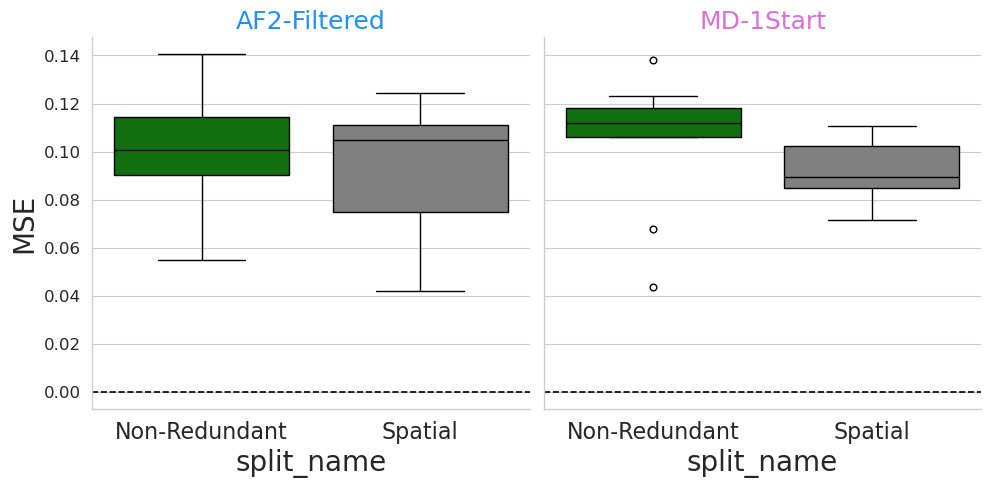

In [75]:



import seaborn as sns
import matplotlib.pyplot as plt
# Set context and style
# sns.set_context("talk")
sns.set_style("whitegrid")
# # # Create a custom palette
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad"]#, "af_conftop", "af_confbottom", "af_conf0.0", "af_conf0.1", "af_conf0.2", "af_conf0.3", "af_conf0.4", "af_conf0.5", "af_conf0.6", "af_conf0.7", "af_conf0.8", "af_conf0.9"]
# _dataset_order = ["MD_Bad", "af_clean"]
_dMSE_energy_df = fit_val_df[fit_val_df["split_type"].isin([ "R3", "Sp"])]

# # include only the _dataset_order
# _dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set_style("whitegrid")

# Create the FacetGrid
g = sns.FacetGrid(_dMSE_energy_df, row="protein", col="ensemble", height=5, aspect=1, 
                  sharey='row', sharex='row', row_order=["BPTI"], col_order=full_dataset_order)

# Map the boxplot with split_type colors
g.map_dataframe(sns.boxplot, x="split_name", y="mse", hue="split_type", 
                palette=split_type_dataset_colours)

# Customize the plot with colored titles
def set_colored_titles(fig):
    for ax, title in zip(fig.axes.flat, full_dataset_order):
        # Get the color for this dataset from full_dataset_colours
        color = full_dataset_colours[title]
        # Set the title with the corresponding color
        ax.set_title(title, color=color)
        
# Apply colored titles
set_colored_titles(g)

# Set labels
g.set_ylabels("MSE")

# Add horizontal line at y=0
for ax in g.axes.flat:
    ax.axhline(y=0, color='black', linestyle='--')

plt.show()

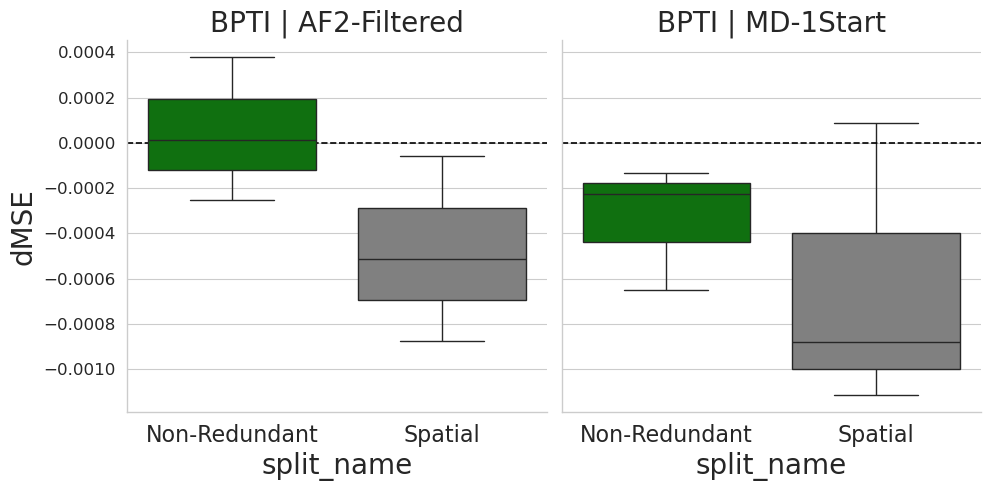

In [76]:



import seaborn as sns
import matplotlib.pyplot as plt
# Set context and style
# sns.set_context("talk")
sns.set_style("whitegrid")
# # Create a custom palette
_dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad"]#, "af_conftop", "af_confbottom", "af_conf0.0", "af_conf0.1", "af_conf0.2", "af_conf0.3", "af_conf0.4", "af_conf0.5", "af_conf0.6", "af_conf0.7", "af_conf0.8", "af_conf0.9"]
# _dataset_order = ["af_dirty", "af_clean", "1Start", "10Start", "TFES"]
_dataset_order = ["af_clean", "1Start"]

_dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin([ "R3", "Sp"])]

# include only the _dataset_order
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(full_dataset_order)]

# Create the FacetGrid
# Map the boxplot to the FacetGrid
g = sns.FacetGrid(_dMSE_energy_df, row="protein", col="ensemble", height=5, aspect=1, sharey='row', sharex='row', row_order=["BPTI"], col_order=full_dataset_order)
g.map_dataframe(sns.boxplot, x="split_name", y="dMSE", hue="split_type", palette={"R3": "green", "Sp": "grey"})
# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}")#, fontsize=16, fontweight="bold")
# g.set_xlabels("energy_difference", fontsize=14)
g.set_ylabels("dMSE")#, fontsize=14)
# # Rotate x-tick labels
# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # Adjust subplot spacing
# g.tight_layout()
# Add legend
# g.set(yscale="log")

# Add a line at y = 0
for ax in g.axes.flat:
    ax.axhline(y=0, color='black', linestyle='--')

# g.add_legend(title="split type")#, fontsize=12)
# Show the plot
# g.set(ylim=(-3, 0))
plt.show()

t-statistic: 1.8963161008619678, p-value: 0.19601460398943657
t-statistic: -4.089961448153863, p-value: 0.053016154403011655


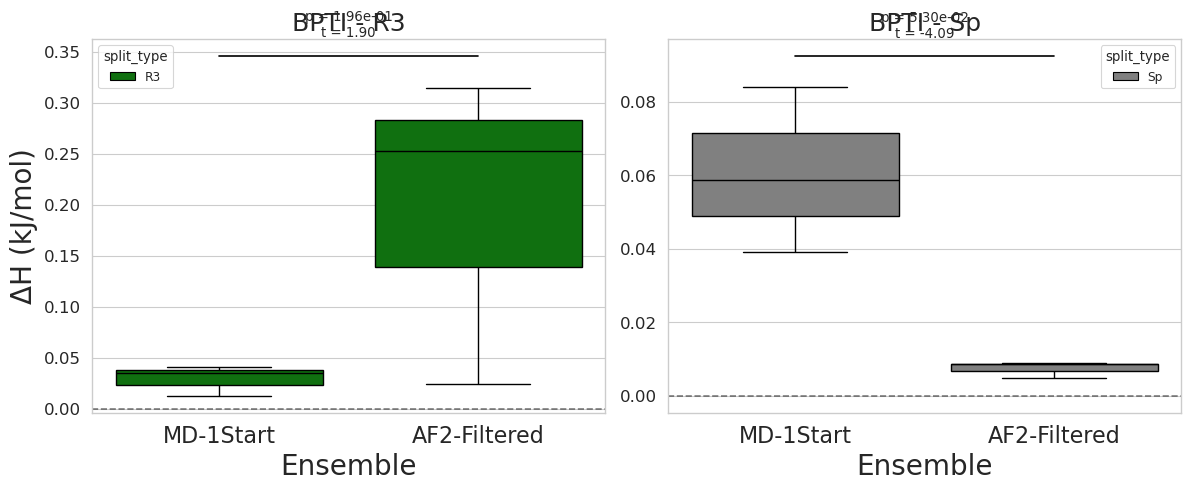

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Set style
sns.set_style("whitegrid")

# Define dataset order and prepare data
dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
dMSE_energy_df = dMSE_energy_df[dMSE_energy_df["ensemble"].isin(full_dataset_order)]

def perform_ttest(data, ensemble1, ensemble2, split_type):
    """
    Perform t-test between two ensembles for a given split type, properly handling NaN values.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        DataFrame containing the data
    ensemble1, ensemble2 : str
        Names of the ensembles to compare
    split_type : str
        The split type to analyze
        
    Returns:
    --------
    t_stat : float
        T-statistic from the test
    p_val : float
        P-value from the test
    """
    # Extract groups and remove NaN values
    # print(data)
    # print(ensemble1)
    group1 = data[(data['ensemble'] == ensemble1) & 
                  (data['split_type'] == split_type)]['delta_H_abs_kj'].dropna()
    # print(group1)
    group2 = data[(data['ensemble'] == ensemble2) & 
                  (data['split_type'] == split_type)]['delta_H_abs_kj'].dropna()
    
    # Perform t-test only if both groups have data
    if len(group1) > 0 and len(group2) > 0:
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
        print(f"t-statistic: {t_stat}, p-value: {p_val}")
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split_type} split type")
        print(f"Group 1 size: {len(group1)}, Group 2 size: {len(group2)}")
        return float('nan'), float('nan')

# Create figure with multiple subplots
proteins = dMSE_energy_df['protein'].unique()
split_types = ["R3", "Sp"]
fig, axes = plt.subplots(len(proteins), len(split_types), figsize=(12, 5*len(proteins)))
if len(proteins) == 1:
    axes = axes.reshape(1, -1)

# Color palette for ensembles
palette = sns.color_palette("Set2", len(full_dataset_order))
for i, protein in enumerate(proteins):
    protein_data = dMSE_energy_df[dMSE_energy_df['protein'] == protein]
    
    for j, split in enumerate(split_types):
        ax = axes[i, j]
        split_data = protein_data[protein_data['split_type'] == split]
        
        # Create violin plot
        sns.boxplot(data=split_data, x='ensemble', y='delta_H_abs_kj', hue='split_type', 
                      ax=ax, palette=split_type_dataset_colours)#, inner='box')
        
        # Perform t-test
        t_stat, p_val = perform_ttest(protein_data, full_dataset_order[0], full_dataset_order[1], split)
        
        # Add statistical annotation
        y_max = split_data['delta_H_abs_kj'].max()
        ax.plot([0, 1], [y_max*1.1, y_max*1.1], 'k-')
        ax.text(0.5, y_max*1.15, f'p = {p_val:.2e}\nt = {t_stat:.2f}', 
                ha='center', va='bottom')
        
        # Customize plot
        ax.set_title(f'{protein} - {split}')
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        if j == 0:
            ax.set_ylabel('ΔH (kJ/mol)')
        else:
            ax.set_ylabel('')
            
        if i == len(proteins)-1:
            ax.set_xlabel('Ensemble')
        else:
            ax.set_xlabel('')

plt.tight_layout()
plt.show()

t-statistic: 1.8963161008619678, p-value: 0.19601460398943657
t-statistic: -4.089961448153863, p-value: 0.053016154403011655


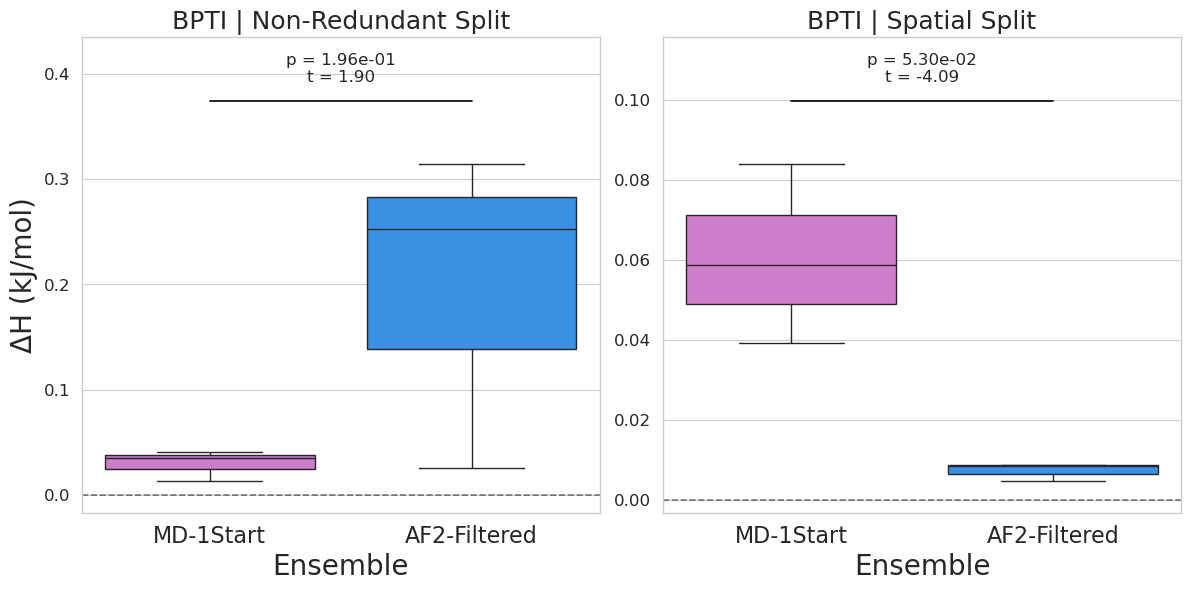

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Set style
sns.set_style("whitegrid")

# Define dataset order and prepare data
dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
dMSE_energy_df = dMSE_energy_df[dMSE_energy_df["ensemble"].isin(full_dataset_order)]

def perform_ttest(data, ensemble1, ensemble2, split_type):
    """
    Perform t-test between two ensembles for a given split type, properly handling NaN values.
    """
    group1 = data[(data['ensemble'] == ensemble1) & 
                  (data['split_type'] == split_type)]['delta_H_abs_kj'].dropna()
    group2 = data[(data['ensemble'] == ensemble2) & 
                  (data['split_type'] == split_type)]['delta_H_abs_kj'].dropna()
    
    if len(group1) > 0 and len(group2) > 0:
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
        print(f"t-statistic: {t_stat}, p-value: {p_val}")
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split_type} split type")
        print(f"Group 1 size: {len(group1)}, Group 2 size: {len(group2)}")
        return float('nan'), float('nan')

# Create figure with multiple subplots
proteins = dMSE_energy_df['protein'].unique()
split_types = ["R3", "Sp"]

# Increase figure height to accommodate statistics
fig, axes = plt.subplots(len(proteins), len(split_types), figsize=(12, 6*len(proteins)))
if len(proteins) == 1:
    axes = axes.reshape(1, -1)

# Color palette for ensembles
palette = sns.color_palette("Set2", len(full_dataset_order))

for i, protein in enumerate(proteins):
    protein_data = dMSE_energy_df[dMSE_energy_df['protein'] == protein]
    for j, split in enumerate(split_types):
        ax = axes[i, j]
        split_data = protein_data[protein_data['split_type'] == split]
        
        # Create box plot
        sns.boxplot(data=split_data, x='ensemble', y='delta_H_abs_kj', hue='ensemble',
                   ax=ax, palette=full_dataset_colours)
        
        # Perform t-test
        t_stat, p_val = perform_ttest(protein_data, full_dataset_order[0], full_dataset_order[1], split)
        
        # Add statistical annotation with more space
        y_max = split_data['delta_H_abs_kj'].max()
        y_range = split_data['delta_H_abs_kj'].max() - split_data['delta_H_abs_kj'].min()
        
        # Adjust the position of the significance bar and text
        bar_height = y_max + 0.2 * y_range
        text_height = y_max + 0.25 * y_range
        
        ax.plot([0, 1], [bar_height, bar_height], 'k-')
        ax.text(0.5, text_height, f'p = {p_val:.2e}\nt = {t_stat:.2f}',
                ha='center', va='bottom', fontsize=12)
        
        # Adjust y-axis limits to accommodate the text
        ax.set_ylim(split_data['delta_H_abs_kj'].min() - 0.1 * y_range, 
                    y_max + 0.4 * y_range)
        
        # Customize plot
        ax.set_title(f'{protein} | {split_name_mapping[split]} Split')
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        if j == 0:
            ax.set_ylabel('ΔH (kJ/mol)')
        else:
            ax.set_ylabel('')
            
        if i == len(proteins)-1:
            ax.set_xlabel('Ensemble')
        else:
            ax.set_xlabel('')


plt.tight_layout()
plt.show()

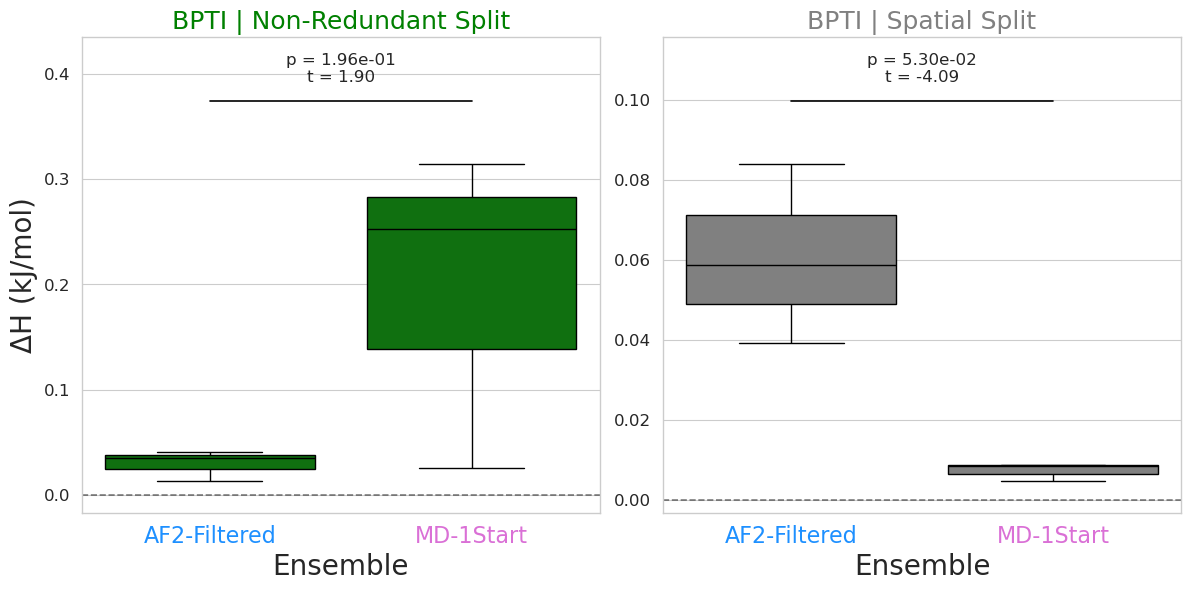

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Set style
sns.set_style("whitegrid")

# Define dataset order and prepare data
dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
dMSE_energy_df = dMSE_energy_df[dMSE_energy_df["ensemble"].isin(full_dataset_order)]

def perform_ttest(data, ensemble1, ensemble2, split_type):
    """
    Perform t-test between two ensembles for a given split type, properly handling NaN values.
    """
    group1 = data[(data['ensemble'] == ensemble1) & 
                  (data['split_type'] == split_type)]['delta_H_abs_kj'].dropna()
    group2 = data[(data['ensemble'] == ensemble2) & 
                  (data['split_type'] == split_type)]['delta_H_abs_kj'].dropna()
    
    if len(group1) > 0 and len(group2) > 0:
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split_type} split type")
        print(f"Group 1 size: {len(group1)}, Group 2 size: {len(group2)}")
        return float('nan'), float('nan')

# Create figure with multiple subplots
proteins = dMSE_energy_df['protein'].unique()
split_types = ["R3", "Sp"]

fig, axes = plt.subplots(len(proteins), len(split_types), figsize=(12, 6*len(proteins)))
if len(proteins) == 1:
    axes = axes.reshape(1, -1)

for i, protein in enumerate(proteins):
    protein_data = dMSE_energy_df[dMSE_energy_df['protein'] == protein]
    
    for j, split in enumerate(split_types):
        ax = axes[i, j]
        split_data = protein_data[protein_data['split_type'] == split]
        
        # Create box plot
        sns.boxplot(data=split_data, x='ensemble', y='delta_H_abs_kj', hue='split_type',
                   ax=ax, palette=split_type_dataset_colours)
        
        # Perform t-test
        t_stat, p_val = perform_ttest(protein_data, full_dataset_order[0], full_dataset_order[1], split)
        
        # Add statistical annotation
        y_max = split_data['delta_H_abs_kj'].max()
        y_range = split_data['delta_H_abs_kj'].max() - split_data['delta_H_abs_kj'].min()
        bar_height = y_max + 0.2 * y_range
        text_height = y_max + 0.25 * y_range
        
        ax.plot([0, 1], [bar_height, bar_height], 'k-')
        ax.text(0.5, text_height, f'p = {p_val:.2e}\nt = {t_stat:.2f}',
                ha='center', va='bottom', fontsize=12)
        
        # Adjust y-axis limits
        ax.set_ylim(split_data['delta_H_abs_kj'].min() - 0.1 * y_range,
                   y_max + 0.4 * y_range)
        
        # Customize plot with colored title
        title_color = split_type_dataset_colours[split]
        ax.set_title(f'{protein} | {split_name_mapping[split]} Split', color=title_color)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        
        # Set x-tick labels explicitly
        ax.set_xticks(range(len(full_dataset_order)))
        labels = ax.set_xticklabels(full_dataset_order)
        
        # Color the labels individually
        for idx, label in enumerate(labels):
            label.set_color(full_dataset_colours[full_dataset_order[idx]])
        
        if j == 0:
            ax.set_ylabel('ΔH (kJ/mol)')
        else:
            ax.set_ylabel('')
            
        if i == len(proteins)-1:
            ax.set_xlabel('Ensemble')
        else:
            ax.set_xlabel('')
            
        # Remove legend if present
        if ax.get_legend() is not None:
            ax.get_legend().remove()

plt.tight_layout()
plt.show()

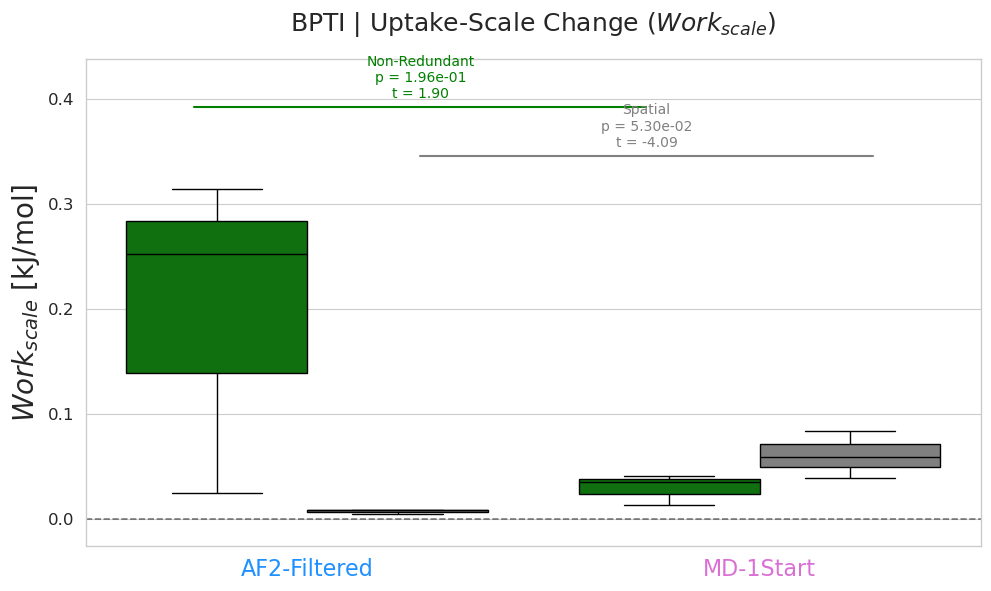

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Set style
sns.set_style("whitegrid")
y_metric = "delta_H_abs_kj"

def perform_ttest(data, ensemble1, ensemble2, split_type):
    """
    Perform t-test between two ensembles for a given split type, properly handling NaN values.
    """
    group1 = data[(data['ensemble'] == ensemble1) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    group2 = data[(data['ensemble'] == ensemble2) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    
    if len(group1) > 0 and len(group2) > 0:
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split_type} split type")
        print(f"Group 1 size: {len(group1)}, Group 2 size: {len(group2)}")
        return float('nan'), float('nan')

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Ensure consistent ordering by setting order parameters
ensemble_order = full_dataset_order
split_order = ["Sp", "R3"]

# Create box plot with explicit ordering
sns.boxplot(data=dMSE_energy_df, 
            x='ensemble', 
            y=y_metric, 
            hue='split_name',
            order=ensemble_order,
            hue_order=split_name_dataset_order,
            ax=ax, 
            palette=split_name_dataset_colours)

# Get the plot limits for positioning annotations
y_max = dMSE_energy_df[y_metric].max()
y_min = dMSE_energy_df[y_metric].min()
y_range = y_max - y_min

# Calculate box positions
box_positions = {
    'Sp': 0.25,
    'R3': -0.25
}

# Add title
metric_name = metric_name_mapping.get(y_metric, 'Unknown Metric')
protein_name = "BPTI"  # Replace with actual protein name if available
plt.title(f"{protein_name} | {metric_name}", pad=20)

# Perform t-tests and add statistical annotations for each split type
spacing_factor = 0.15
for idx, split in enumerate(split_order):  # Use split_order to ensure consistent ordering
    t_stat, p_val = perform_ttest(dMSE_energy_df, ensemble_order[0], ensemble_order[1], split)
    
    # Calculate vertical positions for annotations
    base_height = y_max + (0.1 + idx * spacing_factor) * y_range
    
    # Add bar with adjusted horizontal position
    ax.plot([box_positions[split], 1 + box_positions[split]], 
            [base_height, base_height],
            '-',
            color=split_type_dataset_colours[split],
            linewidth=1.5)
    
    # Add text with adjusted horizontal position
    ax.text(0.5 + box_positions[split],
            base_height + 0.02 * y_range,
            f'{split_name_mapping[split]}\np = {p_val:.2e}\nt = {t_stat:.2f}',
            ha='center',
            va='bottom',
            fontsize=10,
            color=split_type_dataset_colours[split])

# Customize plot
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel(metric_axis_mapping.get(y_metric, 'Unknown Metric'))
ax.set_xlabel('')

# Set x-tick labels with colors using the specified order
ax.set_xticks(range(len(ensemble_order)))
labels = ax.set_xticklabels(ensemble_order)
for idx, label in enumerate(labels):
    label.set_color(full_dataset_colours[ensemble_order[idx]])

# Customize legend
legend = ax.get_legend()
legend.set_title('Split Type')
for text in legend.get_texts():
    text.set_color(split_name_dataset_colours[text.get_text()])
ax.get_legend().remove()

# Adjust y-axis limits to accommodate annotations
ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.4 * y_range)

plt.tight_layout()
plt.show()

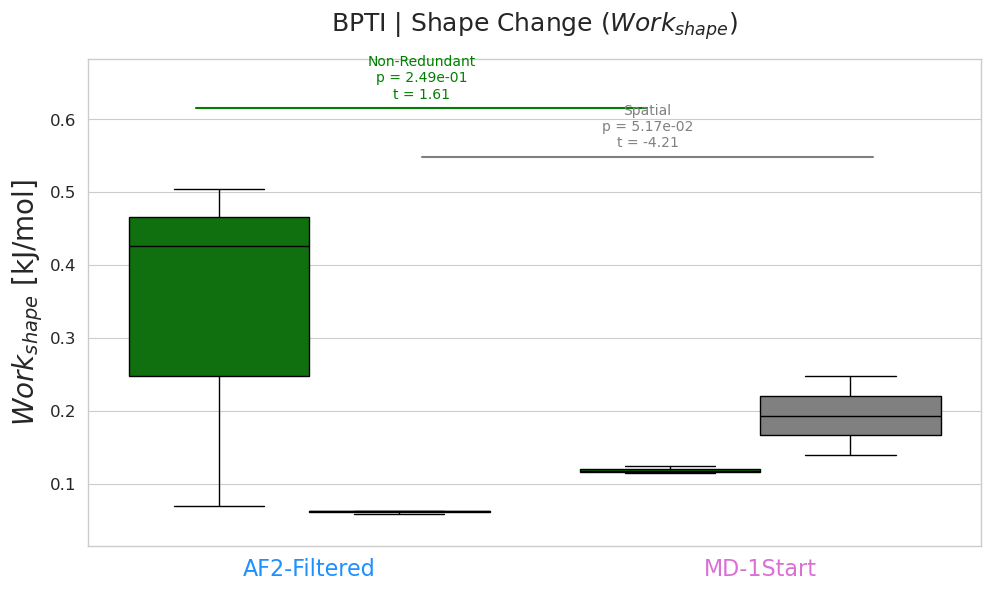

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Set style
sns.set_style("whitegrid")

y_metric = "delta_H_opt_kj"


def perform_ttest(data, ensemble1, ensemble2, split_type):
    """
    Perform t-test between two ensembles for a given split type, properly handling NaN values.
    """
    group1 = data[(data['ensemble'] == ensemble1) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    group2 = data[(data['ensemble'] == ensemble2) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    
    if len(group1) > 0 and len(group2) > 0:
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split_type} split type")
        print(f"Group 1 size: {len(group1)}, Group 2 size: {len(group2)}")
        return float('nan'), float('nan')

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Ensure consistent ordering by setting order parameters
ensemble_order = full_dataset_order
split_order = ["Sp", "R3"]

# Create box plot with explicit ordering
sns.boxplot(data=dMSE_energy_df, 
            x='ensemble', 
            y=y_metric, 
            hue='split_name',
            order=ensemble_order,
            hue_order=split_name_dataset_order,
            ax=ax, 
            palette=split_name_dataset_colours)

# Get the plot limits for positioning annotations
y_max = dMSE_energy_df[y_metric].max()
y_min = dMSE_energy_df[y_metric].min()
y_range = y_max - y_min

# Calculate box positions
box_positions = {
    'Sp': 0.25,
    'R3': -0.25
}

# Add title
metric_name = metric_name_mapping.get(y_metric, 'Unknown Metric')
protein_name = "BPTI"  # Replace with actual protein name if available
plt.title(f"{protein_name} | {metric_name}", pad=20)

# Perform t-tests and add statistical annotations for each split type
spacing_factor = 0.15
for idx, split in enumerate(split_order):  # Use split_order to ensure consistent ordering
    t_stat, p_val = perform_ttest(dMSE_energy_df, ensemble_order[0], ensemble_order[1], split)
    
    # Calculate vertical positions for annotations
    base_height = y_max + (0.1 + idx * spacing_factor) * y_range
    
    # Add bar with adjusted horizontal position
    ax.plot([box_positions[split], 1 + box_positions[split]], 
            [base_height, base_height],
            '-',
            color=split_type_dataset_colours[split],
            linewidth=1.5)
    
    # Add text with adjusted horizontal position
    ax.text(0.5 + box_positions[split],
            base_height + 0.02 * y_range,
            f'{split_name_mapping[split]}\np = {p_val:.2e}\nt = {t_stat:.2f}',
            ha='center',
            va='bottom',
            fontsize=10,
            color=split_type_dataset_colours[split])

# Customize plot
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel(metric_axis_mapping.get(y_metric, 'Unknown Metric'))
ax.set_xlabel('')

# Set x-tick labels with colors using the specified order
ax.set_xticks(range(len(ensemble_order)))
labels = ax.set_xticklabels(ensemble_order)
for idx, label in enumerate(labels):
    label.set_color(full_dataset_colours[ensemble_order[idx]])

# Customize legend
legend = ax.get_legend()
legend.set_title('Split Type')
for text in legend.get_texts():
    text.set_color(split_name_dataset_colours[text.get_text()])
ax.get_legend().remove()

# Adjust y-axis limits to accommodate annotations
ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.4 * y_range)

plt.tight_layout()
plt.show()


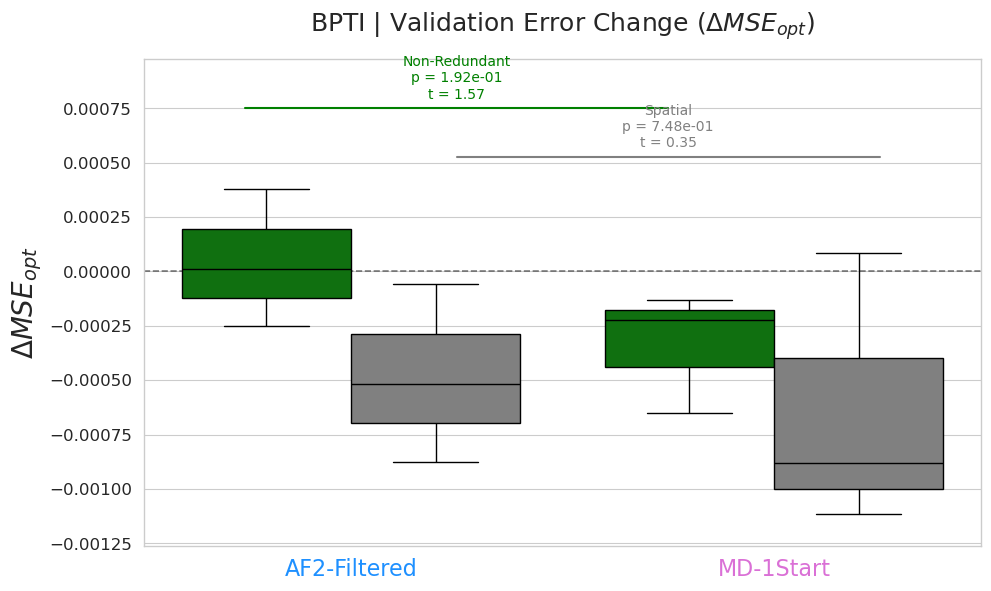

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Set style
sns.set_style("whitegrid")

y_metric = "dMSE"


def perform_ttest(data, ensemble1, ensemble2, split_type):
    """
    Perform t-test between two ensembles for a given split type, properly handling NaN values.
    """
    group1 = data[(data['ensemble'] == ensemble1) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    group2 = data[(data['ensemble'] == ensemble2) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    
    if len(group1) > 0 and len(group2) > 0:
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split_type} split type")
        print(f"Group 1 size: {len(group1)}, Group 2 size: {len(group2)}")
        return float('nan'), float('nan')

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Ensure consistent ordering by setting order parameters
ensemble_order = full_dataset_order
split_order = ["Sp", "R3"]

# Create box plot with explicit ordering
sns.boxplot(data=dMSE_energy_df, 
            x='ensemble', 
            y=y_metric, 
            hue='split_name',
            order=ensemble_order,
            hue_order=split_name_dataset_order,
            ax=ax, 
            palette=split_name_dataset_colours)

# Get the plot limits for positioning annotations
y_max = dMSE_energy_df[y_metric].max()
y_min = dMSE_energy_df[y_metric].min()
y_range = y_max - y_min

# Calculate box positions
box_positions = {
    'Sp': 0.25,
    'R3': -0.25
}

# Add title
metric_name = metric_name_mapping.get(y_metric, 'Unknown Metric')
protein_name = "BPTI"  # Replace with actual protein name if available
plt.title(f"{protein_name} | {metric_name}", pad=20)

# Perform t-tests and add statistical annotations for each split type
spacing_factor = 0.15
for idx, split in enumerate(split_order):  # Use split_order to ensure consistent ordering
    t_stat, p_val = perform_ttest(dMSE_energy_df, ensemble_order[0], ensemble_order[1], split)
    
    # Calculate vertical positions for annotations
    base_height = y_max + (0.1 + idx * spacing_factor) * y_range
    
    # Add bar with adjusted horizontal position
    ax.plot([box_positions[split], 1 + box_positions[split]], 
            [base_height, base_height],
            '-',
            color=split_type_dataset_colours[split],
            linewidth=1.5)
    
    # Add text with adjusted horizontal position
    ax.text(0.5 + box_positions[split],
            base_height + 0.02 * y_range,
            f'{split_name_mapping[split]}\np = {p_val:.2e}\nt = {t_stat:.2f}',
            ha='center',
            va='bottom',
            fontsize=10,
            color=split_type_dataset_colours[split])

# Customize plot
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel(metric_axis_mapping.get(y_metric, 'Unknown Metric'))
ax.set_xlabel('')

# Set x-tick labels with colors using the specified order
ax.set_xticks(range(len(ensemble_order)))
labels = ax.set_xticklabels(ensemble_order)
for idx, label in enumerate(labels):
    label.set_color(full_dataset_colours[ensemble_order[idx]])

# Customize legend
legend = ax.get_legend()
legend.set_title('Split Type')
for text in legend.get_texts():
    text.set_color(split_name_dataset_colours[text.get_text()])
ax.get_legend().remove()

# Adjust y-axis limits to accommodate annotations
ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.4 * y_range)

plt.tight_layout()
plt.show()


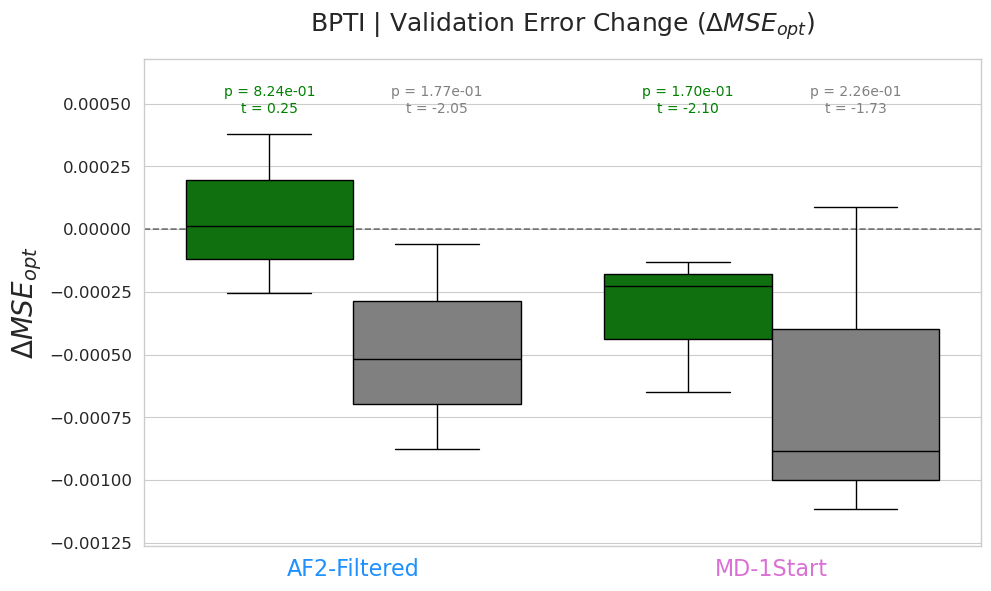

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Set style
sns.set_style("whitegrid")
y_metric = "dMSE"

def perform_one_sample_ttest(data, ensemble, split):
    """
    Perform one-sample t-test against 0 for a given ensemble and split.
    """
    group = data[(data['ensemble'] == ensemble) & 
                 (data['split_name'] == split)][y_metric].dropna()
    
    if len(group) > 0:
        t_stat, p_val = stats.ttest_1samp(group, 0)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split} split for {ensemble}")
        print(f"Group size: {len(group)}")
        return float('nan'), float('nan')

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create box plot with explicit ordering and no legend
sns.boxplot(data=dMSE_energy_df,
            x='ensemble',
            y=y_metric,
            hue='split_name',
            order=ensemble_order,
            hue_order=split_name_dataset_order,
            ax=ax,
            palette=split_name_dataset_colours,
            legend=False)  # Disable the legend here

# Get the plot limits for positioning annotations
y_max = dMSE_energy_df[y_metric].max()
y_min = dMSE_energy_df[y_metric].min()
y_range = y_max - y_min

# Add title
metric_name = metric_name_mapping.get(y_metric, 'Unknown Metric')
protein_name = "BPTI"  # Replace with actual protein name if available
plt.title(f"{protein_name} | {metric_name}", pad=20)

# Calculate box positions dynamically based on ensemble and split indices
n_ensembles = len(ensemble_order)
n_splits = len(split_name_dataset_order)
hue_offset = 0.2  # Default offset for two splits in seaborn

# Perform t-tests and add annotations for each box
for ensemble in ensemble_order:
    for split in split_name_dataset_order:
        # Get indices for positioning
        ensemble_idx = ensemble_order.index(ensemble)
        split_idx = split_name_dataset_order.index(split)
        
        # Calculate x position: main position + hue offset
        x_pos = ensemble_idx + (-hue_offset if split_idx == 0 else hue_offset)
        
        # Perform t-test
        t_stat, p_val = perform_one_sample_ttest(dMSE_energy_df, ensemble, split)
        
        # Determine y position (slightly above the top of the highest box)
        y_pos = y_max + 0.05 * y_range
        
        # Add text annotation
        ax.text(x_pos, y_pos,
                f'p = {p_val:.2e}\nt = {t_stat:.2f}',
                ha='center',
                va='bottom',
                fontsize=10,
                color=split_name_dataset_colours[split])

# Customize plot
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel(metric_axis_mapping.get(y_metric, 'Unknown Metric'))
ax.set_xlabel('')

# Set x-tick labels with colors using the specified order
ax.set_xticks(range(len(ensemble_order)))
labels = ax.set_xticklabels(ensemble_order)
for idx, label in enumerate(labels):
    label.set_color(full_dataset_colours[ensemble_order[idx]])

# Adjust y-axis limits to accommodate annotations
ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.2 * y_range)

plt.tight_layout()
plt.show()

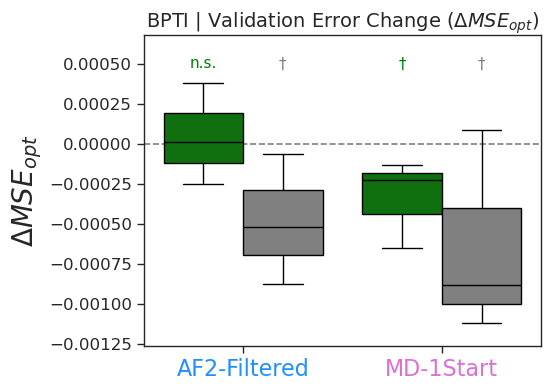

In [84]:
# Set style
sns.set_style("ticks")
y_metric = "dMSE"

def perform_one_sample_ttest(data, ensemble, split):
    """
    Perform one-sample t-test against 0 for a given ensemble and split.
    """
    group = data[(data['ensemble'] == ensemble) & 
                 (data['split_name'] == split)][y_metric].dropna()
    
    if len(group) > 0:
        t_stat, p_val = stats.ttest_1samp(group, 0)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split} split for {ensemble}")
        print(f"Group size: {len(group)}")
        return float('nan'), float('nan')

def p_to_stars(p_val):
    """Convert p-value to significance stars."""
    if pd.isna(p_val):
        return 'n.s.'
    elif p_val < 0.0001:
        return '****'
    elif p_val < 0.001:
        return '***'
    elif p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    elif p_val < 0.1:
        return '‡'  # Unicode double dagger (U+2021)
    elif p_val < 0.25:
        return '†'  # Unicode single dagger (U+2020)
    else:
        return 'n.s.'

# Create figure
fig, ax = plt.subplots(figsize=(7, 4))

# Create box plot with explicit ordering and no legend
sns.boxplot(data=dMSE_energy_df,
            x='ensemble',
            y=y_metric,
            hue='split_name',
            order=ensemble_order,
            hue_order=split_name_dataset_order,
            ax=ax,
            palette=split_name_dataset_colours,
            legend=False)  # Disable the legend here

# Get the plot limits for positioning annotations
y_max = dMSE_energy_df[y_metric].max()
y_min = dMSE_energy_df[y_metric].min()
y_range = y_max - y_min

# Add title
metric_name = metric_name_mapping.get(y_metric, 'Unknown Metric')
protein_name = "BPTI"  # Replace with actual protein name if available
plt.title(f"{protein_name} | {metric_name}", fontsize=14)

# Calculate box positions dynamically based on ensemble and split indices
n_ensembles = len(ensemble_order)
n_splits = len(split_name_dataset_order)
hue_offset = 0.2  # Default offset for two splits in seaborn

# Perform t-tests and add annotations for each box
for ensemble in ensemble_order:
    for split in split_name_dataset_order:
        # Get indices for positioning
        ensemble_idx = ensemble_order.index(ensemble)
        split_idx = split_name_dataset_order.index(split)
        
        # Calculate x position: main position + hue offset
        x_pos = ensemble_idx + (-hue_offset if split_idx == 0 else hue_offset)
        
        # Perform t-test
        t_stat, p_val = perform_one_sample_ttest(dMSE_energy_df, ensemble, split)
        
        # Convert p-value to stars
        stars = p_to_stars(p_val)
        
        # Determine y position (slightly above the top of the highest box)
        y_pos = y_max + 0.05 * y_range
        
        # Add text annotation
        ax.text(x_pos, y_pos,
                stars,
                ha='center',
                va='bottom',
                fontsize=11,
                color=split_name_dataset_colours[split])

# Customize plot
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel(metric_axis_mapping.get(y_metric, 'Unknown Metric'))
ax.set_xlabel('')

# Set x-tick labels with colors using the specified order
ax.set_xticks(range(len(ensemble_order)))
labels = ax.set_xticklabels(ensemble_order)
for idx, label in enumerate(labels):
    label.set_color(full_dataset_colours[ensemble_order[idx]])

# Adjust y-axis limits to accommodate annotations
ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.2 * y_range)

plt.tight_layout(rect=[0.2,0,1,1])  # Adjust layout to fit title
plt.show()

In [85]:
fit_val_df

,time,Type,R,calc_name,mse,name,system,analysis,split_type,protein,name_name,dataset,class,method,fit,ensemble,split_name,replicate
22,0.167,Val,NaN,val_BPTI_10Start_1,0.122628,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,RW,bench,MD-10Start,Non-Redundant,1
23,0.167,Val,NaN,val_BPTI_10Start_2,0.140999,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,RW,bench,MD-10Start,Non-Redundant,2
24,0.167,Val,NaN,val_BPTI_10Start_3,0.113142,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,RW,bench,MD-10Start,Non-Redundant,3
29,1.000,Val,NaN,val_BPTI_10Start_1,0.143339,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,RW,bench,MD-10Start,Non-Redundant,1
30,1.000,Val,NaN,val_BPTI_10Start_2,0.108500,BPTI_10Start_RW_bench_R3_k_sequence,BPTI_10Start_RW_bench_R3_k_sequence,bench,R3,BPTI,BPTI_10Start_RW_bench_R3_k_sequence_val_BPTI_1...,val,val_R3,RW,bench,MD-10Start,Non-Redundant,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,1.000,Val,NaN,val_BPTI_1Start_2,0.102913,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,RW,bench,MD-1Start,Sequence,2
31,1.000,Val,NaN,val_BPTI_1Start_3,0.056555,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,RW,bench,MD-1Start,Sequence,3
36,10.000,Val,NaN,val_BPTI_1Start_1,0.020129,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,RW,bench,MD-1Start,Sequence,1
37,10.000,Val,NaN,val_BPTI_1Start_2,0.158534,BPTI_1Start_RW_bench_s_naive_sequential,BPTI_1Start_RW_bench_s_naive_sequential,bench,s,BPTI,BPTI_1Start_RW_bench_s_naive_sequential_val_BP...,val,val_s,RW,bench,MD-1Start,Sequence,2


In [86]:
_fit_val_df = fit_val_df[fit_val_df["split_type"].isin(["R3", "Sp"])]
_fit_val_df = _fit_val_df[_fit_val_df["ensemble"].isin(full_dataset_order)]


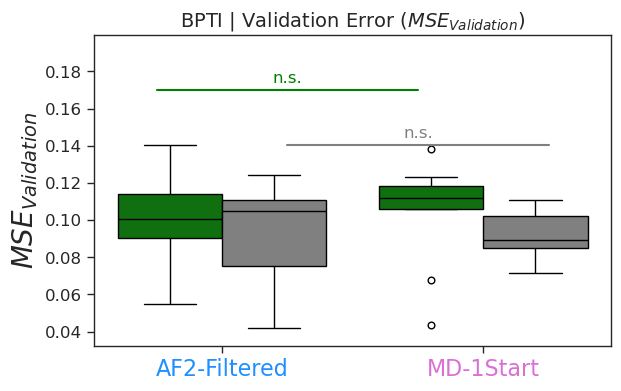

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Set style
sns.set_style("ticks")

y_metric = "mse"
_fit_val_df = fit_val_df[fit_val_df["split_type"].isin(["R3", "Sp"])]
_fit_val_df = _fit_val_df[_fit_val_df["ensemble"].isin(full_dataset_order)]


def perform_ttest(data, ensemble1, ensemble2, split_type):
    """
    Perform t-test between two ensembles for a given split type, properly handling NaN values.
    """
    group1 = data[(data['ensemble'] == ensemble1) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    group2 = data[(data['ensemble'] == ensemble2) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    
    if len(group1) > 0 and len(group2) > 0:
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split_type} split type")
        print(f"Group 1 size: {len(group1)}, Group 2 size: {len(group2)}")
        return float('nan'), float('nan')

# Create figure
fig, ax = plt.subplots(figsize=(7, 4))

# Ensure consistent ordering by setting order parameters
ensemble_order = full_dataset_order
split_order = ["Sp", "R3"]

# Create box plot with explicit ordering
sns.boxplot(data=_fit_val_df, 
            x='ensemble', 
            y=y_metric, 
            hue='split_name',
            order=ensemble_order,
            hue_order=split_name_dataset_order,
            ax=ax, 
            palette=split_name_dataset_colours)

# Get the plot limits for positioning annotations
y_max = _fit_val_df[y_metric].max()
y_min = _fit_val_df[y_metric].min()
y_range = y_max - y_min

# Calculate box positions
box_positions = {
    'Sp': 0.25,
    'R3': -0.25
}

# Add title
metric_name = metric_name_mapping.get(y_metric, 'Unknown Metric')
protein_name = "BPTI"  # Replace with actual protein name if available
plt.title(f"{protein_name} | {metric_name}", fontsize=14)

# Perform t-tests and add statistical annotations for each split type
spacing_factor = 0.2
for idx, split in enumerate(split_order):  # Use split_order to ensure consistent ordering
    t_stat, p_val = perform_ttest(_fit_val_df, ensemble_order[0], ensemble_order[1], split)
    
    # Calculate vertical positions for annotations
    base_height = y_max + (idx * 0.3) * y_range
    
    # Add bar with adjusted horizontal position
    ax.plot([box_positions[split], 1 + box_positions[split]], 
            [base_height, base_height],
            '-',
            color=split_type_dataset_colours[split],
            linewidth=1.5)
    
    stars = p_to_stars(p_val)
    
    # Add text with adjusted horizontal position
    ax.text(0.5 + box_positions[split],
            base_height + 0.02 * y_range,
            stars,
            ha='center',
            va='bottom',
            fontsize=12,
            color=split_type_dataset_colours[split])

# Customize plot
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel(metric_axis_mapping.get(y_metric, 'Unknown Metric'))
ax.set_xlabel('')

# Set x-tick labels with colors using the specified order
ax.set_xticks(range(len(ensemble_order)))
labels = ax.set_xticklabels(ensemble_order)
for idx, label in enumerate(labels):
    label.set_color(full_dataset_colours[ensemble_order[idx]])

# Customize legend
legend = ax.get_legend()
legend.set_title('Split Type')
for text in legend.get_texts():
    text.set_color(split_name_dataset_colours[text.get_text()])
ax.get_legend().remove()

# Adjust y-axis limits to accommodate annotations
ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.6 * y_range)

plt.tight_layout(rect=[0.1,0,1,1])  # Adjust layout to fit title
plt.show()


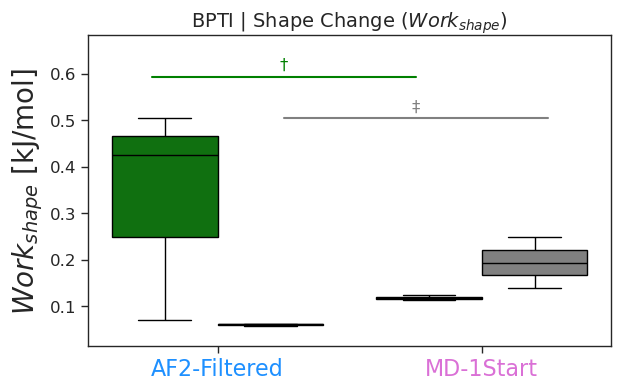

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Set style
sns.set_style("ticks")

y_metric = "delta_H_opt_kj"


def perform_ttest(data, ensemble1, ensemble2, split_type):
    """
    Perform t-test between two ensembles for a given split type, properly handling NaN values.
    """
    group1 = data[(data['ensemble'] == ensemble1) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    group2 = data[(data['ensemble'] == ensemble2) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    
    if len(group1) > 0 and len(group2) > 0:
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split_type} split type")
        print(f"Group 1 size: {len(group1)}, Group 2 size: {len(group2)}")
        return float('nan'), float('nan')

# Create figure
fig, ax = plt.subplots(figsize=(7, 4))

# Ensure consistent ordering by setting order parameters
ensemble_order = full_dataset_order
split_order = ["Sp", "R3"]

# Create box plot with explicit ordering
sns.boxplot(data=dMSE_energy_df, 
            x='ensemble', 
            y=y_metric, 
            hue='split_name',
            order=ensemble_order,
            hue_order=split_name_dataset_order,
            ax=ax, 
            palette=split_name_dataset_colours)

# Get the plot limits for positioning annotations
y_max = dMSE_energy_df[y_metric].max()
y_min = dMSE_energy_df[y_metric].min()
y_range = y_max - y_min

# Calculate box positions
box_positions = {
    'Sp': 0.25,
    'R3': -0.25
}

# Add title
metric_name = metric_name_mapping.get(y_metric, 'Unknown Metric')
protein_name = "BPTI"  # Replace with actual protein name if available
# plt.title(f"{protein_name} | {metric_name}", fontsize=20, pad=20)
plt.title(f"{protein_name} | {metric_name}", fontsize=14)
# Perform t-tests and add statistical annotations for each split type
spacing_factor = 0.2
for idx, split in enumerate(split_order):  # Use split_order to ensure consistent ordering
    t_stat, p_val = perform_ttest(dMSE_energy_df, ensemble_order[0], ensemble_order[1], split)
    
    # Calculate vertical positions for annotations
    base_height = y_max + ( idx * spacing_factor) * y_range
    
    # Add bar with adjusted horizontal position
    ax.plot([box_positions[split], 1 + box_positions[split]], 
            [base_height, base_height],
            '-',
            color=split_type_dataset_colours[split],
            linewidth=1.5)
    stars = p_to_stars(p_val)
    # Add text with adjusted horizontal position
    ax.text(0.5 + box_positions[split],
            base_height + 0.02 * y_range,
            stars,
            ha='center',
            va='bottom',
            fontsize=12,
            color=split_type_dataset_colours[split])

# Customize plot
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel(metric_axis_mapping.get(y_metric, 'Unknown Metric'))
ax.set_xlabel('')

# Set x-tick labels with colors using the specified order
ax.set_xticks(range(len(ensemble_order)))
labels = ax.set_xticklabels(ensemble_order)
for idx, label in enumerate(labels):
    label.set_color(full_dataset_colours[ensemble_order[idx]])

# Customize legend
legend = ax.get_legend()
legend.set_title('Split Type')
for text in legend.get_texts():
    text.set_color(split_name_dataset_colours[text.get_text()])
ax.get_legend().remove()

# Adjust y-axis limits to accommodate annotations
ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.4 * y_range)

plt.tight_layout(rect=[0.1,0,1,1])
  # Adjust layout to fit title
plt.show()


In [89]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy import stats
# import pandas as pd

# # Set style
# sns.set_style("ticks")

# y_metric = "delta_H_opt_kj"


# def perform_ttest(data, ensemble1, ensemble2, split_type):
#     """
#     Perform t-test between two ensembles for a given split type, properly handling NaN values.
#     """
#     group1 = data[(data['ensemble'] == ensemble1) & 
#                   (data['split_type'] == split_type)][y_metric].dropna()
#     group2 = data[(data['ensemble'] == ensemble2) & 
#                   (data['split_type'] == split_type)][y_metric].dropna()
    
#     if len(group1) > 0 and len(group2) > 0:
#         t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
#         return t_stat, p_val
#     else:
#         print(f"Warning: Insufficient data for t-test in {split_type} split type")
#         print(f"Group 1 size: {len(group1)}, Group 2 size: {len(group2)}")
#         return float('nan'), float('nan')


# # Create figure
# fig, ax = plt.subplots(figsize=(7, 4))

# # Ensure consistent ordering by setting order parameters
# ensemble_order = full_dataset_order
# split_order = ["Sp", "R3"]

# # Create box plot with explicit ordering
# sns.boxplot(data=dMSE_energy_df, 
#             x='ensemble', 
#             y=y_metric, 
#             hue='split_name',
#             order=ensemble_order,
#             hue_order=split_name_dataset_order,
#             ax=ax, 
#             palette=split_name_dataset_colours)

# # Get the plot limits for positioning annotations
# y_max = dMSE_energy_df[y_metric].max()
# y_min = dMSE_energy_df[y_metric].min()
# y_range = y_max - y_min

# # Calculate box positions
# box_positions = {
#     'Sp': 0.25,
#     'R3': -0.25
# }

# # Add title
# metric_name = metric_name_mapping.get(y_metric, 'Unknown Metric')
# protein_name = "BPTI"  # Replace with actual protein name if available
# # plt.title(f"{protein_name} | {metric_name}", fontsize=20, pad=20)
# plt.title(f"{protein_name} | {metric_name}", fontsize=14)
# # Perform t-tests and add statistical annotations for each split type
# spacing_factor = 0.2
# for idx, split in enumerate(split_order):  # Use split_order to ensure consistent ordering
#     t_stat, p_val = perform_ttest(dMSE_energy_df, ensemble_order[0], ensemble_order[1], split)
    
#     # Calculate vertical positions for annotations
#     base_height = y_max + ( idx * spacing_factor) * y_range
    
#     # Add bar with adjusted horizontal position
#     ax.plot([box_positions[split], 1 + box_positions[split]], 
#             [base_height, base_height],
#             '-',
#             color=split_type_dataset_colours[split],
#             linewidth=1.5)
#     stars = p_to_stars(p_val)
#     # Add text with adjusted horizontal position
#     ax.text(0.5 + box_positions[split],
#             base_height + 0.02 * y_range,
#             stars,
#             ha='center',
#             va='bottom',
#             fontsize=12,
#             color=split_type_dataset_colours[split])

# # Customize plot
# ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
# ax.set_ylabel(metric_axis_mapping.get(y_metric, 'Unknown Metric'))
# ax.set_xlabel('')

# # Set x-tick labels with colors using the specified order
# ax.set_xticks(range(len(ensemble_order)))
# labels = ax.set_xticklabels(ensemble_order)
# for idx, label in enumerate(labels):
#     label.set_color(full_dataset_colours[ensemble_order[idx]])

# # Customize legend
# legend = ax.get_legend()
# legend.set_title('Split Type')
# for text in legend.get_texts():
#     text.set_color(split_name_dataset_colours[text.get_text()])
# ax.get_legend().remove()

# # Adjust y-axis limits to accommodate annotations
# ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.4 * y_range)

# plt.tight_layout(rect=[0.25, 0, 1, 1])
# plt.show()


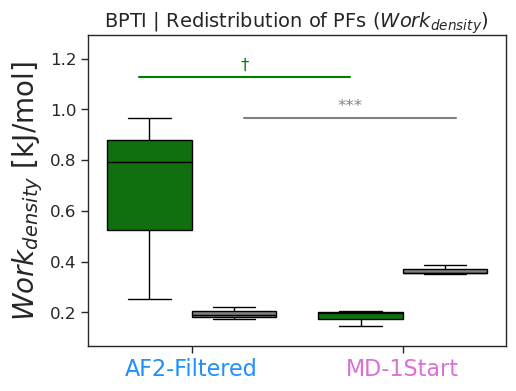

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Set style
sns.set_style("ticks")

y_metric = "-Tdelta_S_opt_kj"


def perform_ttest(data, ensemble1, ensemble2, split_type):
    """
    Perform t-test between two ensembles for a given split type, properly handling NaN values.
    """
    group1 = data[(data['ensemble'] == ensemble1) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    group2 = data[(data['ensemble'] == ensemble2) & 
                  (data['split_type'] == split_type)][y_metric].dropna()
    
    if len(group1) > 0 and len(group2) > 0:
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split_type} split type")
        print(f"Group 1 size: {len(group1)}, Group 2 size: {len(group2)}")
        return float('nan'), float('nan')


# Create figure
fig, ax = plt.subplots(figsize=(7, 4))

# Ensure consistent ordering by setting order parameters
ensemble_order = full_dataset_order
split_order = ["Sp", "R3"]

# Create box plot with explicit ordering
sns.boxplot(data=dMSE_energy_df, 
            x='ensemble', 
            y=y_metric, 
            hue='split_name',
            order=ensemble_order,
            hue_order=split_name_dataset_order,
            ax=ax, 
            palette=split_name_dataset_colours)

# Get the plot limits for positioning annotations
y_max = dMSE_energy_df[y_metric].max()
y_min = dMSE_energy_df[y_metric].min()
y_range = y_max - y_min

# Calculate box positions
box_positions = {
    'Sp': 0.25,
    'R3': -0.25
}

# Add title
metric_name = metric_name_mapping.get(y_metric, 'Unknown Metric')
protein_name = "BPTI"  # Replace with actual protein name if available
# plt.title(f"{protein_name} | {metric_name}", fontsize=20, pad=20)
plt.title(f"{protein_name} | {metric_name}", fontsize=14)
# Perform t-tests and add statistical annotations for each split type
spacing_factor = 0.2
for idx, split in enumerate(split_order):  # Use split_order to ensure consistent ordering
    t_stat, p_val = perform_ttest(dMSE_energy_df, ensemble_order[0], ensemble_order[1], split)
    
    # Calculate vertical positions for annotations
    base_height = y_max + ( idx * spacing_factor) * y_range
    
    # Add bar with adjusted horizontal position
    ax.plot([box_positions[split], 1 + box_positions[split]], 
            [base_height, base_height],
            '-',
            color=split_type_dataset_colours[split],
            linewidth=1.5)
    stars = p_to_stars(p_val)
    # Add text with adjusted horizontal position
    ax.text(0.5 + box_positions[split],
            base_height + 0.02 * y_range,
            stars,
            ha='center',
            va='bottom',
            fontsize=12,
            color=split_type_dataset_colours[split])

# Customize plot
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_ylabel(metric_axis_mapping.get(y_metric, 'Unknown Metric'))
ax.set_xlabel('')

# Set x-tick labels with colors using the specified order
ax.set_xticks(range(len(ensemble_order)))
labels = ax.set_xticklabels(ensemble_order)
for idx, label in enumerate(labels):
    label.set_color(full_dataset_colours[ensemble_order[idx]])

# Customize legend
legend = ax.get_legend()
legend.set_title('Split Type')
for text in legend.get_texts():
    text.set_color(split_name_dataset_colours[text.get_text()])
ax.get_legend().remove()

# Adjust y-axis limits to accommodate annotations
ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.4 * y_range)

plt.tight_layout(rect=[0.25, 0, 1, 1])
plt.show()


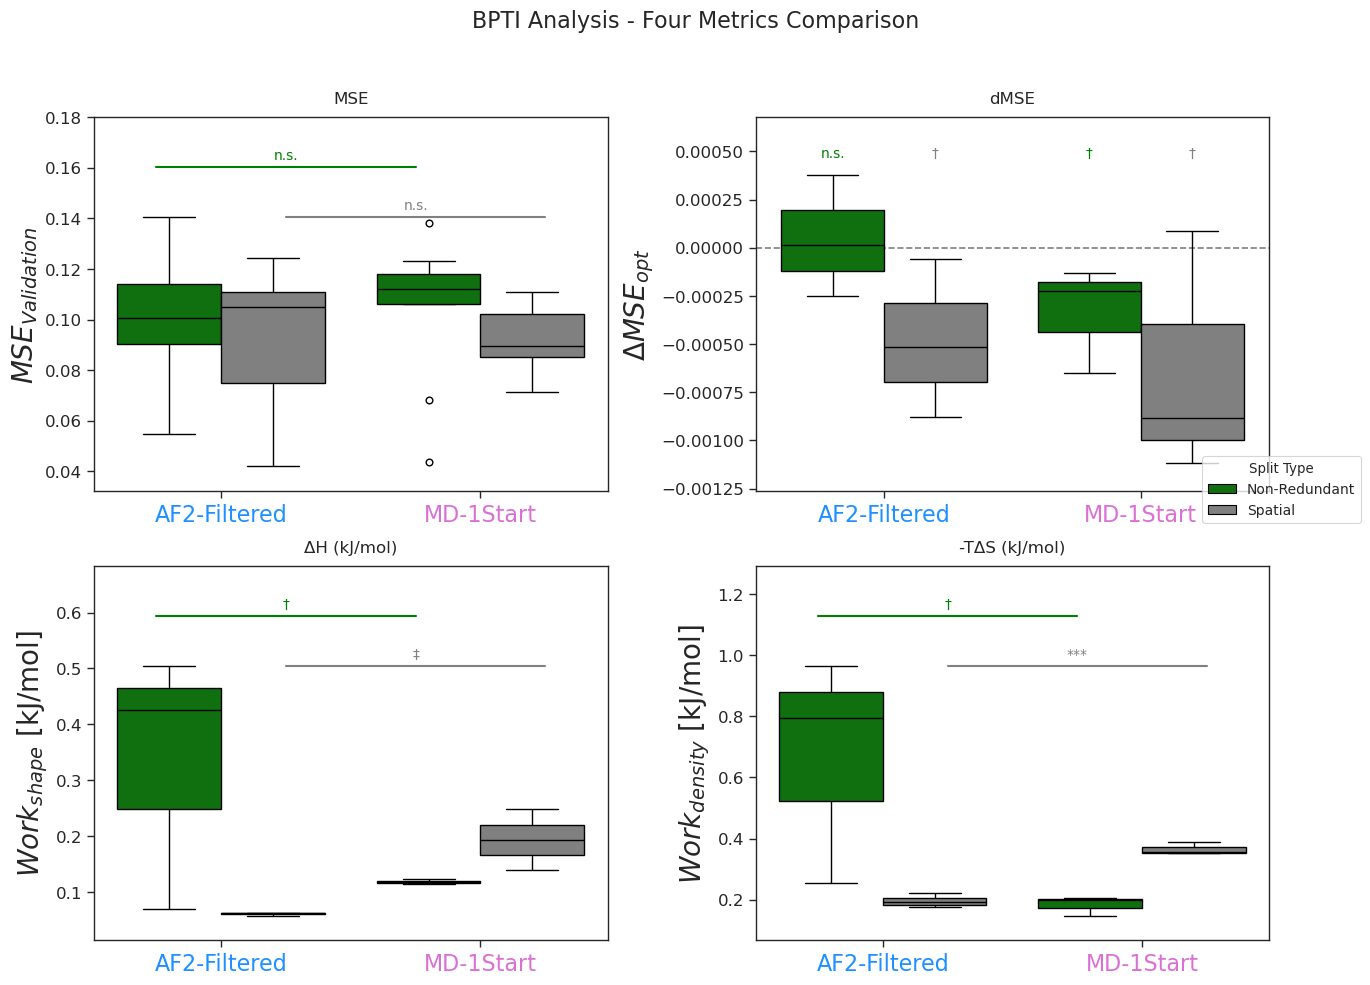

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Set style
sns.set_style("ticks")

def perform_ttest(data, ensemble1, ensemble2, split_type, y_metric):
    """
    Perform t-test between two ensembles for a given split type, properly handling NaN values.
    """
    group1 = data[(data['ensemble'] == ensemble1) &
                  (data['split_type'] == split_type)][y_metric].dropna()
    group2 = data[(data['ensemble'] == ensemble2) &
                  (data['split_type'] == split_type)][y_metric].dropna()
    
    if len(group1) > 0 and len(group2) > 0:
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split_type} split type")
        print(f"Group 1 size: {len(group1)}, Group 2 size: {len(group2)}")
        return float('nan'), float('nan')

def perform_one_sample_ttest(data, ensemble, split, y_metric):
    """
    Perform one-sample t-test against 0 for a given ensemble and split.
    """
    group = data[(data['ensemble'] == ensemble) &
                 (data['split_name'] == split)][y_metric].dropna()
    
    if len(group) > 0:
        t_stat, p_val = stats.ttest_1samp(group, 0)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split} split for {ensemble}")
        print(f"Group size: {len(group)}")
        return float('nan'), float('nan')
def p_to_stars(p_val):
    """Convert p-value to significance stars."""
    if pd.isna(p_val):
        return 'n.s.'
    elif p_val < 0.0001:
        return '****'
    elif p_val < 0.001:
        return '***'
    elif p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    elif p_val < 0.1:
        return '‡'  # Unicode double dagger (U+2021)
    elif p_val < 0.25:
        return '†'  # Unicode single dagger (U+2020)
    else:
        return 'n.s.'
# Create the main figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("BPTI Analysis - Four Metrics Comparison", fontsize=16, y=0.98)

# Define metrics and titles for each subplot
metrics_info = [
    {"metric": "mse", "data": "fit_val_df", "title": "MSE", "row": 0, "col": 0},
    {"metric": "dMSE", "data": "dMSE_energy_df", "title": "dMSE", "row": 0, "col": 1},
    {"metric": "delta_H_opt_kj", "data": "dMSE_energy_df", "title": "ΔH (kJ/mol)", "row": 1, "col": 0},
    {"metric": "-Tdelta_S_opt_kj", "data": "dMSE_energy_df", "title": "-TΔS (kJ/mol)", "row": 1, "col": 1}
]

# Plot each metric
for info in metrics_info:
    y_metric = info["metric"]
    ax = axes[info["row"], info["col"]]
    
    # Select appropriate data source
    if info["data"] == "fit_val_df":
        data = fit_val_df
        # Filter data for first plot
        data = data[data["split_type"].isin(["R3", "Sp"])]
        data = data[data["ensemble"].isin(full_dataset_order)]
    else:
        data = dMSE_energy_df
    
    # Create box plot
    sns.boxplot(data=data,
                x='ensemble',
                y=y_metric,
                hue='split_name',
                order=ensemble_order,
                hue_order=split_name_dataset_order,
                ax=ax,
                palette=split_name_dataset_colours)
    
    # Get plot limits
    y_max = data[y_metric].max()
    y_min = data[y_metric].min()
    y_range = y_max - y_min
    
    # Add title
    ax.set_title(f"{info['title']}", fontsize=12, pad=10)
    
    # Handle different annotation styles based on metric
    if y_metric == "dMSE":
        # One-sample t-tests for dMSE
        n_ensembles = len(ensemble_order)
        hue_offset = 0.2
        
        for ensemble in ensemble_order:
            for split in split_name_dataset_order:
                ensemble_idx = ensemble_order.index(ensemble)
                split_idx = split_name_dataset_order.index(split)
                x_pos = ensemble_idx + (-hue_offset if split_idx == 0 else hue_offset)
                
                t_stat, p_val = perform_one_sample_ttest(data, ensemble, split, y_metric)
                stars = p_to_stars(p_val)
                y_pos = y_max + 0.05 * y_range
                
                ax.text(x_pos, y_pos, stars,
                       ha='center', va='bottom', fontsize=10,
                       color=split_name_dataset_colours[split])
    else:
        # Two-sample t-tests for other metrics
        box_positions = {'Sp': 0.25, 'R3': -0.25}
        split_order = ["Sp", "R3"]
        spacing_factor = 0.2
        
        for idx, split in enumerate(split_order):
            if info["data"] == "fit_val_df":
                t_stat, p_val = perform_ttest(data, ensemble_order[0], ensemble_order[1], split, y_metric)
            else:
                # For dMSE_energy_df, need to map split names properly
                split_type_map = {'Sp': 'Sp', 'R3': 'R3'}  # Adjust as needed
                t_stat, p_val = perform_ttest(data, ensemble_order[0], ensemble_order[1], 
                                            split_type_map.get(split, split), y_metric)
            
            base_height = y_max + (idx * spacing_factor) * y_range
            
            # Add significance bar
            ax.plot([box_positions[split], 1 + box_positions[split]],
                   [base_height, base_height], '-',
                   color=split_type_dataset_colours[split], linewidth=1.5)
            
            stars = p_to_stars(p_val)
            ax.text(0.5 + box_positions[split], base_height + 0.02 * y_range, stars,
                   ha='center', va='bottom', fontsize=10,
                   color=split_type_dataset_colours[split])
    
    # Customize each subplot
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.set_ylabel(metric_axis_mapping.get(y_metric, y_metric))
    ax.set_xlabel('')
    
    # Set x-tick labels with colors
    ax.set_xticks(range(len(ensemble_order)))
    labels = ax.set_xticklabels(ensemble_order)
    for idx, label in enumerate(labels):
        label.set_color(full_dataset_colours[ensemble_order[idx]])
    
    # Remove individual legends (we'll add a shared one)
    if ax.get_legend():
        ax.get_legend().remove()
    
    # Adjust y-axis limits
    if y_metric == "dMSE":
        ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.2 * y_range)
    else:
        ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.4 * y_range)

# Create a shared legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, title='Split Type', loc='center right', 
           bbox_to_anchor=(0.98, 0.5), fontsize=10)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.92, 0.95])
plt.show()

Metric: mse, Split: Sp, p-val: 0.9750731894710922
Metric: mse, Split: R3, p-val: 0.7648877252707096
Metric: dMSE, Ensemble: AF2-Filtered, Split: Non-Redundant, p-val: 0.8241706048335771
Metric: dMSE, Ensemble: AF2-Filtered, Split: Spatial, p-val: 0.1771415175519328
Metric: dMSE, Ensemble: MD-1Start, Split: Non-Redundant, p-val: 0.16995834719379466
Metric: dMSE, Ensemble: MD-1Start, Split: Spatial, p-val: 0.22575587866645402
Metric: delta_H_opt_kj, Split: Sp, p-val: 0.051674142390083416
Metric: delta_H_opt_kj, Split: R3, p-val: 0.2492194328869912
Metric: -Tdelta_S_opt_kj, Split: Sp, p-val: 0.0006779870983414669
Metric: -Tdelta_S_opt_kj, Split: R3, p-val: 0.15026955966161173


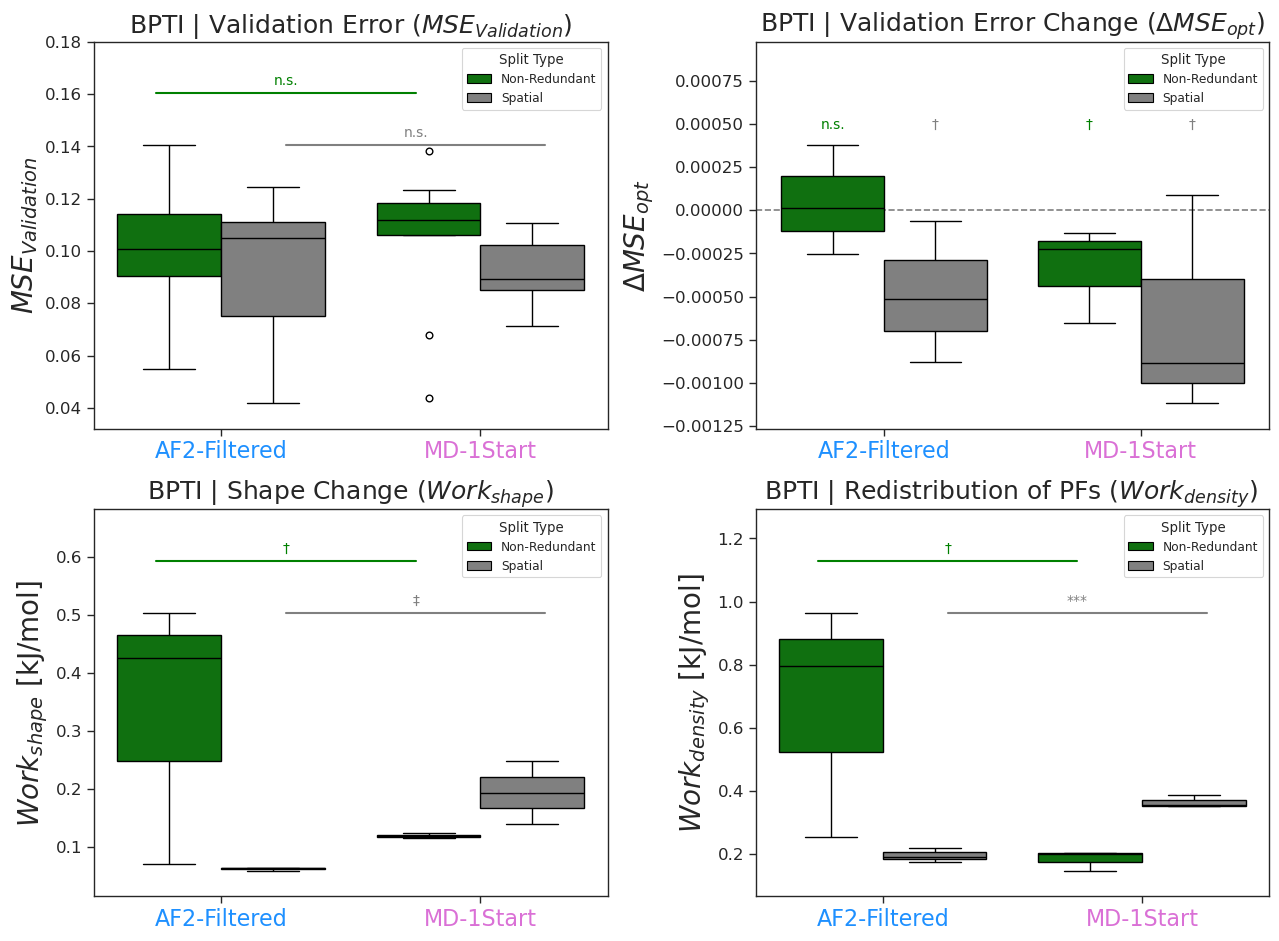

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd

# Set style
sns.set_style("ticks")

def perform_ttest(data, ensemble1, ensemble2, split_type, y_metric):
    """
    Perform t-test between two ensembles for a given split type, properly handling NaN values.
    """
    group1 = data[(data['ensemble'] == ensemble1) &
                  (data['split_type'] == split_type)][y_metric].dropna()
    group2 = data[(data['ensemble'] == ensemble2) &
                  (data['split_type'] == split_type)][y_metric].dropna()
    
    if len(group1) > 0 and len(group2) > 0:
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split_type} split type")
        print(f"Group 1 size: {len(group1)}, Group 2 size: {len(group2)}")
        return float('nan'), float('nan')

def perform_one_sample_ttest(data, ensemble, split, y_metric):
    """
    Perform one-sample t-test against 0 for a given ensemble and split.
    """
    group = data[(data['ensemble'] == ensemble) &
                 (data['split_name'] == split)][y_metric].dropna()
    
    if len(group) > 0:
        t_stat, p_val = stats.ttest_1samp(group, 0)
        return t_stat, p_val
    else:
        print(f"Warning: Insufficient data for t-test in {split} split for {ensemble}")
        print(f"Group size: {len(group)}")
        return float('nan'), float('nan')
    
def p_to_stars(p_val):
    """Convert p-value to significance stars."""
    if pd.isna(p_val):
        return 'n.s.'
    elif p_val < 0.0001:
        return '****'
    elif p_val < 0.001:
        return '***'
    elif p_val < 0.01:
        return '**'
    elif p_val < 0.05:
        return '*'
    elif p_val < 0.1:
        return '‡'  # Unicode double dagger (U+2021)
    elif p_val < 0.25:
        return '†'  # Unicode single dagger (U+2020)
    else:
        return 'n.s.'

# Create the main figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# fig.suptitle("BPTI Analysis - Four Metrics Comparison", fontsize=16, y=0.98)

# Define metrics and data sources for each subplot
metrics_info = [
    {"metric": "mse", "data": "fit_val_df", "row": 0, "col": 0},
    {"metric": "dMSE", "data": "dMSE_energy_df", "row": 0, "col": 1},
    {"metric": "delta_H_opt_kj", "data": "dMSE_energy_df", "row": 1, "col": 0},
    {"metric": "-Tdelta_S_opt_kj", "data": "dMSE_energy_df", "row": 1, "col": 1}
]

stats_texts = {}

# Plot each metric
for info in metrics_info:
    y_metric = info["metric"]
    ax = axes[info["row"], info["col"]]
    
    # Select appropriate data source
    if info["data"] == "fit_val_df":
        data = fit_val_df
        # Filter data for first plot
        data = data[data["split_type"].isin(["R3", "Sp"])]
        data = data[data["ensemble"].isin(full_dataset_order)]
    else:
        data = dMSE_energy_df
    
    # Create box plot
    sns.boxplot(data=data,
                x='ensemble',
                y=y_metric,
                hue='split_name',
                order=ensemble_order,
                hue_order=split_name_dataset_order,
                ax=ax,
                palette=split_name_dataset_colours)
    
    # Get plot limits
    y_max = data[y_metric].max()
    y_min = data[y_metric].min()
    y_range = y_max - y_min
    
    # Add title using metric_name_mapping
    metric_title = metric_name_mapping.get(y_metric, y_metric)
    ax.set_title(f"BPTI | {metric_title}")
    
    # Handle different annotation styles based on metric
    if y_metric == "dMSE":
        # One-sample t-tests for dMSE
        n_ensembles = len(ensemble_order)
        hue_offset = 0.2
        
        stats_texts[y_metric] = {}
        
        for ensemble in ensemble_order:
            stats_texts[y_metric][ensemble] = {}
            for split in split_name_dataset_order:
                ensemble_idx = ensemble_order.index(ensemble)
                split_idx = split_name_dataset_order.index(split)
                x_pos = ensemble_idx + (-hue_offset if split_idx == 0 else hue_offset)
                
                t_stat, p_val = perform_one_sample_ttest(data, ensemble, split, y_metric)
                stars = p_to_stars(p_val)
                y_pos = y_max + 0.05 * y_range
                print(f"Metric: {y_metric}, Ensemble: {ensemble}, Split: {split}, p-val: {p_val}")
            
                ax.text(x_pos, y_pos, stars,
                       ha='center', va='bottom', fontsize=10,
                       color=split_name_dataset_colours[split])
                
    else:
        # Two-sample t-tests for other metrics
        box_positions = {'Sp': 0.25, 'R3': -0.25}
        split_order = ["Sp", "R3"]
        spacing_factor = 0.2
        
        stats_texts[y_metric] = {}
        
        for idx, split in enumerate(split_order):
            stats_texts[y_metric][split] = {}
            if info["data"] == "fit_val_df":
                t_stat, p_val = perform_ttest(data, ensemble_order[0], ensemble_order[1], split, y_metric)
            else:
                # For dMSE_energy_df, need to map split names properly
                split_type_map = {'Sp': 'Sp', 'R3': 'R3'}  # Adjust as needed
                t_stat, p_val = perform_ttest(data, ensemble_order[0], ensemble_order[1], 
                                            split_type_map.get(split, split), y_metric)
            
            base_height = y_max + (idx * spacing_factor) * y_range
            
            # Add significance bar
            ax.plot([box_positions[split], 1 + box_positions[split]],
                   [base_height, base_height], '-',
                   color=split_type_dataset_colours[split], linewidth=1.5)
            stars = p_to_stars(p_val)
            print(f"Metric: {y_metric}, Split: {split}, p-val: {p_val}")
            ax.text(0.5 + box_positions[split], base_height + 0.02 * y_range, stars,
                   ha='center', va='bottom', fontsize=10,
                   color=split_type_dataset_colours[split])
            
    
    # Customize each subplot
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax.set_ylabel(metric_axis_mapping.get(y_metric, y_metric))
    ax.set_xlabel('')
    ax.legend(title='Split Type', loc='upper right')
    # Set x-tick labels with colors
    ax.set_xticks(range(len(ensemble_order)))
    labels = ax.set_xticklabels(ensemble_order)
    for idx, label in enumerate(labels):
        label.set_color(full_dataset_colours[ensemble_order[idx]])
    
    # Remove individual legends (we'll add a shared one)
    # if ax.get_legend():
    #     ax.get_legend().remove()
    
    # Adjust y-axis limits
    if y_metric == "dMSE":
        ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.4 * y_range)

    else:
        ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.4 * y_range)

# Create a shared legend
handles, labels = axes[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, title='Split Type', loc='center right', 
#            bbox_to_anchor=(0.55, 0.48), fontsize=10)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.92, 0.95])
plt.show()


In [93]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

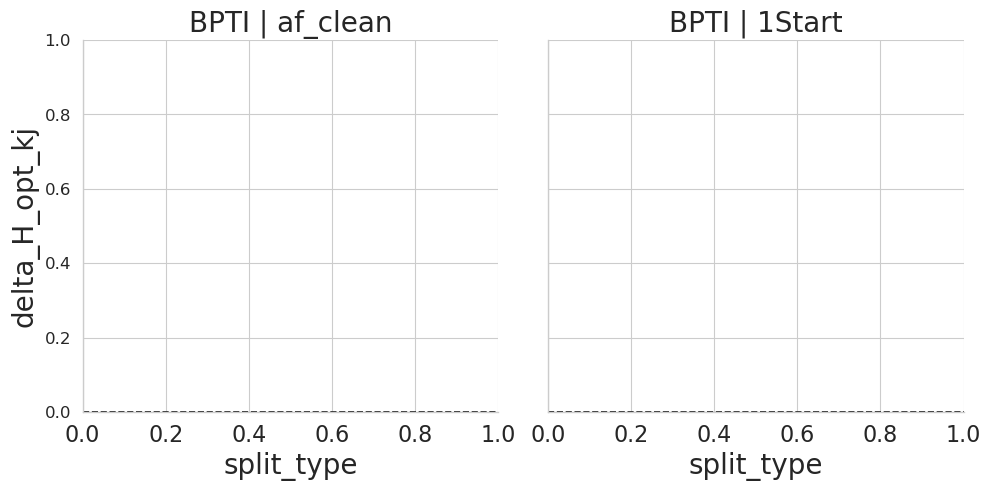

In [ ]:



import seaborn as sns
import matplotlib.pyplot as plt
# Set context and style
# sns.set_context("talk")
sns.set_style("whitegrid")
# # Create a custom palette
_dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad"]#, "af_conftop", "af_confbottom", "af_conf0.0", "af_conf0.1", "af_conf0.2", "af_conf0.3", "af_conf0.4", "af_conf0.5", "af_conf0.6", "af_conf0.7", "af_conf0.8", "af_conf0.9"]
# _dataset_order = ["af_dirty", "af_clean", "1Start", "10Start", "TFES"]
_dataset_order = ["af_clean", "1Start"]

_dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin([ "R3", "Sp"])]

# include only the _dataset_order
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# Create the FacetGrid
# Map the boxplot to the FacetGrid
g = sns.FacetGrid(_dMSE_energy_df, row="protein", col="ensemble", height=5, aspect=1, sharey='row', sharex='row', row_order=["BPTI"], col_order=_dataset_order)
g.map_dataframe(sns.boxplot, x="split_type", y="delta_H_opt_kj", hue="split_type", palette={"R3": "green", "Sp": "grey"})
# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}")#, fontsize=16, fontweight="bold")
# g.set_xlabels("energy_difference", fontsize=14)
g.set_ylabels("delta_H_opt_kj")#, fontsize=14)
# # Rotate x-tick labels
# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # Adjust subplot spacing
# g.tight_layout()
# Add legend
# g.set(yscale="log")

# Add a line at y = 0
for ax in g.axes.flat:
    ax.axhline(y=0, color='black', linestyle='--')

# g.add_legend(title="split type")#, fontsize=12)
# Show the plot
# g.set(ylim=(-3, 0))
plt.show()

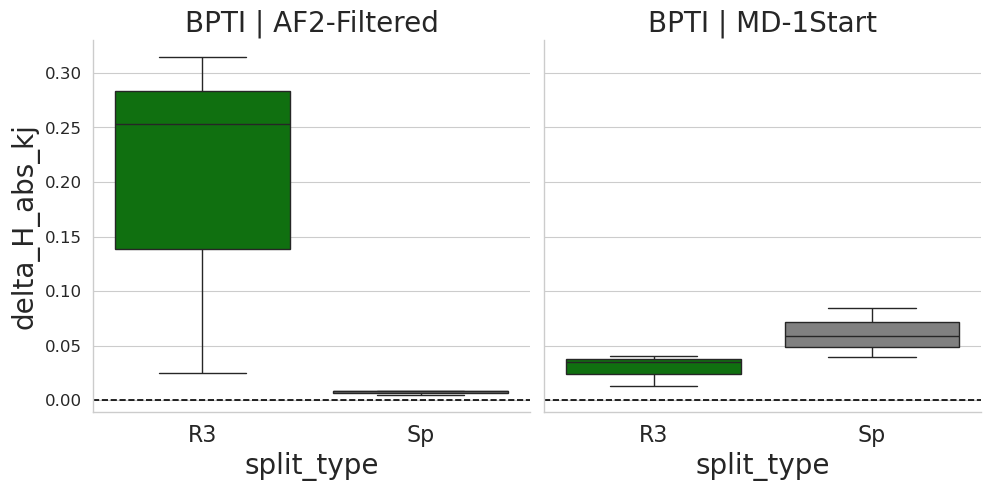

In [ ]:



import seaborn as sns
import matplotlib.pyplot as plt
# Set context and style
# sns.set_context("talk")
sns.set_style("whitegrid")
# # Create a custom palette
_dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad"]#, "af_conftop", "af_confbottom", "af_conf0.0", "af_conf0.1", "af_conf0.2", "af_conf0.3", "af_conf0.4", "af_conf0.5", "af_conf0.6", "af_conf0.7", "af_conf0.8", "af_conf0.9"]
# _dataset_order = ["af_dirty", "af_clean", "1Start", "10Start", "TFES"]

_dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin([ "R3", "Sp"])]

# include only the _dataset_order
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(full_dataset_order)]

# Create the FacetGrid
# Map the boxplot to the FacetGrid
g = sns.FacetGrid(_dMSE_energy_df, row="protein", col="ensemble", height=5, aspect=1, sharey='row', sharex='row', row_order=["BPTI"], col_order=full_dataset_order)
g.map_dataframe(sns.boxplot, x="split_type", y="delta_H_abs_kj", hue="split_type", palette={"R3": "green", "Sp": "grey"})
# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}")#, fontsize=16, fontweight="bold")
# g.set_xlabels("energy_difference", fontsize=14)
g.set_ylabels("delta_H_abs_kj")#, fontsize=14)
# # Rotate x-tick labels
# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # Adjust subplot spacing
# g.tight_layout()
# Add legend
# g.set(yscale="log")

# Add a line at y = 0
for ax in g.axes.flat:
    ax.axhline(y=0, color='black', linestyle='--')

# g.add_legend(title="split type")#, fontsize=12)
# Show the plot
# g.set(ylim=(-3, 0))
plt.show()

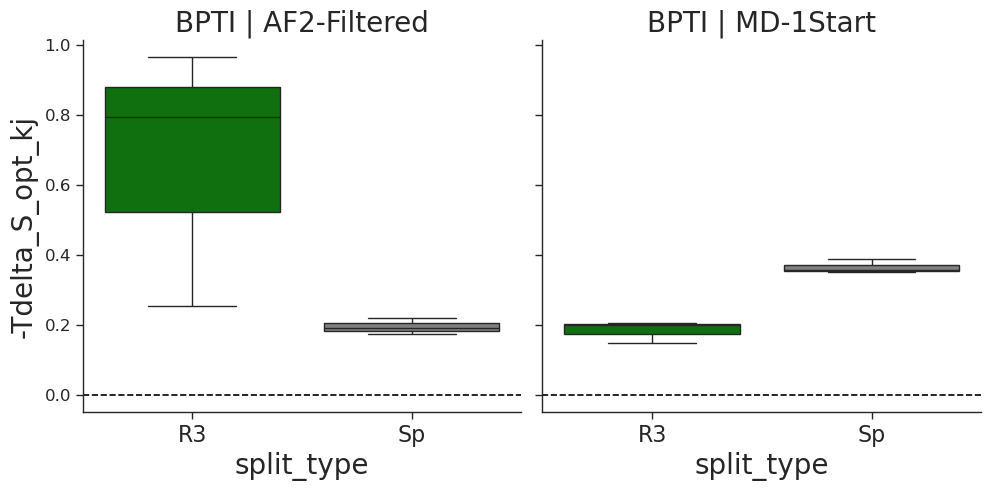

In [ ]:



import seaborn as sns
import matplotlib.pyplot as plt
# Set context and style
# sns.set_context("talk")
sns.set_style("ticks")
# # Create a custom palette
_dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad"]#, "af_conftop", "af_confbottom", "af_conf0.0", "af_conf0.1", "af_conf0.2", "af_conf0.3", "af_conf0.4", "af_conf0.5", "af_conf0.6", "af_conf0.7", "af_conf0.8", "af_conf0.9"]
# _dataset_order = ["af_dirty", "af_clean", "1Start", "10Start", "TFES"]
_dataset_order = ["af_clean", "1Start"]

_dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin([ "R3", "Sp"])]

# include only the _dataset_order
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(full_dataset_order)]

# Create the FacetGrid
# Map the boxplot to the FacetGrid
g = sns.FacetGrid(_dMSE_energy_df, row="protein", col="ensemble", height=5, aspect=1, sharey='row', sharex='row', row_order=["BPTI"], col_order=full_dataset_order)
g.map_dataframe(sns.boxplot, x="split_type", y="-Tdelta_S_opt_kj", hue="split_type", palette={"R3": "green", "Sp": "grey"})
# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=20)#, fontweight="bold")
# g.set_xlabels("energy_difference", fontsize=14)
g.set_ylabels("-Tdelta_S_opt_kj")#, fontsize=14)
# # Rotate x-tick labels
# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # Adjust subplot spacing
# g.tight_layout()
# Add legend
# g.set(yscale="log")

# Add a line at y = 0
for ax in g.axes.flat:
    ax.axhline(y=0, color='black', linestyle='--')

# g.add_legend(title="split type")#, fontsize=12)
# Show the plot
# g.set(ylim=(-3, 0))
plt.show()

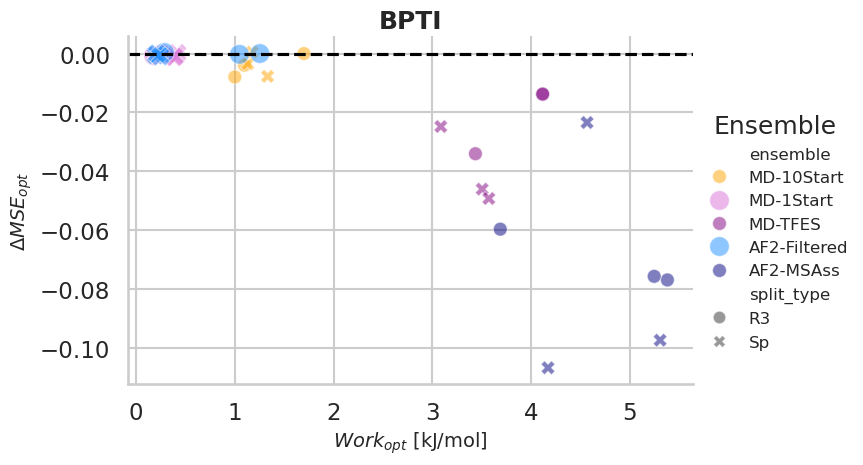

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set context and style
sns.set_context("talk")
sns.set_style("whitegrid")

# Define the custom palette and order
_dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]
_dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad"]
_dataset_order = ["af_dirty", "af_clean", "1Start", "10Start", "TFES"]

_dataset_colours = {
    "af_dirty": "green",
    "af_clean": "orange",
    "MD_Good": "red",
    "MD_Bad": "blue",
    "MD_Good+Bad": "purple",
    "1Start": "red",
    "10Start": "blue",
    "TFES": "purple"
}


# Define custom sizes for each dataset
_dataset_sizes = {
    "af_dirty": 100,
    "af_clean": 200,
    "MD_Good": 100,
    "MD_Bad": 200,
    "MD_Good+Bad": 100,
    "1Start": 200,
    "10Start": 200,
    "TFES": 100
}

full_dataset_sizes = {
    "AF2-MSAss": 100,
    "AF2-Filtered": 200,
    "MD-1Start": 200,
    "MD-10Start": 100,
    "MD-TFES": 100
}



# Set context and style


# Filter the dataframe
dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
dMSE_energy_df = dMSE_energy_df[dMSE_energy_df["ensemble"].isin(full_dataset_colours)]

# Create the FacetGrid
g = sns.FacetGrid(
    dMSE_energy_df,
    row="protein",
    height=5,
    aspect=1.5,
    sharey=False,
    sharex=False,
    row_order=["BPTI"]
)

# Map the scatterplot to the FacetGrid
g.map_dataframe(
    sns.scatterplot,
    x="delta_G_opt_kj",
    y="dMSE",
    hue="ensemble",
    palette=full_dataset_colours,
    style="split_type",
    alpha=0.5,
    size="ensemble",
    sizes=full_dataset_sizes
)

# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
g.set_xlabels(metric_axis_mapping["delta_G_opt_kj"], fontsize=14)
g.set_ylabels(metric_axis_mapping["dMSE"], fontsize=14)

# Adjust subplot spacing
g.tight_layout()

# Add horizontal line at y=0
for ax in g.axes.flat:
    ax.axhline(y=0, color='black', linestyle='--')

# # Set y-axis limits
# g.set(ylim=(-0.11, 0.06))

# Add legend with updated title
g.add_legend(title="Ensemble", fontsize=12)

# Show the plot
plt.show()

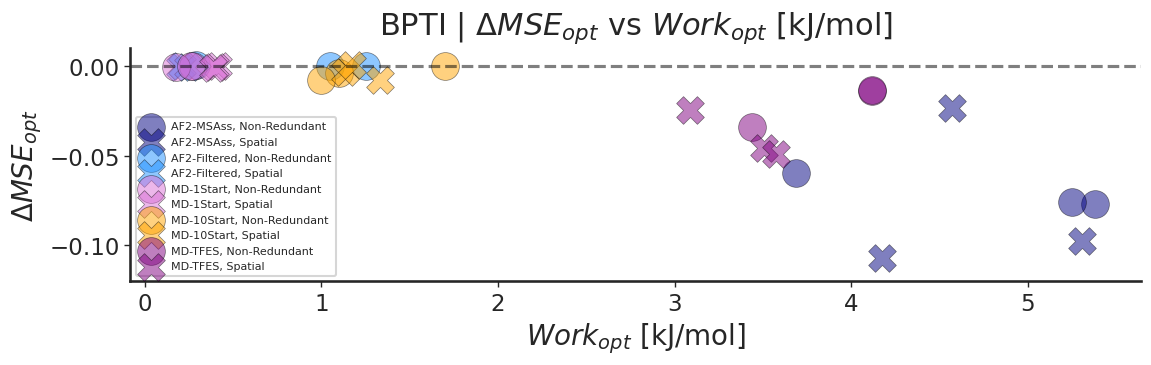

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set publication-ready style
sns.set_style("ticks")

# Filter the dataframe
dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
dMSE_energy_df = dMSE_energy_df[dMSE_energy_df["ensemble"].isin(full_dataset_colours.keys())]

# Create figure with specific size for publication
fig, ax = plt.subplots(figsize=(12,4))

# Create scatter plot with publication-ready formatting
for ensemble in full_dataset_colours.keys():
    for split, marker in {'Non-Redundant': 'o', 'Spatial': 'X'}.items():
        # Filter data for this ensemble and split
        subset = dMSE_energy_df[(dMSE_energy_df['ensemble'] == ensemble) & 
                              (dMSE_energy_df['split_name'] == split)]
        
        # Plot with appropriate styling
        ax.scatter(subset['delta_G_opt_kj'], subset['dMSE'],
                  color=full_dataset_colours[ensemble],
                  marker=marker,
                  s=400,
                  alpha=0.5,
                  label=f"{ensemble}, {split}",
                  edgecolor='k',
                  linewidth=0.5)

# add title
metric_name1 = metric_axis_mapping.get("dMSE", 'Unknown Metric')
metric_name2 = metric_axis_mapping.get("delta_G_opt_kj", 'Unknown Metric')
protein_name = "BPTI"  # Replace with actual protein name if available
plt.title(f"{protein_name} | {metric_name1} vs {metric_name2}", fontsize=22, pad=10)
# 
# Add horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Format axes for publication
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(direction='out', length=4, width=1)

# Set labels using standardized mapping
ax.set_xlabel(metric_axis_mapping["delta_G_opt_kj"], fontsize=20)
ax.set_ylabel(metric_axis_mapping["dMSE"], fontsize=20)

# Set axis limits
ax.set_ylim((-0.12, 0.01))

# Create custom legend with both ensemble and split type represented
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(fontsize=8, frameon=True, loc='lower left')

# Finalize layout and display
plt.tight_layout()
plt.show()


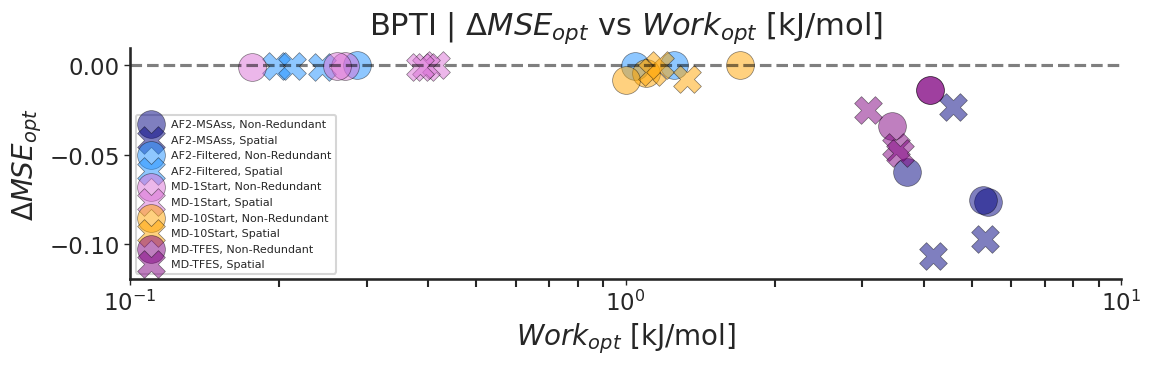

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set publication-ready style
sns.set_style("ticks")

# Filter the dataframe
dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
dMSE_energy_df = dMSE_energy_df[dMSE_energy_df["ensemble"].isin(full_dataset_colours.keys())]

# Create figure with specific size for publication
fig, ax = plt.subplots(figsize=(12,4))

# Create scatter plot with publication-ready formatting
for ensemble in full_dataset_colours.keys():
    for split, marker in {'Non-Redundant': 'o', 'Spatial': 'X'}.items():
        # Filter data for this ensemble and split
        subset = dMSE_energy_df[(dMSE_energy_df['ensemble'] == ensemble) & 
                              (dMSE_energy_df['split_name'] == split)]
        
        # Plot with appropriate styling
        ax.scatter(subset['delta_G_opt_kj'], subset['dMSE'],
                  color=full_dataset_colours[ensemble],
                  marker=marker,
                  s=400,
                  alpha=0.5,
                  label=f"{ensemble}, {split}",
                  edgecolor='k',
                  linewidth=0.5)

# add title
metric_name1 = metric_axis_mapping.get("dMSE", 'Unknown Metric')
metric_name2 = metric_axis_mapping.get("delta_G_opt_kj", 'Unknown Metric')
protein_name = "BPTI"  # Replace with actual protein name if available
plt.title(f"{protein_name} | {metric_name1} vs {metric_name2}", fontsize=22, pad=10)
# 
# Add horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Format axes for publication
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(direction='out', length=4, width=1)

# Set labels using standardized mapping
ax.set_xlabel(metric_axis_mapping["delta_G_opt_kj"], fontsize=20)
ax.set_ylabel(metric_axis_mapping["dMSE"], fontsize=20)

# Set axis limits
ax.set_ylim((-0.12, 0.01))
ax.set_xlim((1e-1, 1e1))
ax.set_xscale('log')

# Create custom legend with both ensemble and split type represented
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(fontsize=8, frameon=True, loc='lower left')


# Finalize layout and display
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

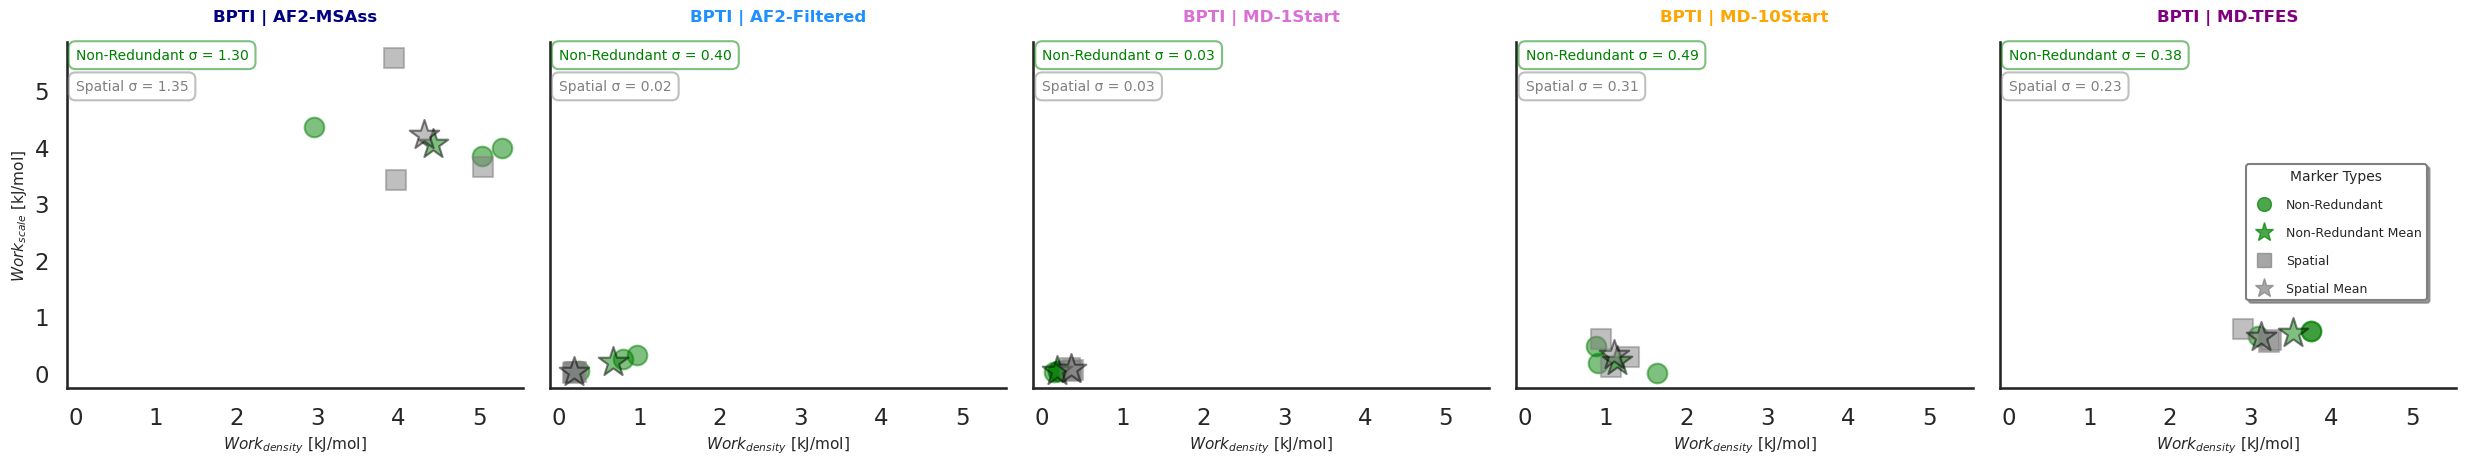

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set up the data
# Filter data for specific split types
_ensemble_pmf_df = ensemble_pmf_df[ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]

# Filter for dataset order and use the new naming system
_ensemble_pmf_df = _ensemble_pmf_df[_ensemble_pmf_df["ensemble"].isin(full_dataset_colours)]

# Force the order of the datasets using new naming
_ensemble_pmf_df["ensemble"] = pd.Categorical(_ensemble_pmf_df["ensemble"], 
                                            categories=full_dataset_colours, 
                                            ordered=True)

# Define consistent styles for split types using new color scheme
split_styles = {
    'R3': {'marker': 'o', 'color': split_type_dataset_colours['R3']},
    'Sp': {'marker': 's', 'color': split_type_dataset_colours['Sp']}
}

# Set figure style
# plt.style.use('white')
# sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_style("white")
# Create the FacetGrid
g = sns.FacetGrid(_ensemble_pmf_df, 
                  row="protein", 
                  col="ensemble", 
                  height=5, 
                  aspect=1, 
                  sharey='row', 
                  sharex='row')

# Custom scatter plot function with consistent styling
def custom_scatter(data, **kwargs):
    ax = plt.gca()
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        ax.scatter(subset["-Tdelta_S_opt_kj"], 
                  subset["delta_H_abs_kj"],
                  marker=style['marker'],
                  color=style['color'],
                  s=200,
                  label=split_name_mapping[split_type],
                  alpha=0.5)

# Function to calculate and annotate mean, median, and std dev with consistent styling
def annotate_statistics(data, **kwargs):
    ax = plt.gca()
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        if len(subset) > 0:
            # Calculate statistics
            mean_x = subset["-Tdelta_S_opt_kj"].mean()
            mean_y = subset["delta_H_abs_kj"].mean()
            
            # Calculate multivariate standard deviation
            X = np.vstack([subset["-Tdelta_S_opt_kj"], subset["delta_H_abs_kj"]]).T
            cov_matrix = np.cov(X.T)
            mult_std = np.sqrt(np.trace(cov_matrix))
            
            # Plot mean with darker version of split type color
            ax.scatter(mean_x, mean_y, 
                      marker='*', 
                      s=500,
                      color=style['color'], 
                      edgecolor='black',
                      label=f'{split_name_mapping[split_type]} Mean',
                      alpha=0.5,
                      zorder=5)
            
            # Add std dev annotation with refined styling
            ax.annotate(f'{split_name_mapping[split_type]} σ = {mult_std:.2f}',
                       xy=(0.02, 0.95 - (0.09 * list(split_styles.keys()).index(split_type))),
                       xycoords='axes fraction',
                       fontsize=10,
                       color=style['color'],
                       bbox=dict(facecolor='white',
                                edgecolor=style['color'],
                                alpha=0.5,
                                boxstyle='round,pad=0.5'))

# Apply the plotting functions
g.map_dataframe(custom_scatter)
g.map_dataframe(annotate_statistics)

# Custom function to set colored titles with refined styling
def set_colored_titles(figure):
    for ax in figure.axes:
        title = ax.get_title()
        if title:
            parts = title.split(" | ")
            if len(parts) == 2:
                protein, ensemble = parts
                new_title = f"{protein} | "
                ax.set_title(new_title + ensemble, 
                           color=full_dataset_colours[ensemble],
                           pad=15,
                           fontsize=12,
                           fontweight='bold')

# Set and style titles
g.set_titles(row_template="{row_name}", col_template="{col_name}")
set_colored_titles(g.fig)

# Add styled axis labels
g.set_axis_labels(metric_axis_mapping["-Tdelta_S_opt_kj"], 
                 metric_axis_mapping["delta_H_abs_kj"],
                 fontsize=11)

# Create refined legend elements
handles = []
labels = []

for split_type, style in split_styles.items():
    # Data points with refined styling
    handles.append(plt.Line2D([0], [0], 
                            marker=style['marker'],
                            color=style['color'],
                            linestyle='None',
                            markersize=10,
                            alpha=0.7,
                            label=split_name_mapping[split_type]))
    # Mean markers with refined styling
    handles.append(plt.Line2D([0], [0], 
                            marker='*',
                            color=style['color'],
                            linestyle='None',
                            markersize=14,
                            alpha=0.7,
                            label=f'{split_name_mapping[split_type]} Mean'))
    labels.extend([split_name_mapping[split_type], 
                  f'{split_name_mapping[split_type]} Mean'])

# Add refined legend
g.fig.legend(handles, labels, 
            loc='center right',
            bbox_to_anchor=(0.98, 0.5),
            title="Marker Types",
            title_fontsize=10,
            fontsize=9,
            frameon=True,
            edgecolor='gray',
            fancybox=True,
            shadow=True,
            # borderpad=1,
            labelspacing=1.2)

# Final layout adjustments
plt.tight_layout()
# g.fig.subplots_adjust(right=0.85)  # Make room for legend

plt.show()

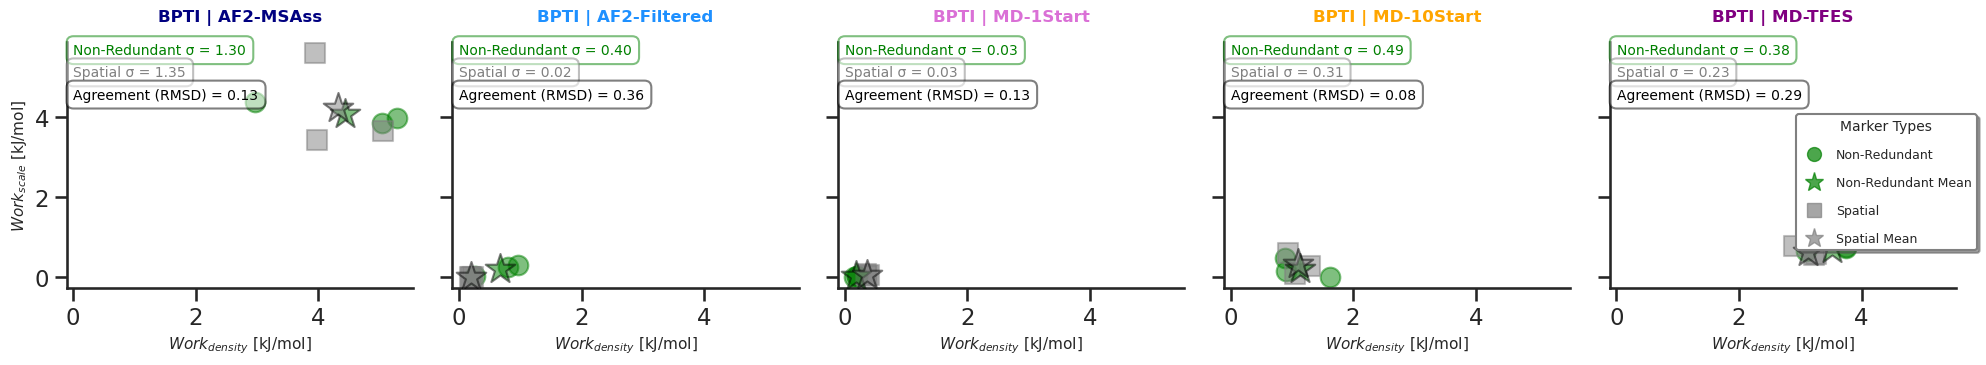

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set up the data
# Filter data for specific split types
_ensemble_pmf_df = ensemble_pmf_df[ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]

# Filter for dataset order and use the new naming system
_ensemble_pmf_df = _ensemble_pmf_df[_ensemble_pmf_df["ensemble"].isin(full_dataset_colours)]

# Force the order of the datasets using new naming
_ensemble_pmf_df["ensemble"] = pd.Categorical(_ensemble_pmf_df["ensemble"], 
                                            categories=full_dataset_colours, 
                                            ordered=True)

# Define consistent styles for split types using new color scheme
split_styles = {
    'R3': {'marker': 'o', 'color': split_type_dataset_colours['R3']},
    'Sp': {'marker': 's', 'color': split_type_dataset_colours['Sp']}
}

# Set figure style
# plt.style.use('white')
# sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_style("ticks")
# Create the FacetGrid
g = sns.FacetGrid(_ensemble_pmf_df, 
                  row="protein", 
                  col="ensemble", 
                  height=4, 
                  aspect=1, 
                  sharey='row', 
                  sharex='row')

# Custom scatter plot function with consistent styling
def custom_scatter(data, **kwargs):
    ax = plt.gca()
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        ax.scatter(subset["-Tdelta_S_opt_kj"], 
                  subset["delta_H_abs_kj"],
                  marker=style['marker'],
                  color=style['color'],
                  s=200,
                  label=split_name_mapping[split_type],
                  alpha=0.5)

# Function to calculate and annotate mean, median, and std dev with consistent styling
def annotate_statistics(data, **kwargs):
    ax = plt.gca()
    means = {}  # Store means for MSD calculation
    
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        if len(subset) > 0:
            # Calculate statistics
            mean_x = subset["-Tdelta_S_opt_kj"].mean()
            mean_y = subset["delta_H_abs_kj"].mean()
            means[split_type] = np.array([mean_x, mean_y])
            
            # Calculate multivariate standard deviation
            X = np.vstack([subset["-Tdelta_S_opt_kj"], subset["delta_H_abs_kj"]]).T
            cov_matrix = np.cov(X.T)
            mult_std = np.sqrt(np.trace(cov_matrix))
            
            # Plot mean with darker version of split type color
            ax.scatter(mean_x, mean_y, 
                      marker='*', 
                      s=500,
                      color=style['color'], 
                      edgecolor='black',
                      label=f'{split_name_mapping[split_type]} Mean',
                      alpha=0.5,
                      zorder=5)
            
            # Add std dev annotation with refined styling
            ax.annotate(f'{split_name_mapping[split_type]} σ = {mult_std:.2f}',
                       xy=(0.02, 0.95 - (0.09 * list(split_styles.keys()).index(split_type))),
                       xycoords='axes fraction',
                       fontsize=10,
                       color=style['color'],
                       bbox=dict(facecolor='white',
                                edgecolor=style['color'],
                                alpha=0.5,
                                boxstyle='round,pad=0.5'))
    
    # Calculate and annotate MSD between means if we have both split types
    if len(means) == 2:
        msd = np.mean((means['R3'] - means['Sp'])**2)**0.5
        ax.annotate(f'Agreement (RMSD) = {msd:.2f}',
                   xy=(0.02, 0.77),  # Position below the other annotations
                   xycoords='axes fraction',
                   fontsize=10,
                   color='black',
                   bbox=dict(facecolor='white',
                            edgecolor='black',
                            alpha=0.5,
                            boxstyle='round,pad=0.5'))

# Apply the plotting functions
g.map_dataframe(custom_scatter)
g.map_dataframe(annotate_statistics)

# Custom function to set colored titles with refined styling
def set_colored_titles(figure):
    for ax in figure.axes:
        title = ax.get_title()
        if title:
            parts = title.split(" | ")
            if len(parts) == 2:
                protein, ensemble = parts
                new_title = f"{protein} | "
                ax.set_title(new_title + ensemble, 
                           color=full_dataset_colours[ensemble],
                           pad=15,
                           fontsize=12,
                           fontweight='bold')

# Set and style titles
g.set_titles(row_template="{row_name}", col_template="{col_name}")
set_colored_titles(g.fig)

# Add styled axis labels
g.set_axis_labels(metric_axis_mapping["-Tdelta_S_opt_kj"], 
                 metric_axis_mapping["delta_H_abs_kj"],
                 fontsize=11)

# Create refined legend elements
handles = []
labels = []

for split_type, style in split_styles.items():
    # Data points with refined styling
    handles.append(plt.Line2D([0], [0], 
                            marker=style['marker'],
                            color=style['color'],
                            linestyle='None',
                            markersize=10,
                            alpha=0.7,
                            label=split_name_mapping[split_type]))
    # Mean markers with refined styling
    handles.append(plt.Line2D([0], [0], 
                            marker='*',
                            color=style['color'],
                            linestyle='None',
                            markersize=14,
                            alpha=0.7,
                            label=f'{split_name_mapping[split_type]} Mean'))
    labels.extend([split_name_mapping[split_type], 
                  f'{split_name_mapping[split_type]} Mean'])

# Add refined legend
g.fig.legend(handles, labels, 
            loc='center right',
            bbox_to_anchor=(1, 0.5),
            title="Marker Types",
            title_fontsize=10,
            fontsize=9,
            frameon=True,
            edgecolor='gray',
            fancybox=True,
            shadow=True,
            # borderpad=1,
            labelspacing=1.2)

# Final layout adjustments
plt.tight_layout()
# g.fig.subplots_adjust(right=0.85)  # Make room for legend
# set yscale to log
plt.show()

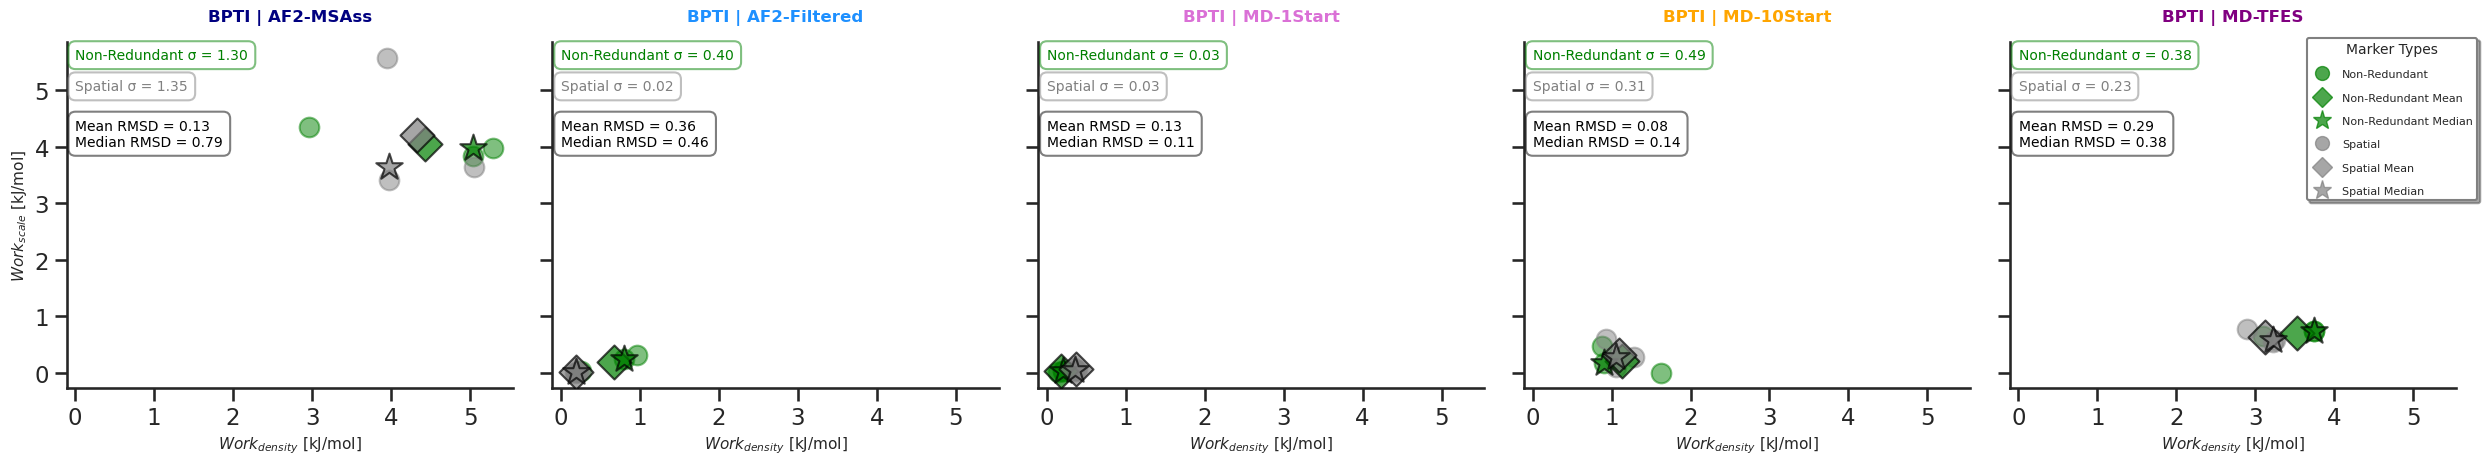

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set up the data
# Filter data for specific split types
_ensemble_pmf_df = ensemble_pmf_df[ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]

# Filter for dataset order and use the new naming system
_ensemble_pmf_df = _ensemble_pmf_df[_ensemble_pmf_df["ensemble"].isin(full_dataset_colours)]

# Force the order of the datasets using new naming
_ensemble_pmf_df["ensemble"] = pd.Categorical(_ensemble_pmf_df["ensemble"], 
                                            categories=full_dataset_colours, 
                                            ordered=True)

# Define consistent styles for split types using new color scheme
split_styles = {
    'R3': {'marker': 'o', 'color': split_type_dataset_colours['R3']},
    'Sp': {'marker': 'o', 'color': split_type_dataset_colours['Sp']}
}

# Set figure style
sns.set_style("ticks")

# Create the FacetGrid
g = sns.FacetGrid(_ensemble_pmf_df, 
                  row="protein", 
                  col="ensemble", 
                  height=5, 
                  aspect=1, 
                  sharey='row', 
                  sharex='row')

# Custom scatter plot function with consistent styling
def custom_scatter(data, **kwargs):
    ax = plt.gca()
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        ax.scatter(subset["-Tdelta_S_opt_kj"], 
                  subset["delta_H_abs_kj"],
                  marker=style['marker'],
                  color=style['color'],
                  s=200,
                  label=split_name_mapping[split_type],
                  alpha=0.5)

# Function to calculate and annotate means, medians, and stats with consistent styling
def annotate_statistics(data, **kwargs):
    ax = plt.gca()
    means = {}  # Store means for RMSD calculation
    medians = {}  # Store medians for RMSD calculation
    
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        if len(subset) > 0:
            # Calculate statistics
            mean_x = subset["-Tdelta_S_opt_kj"].mean()
            mean_y = subset["delta_H_abs_kj"].mean()
            median_x = subset["-Tdelta_S_opt_kj"].median()
            median_y = subset["delta_H_abs_kj"].median()
            
            means[split_type] = np.array([mean_x, mean_y])
            medians[split_type] = np.array([median_x, median_y])
            
            # Calculate multivariate standard deviation
            X = np.vstack([subset["-Tdelta_S_opt_kj"], subset["delta_H_abs_kj"]]).T
            cov_matrix = np.cov(X.T)
            mult_std = np.sqrt(np.trace(cov_matrix))
            
            # Plot mean with diamond marker
            ax.scatter(mean_x, mean_y, 
                      marker='D',  # Diamond for mean
                      s=300,
                      color=style['color'], 
                      edgecolor='black',
                      label=f'{split_name_mapping[split_type]} Mean',
                      alpha=0.7,
                      zorder=5)
            
            # Plot median with star marker
            ax.scatter(median_x, median_y, 
                      marker='*',  # Star for median
                      s=400,
                      color=style['color'], 
                      edgecolor='black',
                      label=f'{split_name_mapping[split_type]} Median',
                      alpha=0.7,
                      zorder=5)
            
            # Add std dev annotation with refined styling
            ax.annotate(f'{split_name_mapping[split_type]} σ = {mult_std:.2f}',
                       xy=(0.02, 0.95 - (0.09 * list(split_styles.keys()).index(split_type))),
                       xycoords='axes fraction',
                       fontsize=10,
                       color=style['color'],
                       bbox=dict(facecolor='white',
                                edgecolor=style['color'],
                                alpha=0.5,
                                boxstyle='round,pad=0.5'))
    
    # Calculate and annotate RMSD between means and medians if we have both split types
    if len(means) == 2 and len(medians) == 2:
        mean_rmsd = np.sqrt(np.mean((means['R3'] - means['Sp'])**2))
        median_rmsd = np.sqrt(np.mean((medians['R3'] - medians['Sp'])**2))
        
        # Add RMSD annotations
        ax.annotate(f'Mean RMSD = {mean_rmsd:.2f}\nMedian RMSD = {median_rmsd:.2f}',
                   xy=(0.02, 0.7),
                   xycoords='axes fraction',
                   fontsize=10,
                   color='black',
                   bbox=dict(facecolor='white',
                            edgecolor='black',
                            alpha=0.5,
                            boxstyle='round,pad=0.5'))

# Apply the plotting functions
g.map_dataframe(custom_scatter)
g.map_dataframe(annotate_statistics)

# Custom function to set colored titles with refined styling
def set_colored_titles(figure):
    for ax in figure.axes:
        title = ax.get_title()
        if title:
            parts = title.split(" | ")
            if len(parts) == 2:
                protein, ensemble = parts
                new_title = f"{protein} | "
                ax.set_title(new_title + ensemble, 
                           color=full_dataset_colours[ensemble],
                           pad=15,
                           fontsize=12,
                           fontweight='bold')

# Set and style titles
g.set_titles(row_template="{row_name}", col_template="{col_name}")
set_colored_titles(g.fig)

# Add styled axis labels
g.set_axis_labels(metric_axis_mapping["-Tdelta_S_opt_kj"], 
                 metric_axis_mapping["delta_H_abs_kj"],
                 fontsize=11)

# Create refined legend elements
handles = []
labels = []

for split_type, style in split_styles.items():
    # Data points
    handles.append(plt.Line2D([0], [0], 
                            marker=style['marker'],
                            color=style['color'],
                            linestyle='None',
                            markersize=10,
                            alpha=0.7,
                            label=split_name_mapping[split_type]))
    # Mean markers
    handles.append(plt.Line2D([0], [0], 
                            marker='D',  # Diamond for mean
                            color=style['color'],
                            linestyle='None',
                            markersize=10,
                            alpha=0.7,
                            label=f'{split_name_mapping[split_type]} Mean'))
    # Median markers
    handles.append(plt.Line2D([0], [0], 
                            marker='*',  # Star for median
                            color=style['color'],
                            linestyle='None',
                            markersize=14,
                            alpha=0.7,
                            label=f'{split_name_mapping[split_type]} Median'))
    labels.extend([
        split_name_mapping[split_type],
        f'{split_name_mapping[split_type]} Mean',
        f'{split_name_mapping[split_type]} Median'
    ])

# Add refined legend
g.fig.legend(handles, labels, 
            loc='upper right',
            bbox_to_anchor=(1, 0.9),
            title="Marker Types",
            title_fontsize=10,
            fontsize=8,
            frameon=True,
            edgecolor='gray',
            facecolor='white',
            # set transparent 
            # framealpha=0.5,
            
            fancybox=True,
            shadow=True,
            labelspacing=1.2)

# Final layout adjustments
plt.tight_layout()
plt.show()

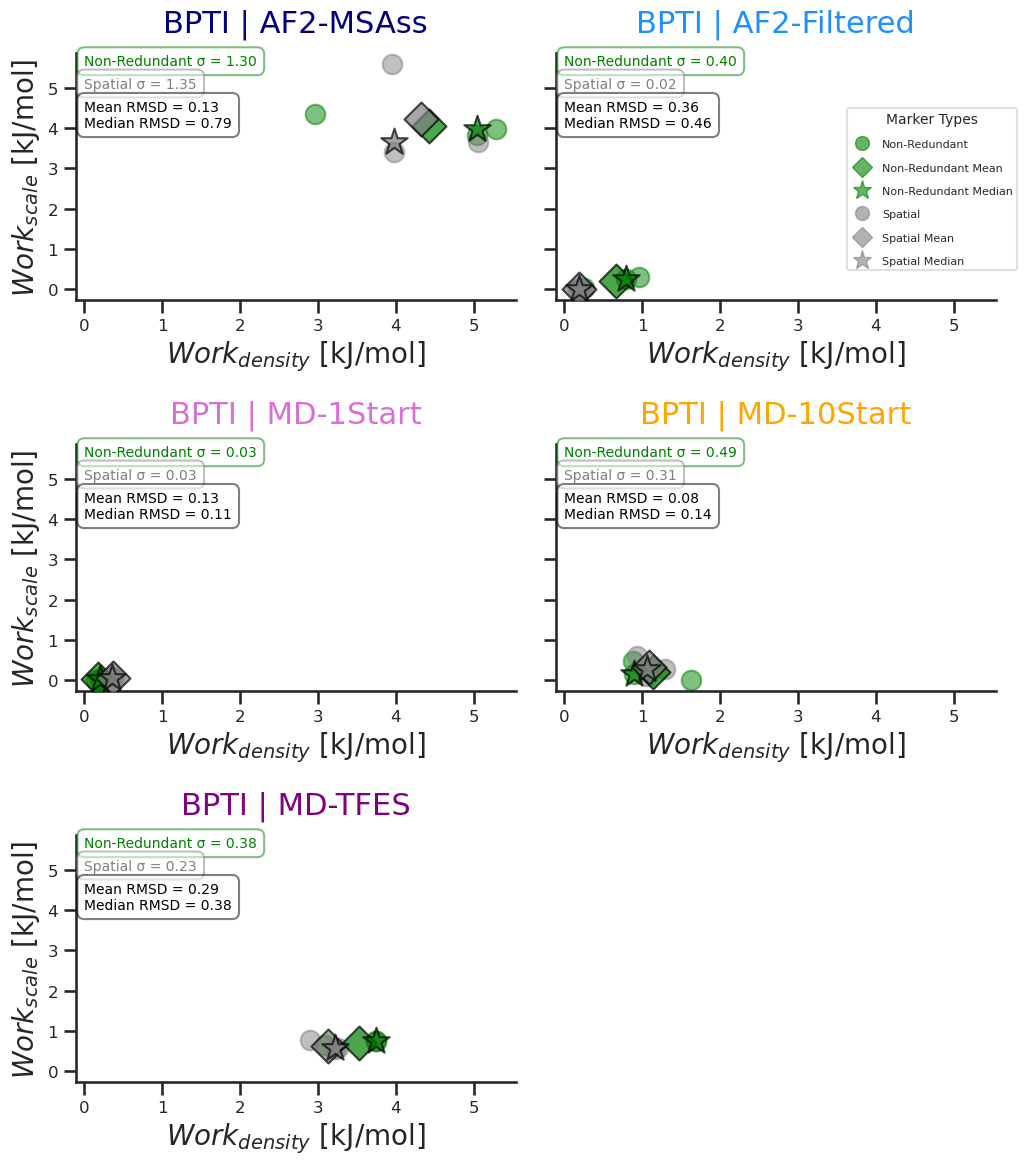

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set up the data
# Filter data for specific split types
_ensemble_pmf_df = ensemble_pmf_df[ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]

# Filter for dataset order and use the new naming system
_ensemble_pmf_df = _ensemble_pmf_df[_ensemble_pmf_df["ensemble"].isin(full_dataset_colours)]

# Force the order of the datasets using new naming
_ensemble_pmf_df["ensemble"] = pd.Categorical(_ensemble_pmf_df["ensemble"], 
                                            categories=full_dataset_colours, 
                                            ordered=True)
_ensemble_pmf_df = _ensemble_pmf_df[_ensemble_pmf_df["protein"] == "BPTI"]
# Define consistent styles for split types using new color scheme
split_styles = {
    'R3': {'marker': 'o', 'color': split_type_dataset_colours['R3']},
    'Sp': {'marker': 'o', 'color': split_type_dataset_colours['Sp']}
}

# Set figure style
sns.set_style("ticks")

# Create the FacetGrid
g = sns.FacetGrid(_ensemble_pmf_df, 
                #   row="protein",
                 col_wrap=2, 
                  col="ensemble", 
                  height=4, 
                  aspect=1.3, 
                  sharey='row', 
                  sharex='row')

# Custom scatter plot function with consistent styling
def custom_scatter(data, **kwargs):
    ax = plt.gca()
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        ax.scatter(subset["-Tdelta_S_opt_kj"], 
                  subset["delta_H_abs_kj"],
                  marker=style['marker'],
                  color=style['color'],
                  s=200,
                  label=split_name_mapping[split_type],
                  alpha=0.5)

# Function to calculate and annotate means, medians, and stats with consistent styling
def annotate_statistics(data, **kwargs):
    ax = plt.gca()
    means = {}  # Store means for RMSD calculation
    medians = {}  # Store medians for RMSD calculation
    
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        if len(subset) > 0:
            # Calculate statistics
            mean_x = subset["-Tdelta_S_opt_kj"].mean()
            mean_y = subset["delta_H_abs_kj"].mean()
            median_x = subset["-Tdelta_S_opt_kj"].median()
            median_y = subset["delta_H_abs_kj"].median()
            
            means[split_type] = np.array([mean_x, mean_y])
            medians[split_type] = np.array([median_x, median_y])
            
            # Calculate multivariate standard deviation
            X = np.vstack([subset["-Tdelta_S_opt_kj"], subset["delta_H_abs_kj"]]).T
            cov_matrix = np.cov(X.T)
            mult_std = np.sqrt(np.trace(cov_matrix))
            
            # Plot mean with diamond marker
            ax.scatter(mean_x, mean_y, 
                      marker='D',  # Diamond for mean
                      s=300,
                      color=style['color'], 
                      edgecolor='black',
                      label=f'{split_name_mapping[split_type]} Mean',
                      alpha=0.7,
                      zorder=5)
            
            # Plot median with star marker
            ax.scatter(median_x, median_y, 
                      marker='*',  # Star for median
                      s=400,
                      color=style['color'], 
                      edgecolor='black',
                      label=f'{split_name_mapping[split_type]} Median',
                      alpha=0.7,
                      zorder=5)
            
            # Add std dev annotation with refined styling
            ax.annotate(f'{split_name_mapping[split_type]} σ = {mult_std:.2f}',
                       xy=(0.02, 0.95 - (0.09 * list(split_styles.keys()).index(split_type))),
                       xycoords='axes fraction',
                       fontsize=10,
                       color=style['color'],
                       bbox=dict(facecolor='white',
                                edgecolor=style['color'],
                                alpha=0.5,
                                boxstyle='round,pad=0.5'))
    
    # Calculate and annotate RMSD between means and medians if we have both split types
    if len(means) == 2 and len(medians) == 2:
        mean_rmsd = np.sqrt(np.mean((means['R3'] - means['Sp'])**2))
        median_rmsd = np.sqrt(np.mean((medians['R3'] - medians['Sp'])**2))
        
        # Add RMSD annotations
        ax.annotate(f'Mean RMSD = {mean_rmsd:.2f}\nMedian RMSD = {median_rmsd:.2f}',
                   xy=(0.02, 0.7),
                   xycoords='axes fraction',
                   fontsize=10,
                   color='black',
                   bbox=dict(facecolor='white',
                            edgecolor='black',
                            alpha=0.5,
                            boxstyle='round,pad=0.5'))

# Apply the plotting functions
g.map_dataframe(custom_scatter)
g.map_dataframe(annotate_statistics)

# Custom function to set colored titles with refined styling
def set_colored_titles(figure):
    for ax in figure.axes:
        title = ax.get_title()
        if title:
            # The title should just be the ensemble name
            ensemble = title.strip()
            if ensemble in full_dataset_colours:
                ax.set_title(f"{protein} | {ensemble}", 
                           color=full_dataset_colours[ensemble],
                           pad=15,
                           fontsize=22,)
                        #    fontweight='bold')

# Set and style titles
g.set_titles(col_template="{col_name}")  # Use only the column name
set_colored_titles(g.fig)

# Add styled axis labels to all subplots
# g.set_axis_labels(metric_axis_mapping["-Tdelta_S_opt_kj"], 
#                  metric_axis_mapping["delta_H_abs_kj"],
#                  fontsize=20)

# Ensure axis labels are visible on all subplots
for ax in g.axes.flat:
    ax.set_xlabel(metric_axis_mapping["-Tdelta_S_opt_kj"], fontsize=20)
    ax.set_ylabel(metric_axis_mapping["delta_H_abs_kj"], fontsize=20)
    # Make tick labels more readable
    ax.tick_params(axis='both', which='major', labelsize=12)

# Create refined legend elements
handles = []
labels = []

for split_type, style in split_styles.items():
    # Data points
    handles.append(plt.Line2D([0], [0], 
                            marker=style['marker'],
                            color=style['color'],
                            linestyle='None',
                            markersize=10,
                            alpha=0.6,
                            label=split_name_mapping[split_type]))
    # Mean markers
    handles.append(plt.Line2D([0], [0], 
                            marker='D',  # Diamond for mean
                            color=style['color'],
                            linestyle='None',
                            markersize=10,
                            alpha=0.6,
                            label=f'{split_name_mapping[split_type]} Mean'))
    # Median markers
    handles.append(plt.Line2D([0], [0], 
                            marker='*',  # Star for median
                            color=style['color'],
                            linestyle='None',
                            markersize=14,
                            alpha=0.6,
                            label=f'{split_name_mapping[split_type]} Median'))
    labels.extend([
        split_name_mapping[split_type],
        f'{split_name_mapping[split_type]} Mean',
        f'{split_name_mapping[split_type]} Median'
    ])

# Add refined legend
g.fig.legend(handles, labels, 
            loc='upper right',
            bbox_to_anchor=(1, 0.9),
            title="Marker Types",
            title_fontsize=10,
            fontsize=8,
            frameon=True,
            # edgecolor='gray',
            # facecolor='white'

            # set transparent 
            framealpha=0.6,
            
            fancybox=True,
            # shadow=True,
            labelspacing=1.2)

# Final layout adjustments
plt.tight_layout()
plt.show()


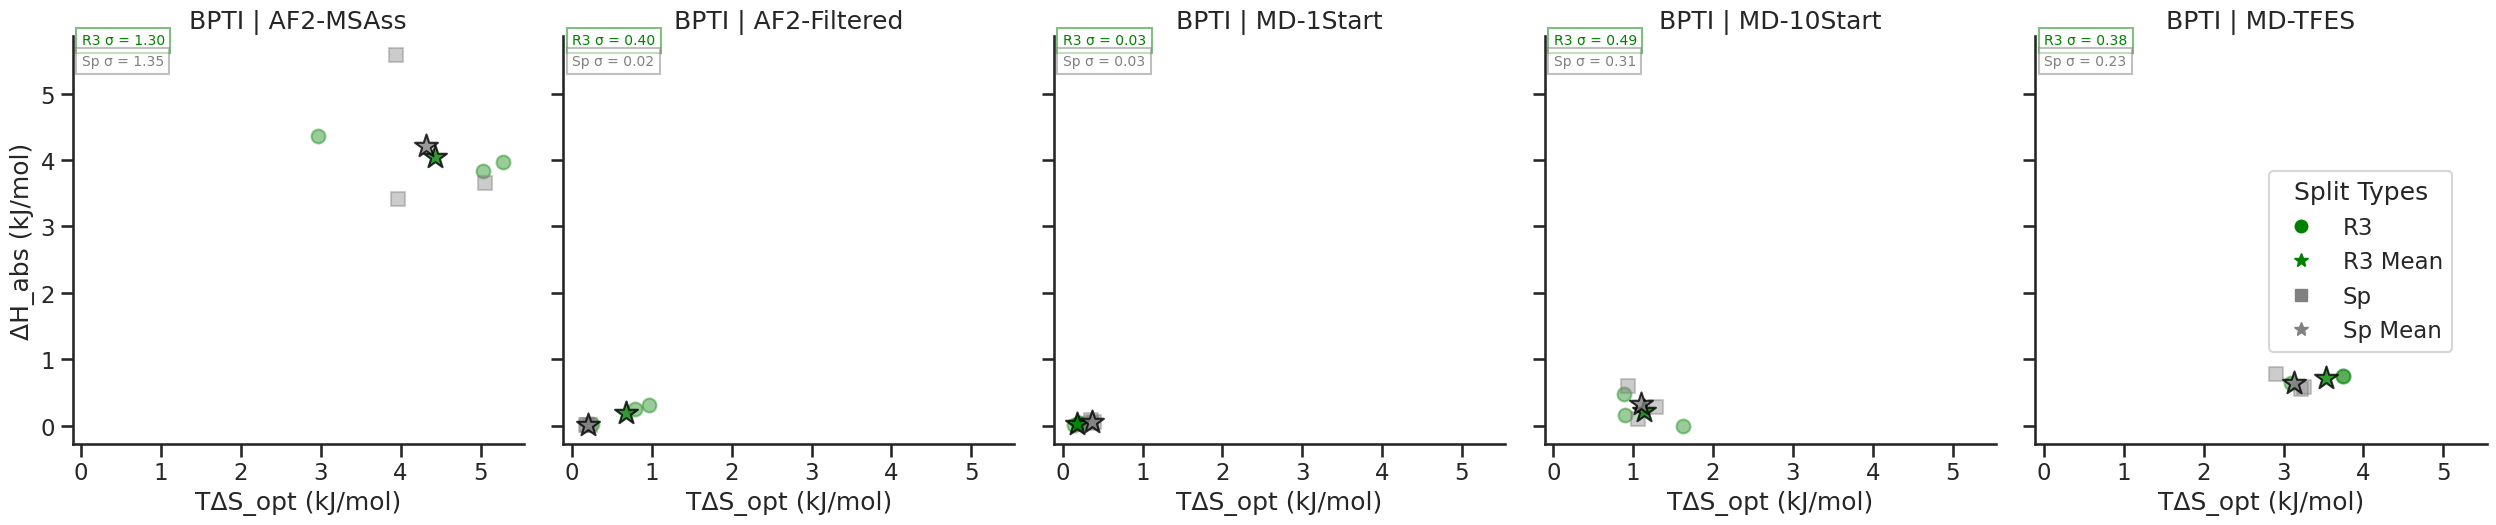

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set up the data
# Filter data for specific split types
_ensemble_pmf_df = ensemble_pmf_df[ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]
# _dataset_order = ["af_dirty", "af_clean", "1Start", "10Start", "TFES"]

# Filter for dataset order
_ensemble_pmf_df = _ensemble_pmf_df[_ensemble_pmf_df["ensemble"].isin(full_dataset_colours)]

# Force the order of the datasets
_ensemble_pmf_df["ensemble"] = pd.Categorical(_ensemble_pmf_df["ensemble"], categories=full_dataset_colours, ordered=True)

# Define consistent styles for split types
split_styles = {
    'R3': {'marker': 'o', 'color': 'Green'},  # Orange
    'Sp': {'marker': 's', 'color': 'Grey'}   # Blue
}



# Create the FacetGrid
g = sns.FacetGrid(_ensemble_pmf_df, 
                  row="protein", 
                  col="ensemble", 
                  height=5, 
                  aspect=1, 
                  sharey='row', 
                  sharex='row')

# Custom scatter plot function with consistent styling
def custom_scatter(data, **kwargs):
    ax = plt.gca()
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        ax.scatter(subset["-Tdelta_S_opt_kj"], 
                  subset["delta_H_abs_kj"],
                  marker=style['marker'],
                  color=style['color'],
                  s=100,
                #   s=subset["avg_H_opt_kj"]*10,
                  label=split_type,
                  alpha=0.4)

# Function to calculate and annotate mean, median, and std dev with consistent styling
def annotate_statistics(data, **kwargs):
    ax = plt.gca()
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        if len(subset) > 0:
            # Calculate statistics
            mean_x = subset["-Tdelta_S_opt_kj"].mean()
            mean_y = subset["delta_H_abs_kj"].mean()
            median_x = subset["-Tdelta_S_opt_kj"].median()
            median_y = subset["delta_H_abs_kj"].median()
            
            # Calculate multivariate standard deviation
            X = np.vstack([subset["-Tdelta_S_opt_kj"], subset["delta_H_abs_kj"]]).T
            cov_matrix = np.cov(X.T)
            mult_std = np.sqrt(np.trace(cov_matrix))
            
            # Plot mean with darker version of split type color
            ax.scatter(mean_x, mean_y, 
                      marker='*', 
                      s=300,
                      color=style['color'], 
                      edgecolor='black',
                      label=f'{split_type} Mean',
                      alpha=0.8,
                      zorder=5)
            
            # # Plot median with lighter version of split type color
            # ax.scatter(median_x, median_y, 
            #           marker='D', 
            #           s=100,
            #           color=style['color'], 
            #           edgecolor='black',
            #           alpha=1,
            #           label=f'{split_type} Median',
            #           zorder=5)
            
            # Add std dev annotation in the corner
            ax.annotate(f'{split_type} σ = {mult_std:.2f}', 
                       xy=(0.02, 0.98 - (0.05 * list(split_styles.keys()).index(split_type))),
                       xycoords='axes fraction',
                       fontsize=10,
                       color=style['color'],
                       bbox=dict(facecolor='white', edgecolor=style['color'], alpha=0.5))

# Apply the plotting functions
g.map_dataframe(custom_scatter)
g.map_dataframe(annotate_statistics)

# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}")
# g.set(yscale="log")

# Add axis labels
g.set_axis_labels("TΔS_opt (kJ/mol)", "ΔH_abs (kJ/mol)")

# Adjust layout
plt.subplots_adjust(top=0.95)

# Add a custom legend
handles = []
labels = []
for split_type, style in split_styles.items():
    # Add scatter plot points
    handles.append(plt.Line2D([0], [0], 
                            marker=style['marker'],
                            color=style['color'],
                            linestyle='None',
                            label=split_type))
    # Add mean markers
    handles.append(plt.Line2D([0], [0], 
                            marker='*',
                            color=style['color'],
                            # markeredgecolor='black',
                            linestyle='None',
                            markersize=10,
                            label=f'{split_type} Mean'))
    # # Add median markers
    # handles.append(plt.Line2D([0], [0], 
    #                         marker='D',
    #                         color=style['color'],
    #                         markeredgecolor='black',
    #                         linestyle='None',
    #                         alpha=0.7,
    #                         markersize=8,
    #                         label=f'{split_type} Median'))
    labels.extend([split_type, f'{split_type} Mean'])

g.fig.legend(handles, labels, 
            loc='center right', 
            bbox_to_anchor=(0.98, 0.5),
            title="Split Types")

plt.show()

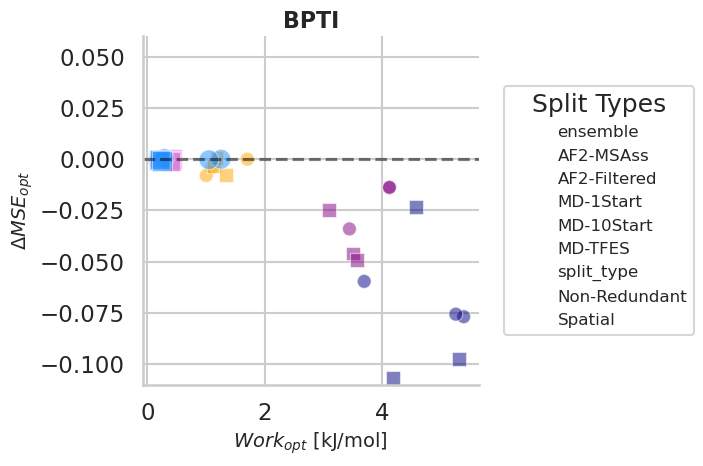

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set context and style
sns.set_context("talk")
sns.set_style("whitegrid")

# Filter the dataframe
_dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(full_dataset_colours)]

# Force categorical ordering of ensembles
_dMSE_energy_df["ensemble"] = pd.Categorical(_dMSE_energy_df["ensemble"], 
                                           categories=full_dataset_colours, 
                                           ordered=True)

# Create style mapping for split types
split_markers = {"R3": "o", "Sp": "s"}

# Create the FacetGrid
g = sns.FacetGrid(
    _dMSE_energy_df,
    row="protein",
    height=5,
    aspect=1.5,
    sharey=False,
    sharex=False,
    row_order=["BPTI"]
)

# Map the scatterplot to the FacetGrid
g.map_dataframe(
    sns.scatterplot,
    x="delta_G_opt_kj",
    y="dMSE",
    hue="ensemble",
    palette=full_dataset_colours,
    style="split_type",
    markers=split_markers,
    alpha=0.5,
    size="ensemble",
    sizes=full_dataset_sizes
)

# Custom function to set colored titles
def set_colored_titles(figure):
    for ax in figure.axes:
        title = ax.get_title()
        if title:
            # For single row, we only have the protein name
            protein = title
            # Create a colored title
            ax.set_title(protein, fontsize=16, fontweight="bold")

# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}")
set_colored_titles(g.fig)

# Set axis labels using metric mappings
g.set_xlabels(metric_axis_mapping["delta_G_opt_kj"], fontsize=14)
g.set_ylabels(metric_axis_mapping["dMSE"], fontsize=14)

# Add horizontal line at y=0
for ax in g.axes.flat:
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Set axis limits
g.set(ylim=(-0.11, 0.06))

# Add and customize legend
plt.legend(title="Split Types", fontsize=12, bbox_to_anchor=(1.05, 0.5), loc='center left')
legend = plt.gca().get_legend()
legend.set_title("Split Types", prop={'size': 12})

# Update legend labels using split name mapping
handles = legend.legendHandles
labels = [split_name_mapping.get(t.get_text(), t.get_text()) 
          for t in legend.get_texts()]

# Create new legend with updated labels
plt.legend(handles, labels, title="Split Types", 
          fontsize=12, bbox_to_anchor=(1.05, 0.5), 
          loc='center left')

# Adjust layout
plt.tight_layout()

plt.show()

AttributeError: 'FacetGrid' object has no attribute 'set_title'

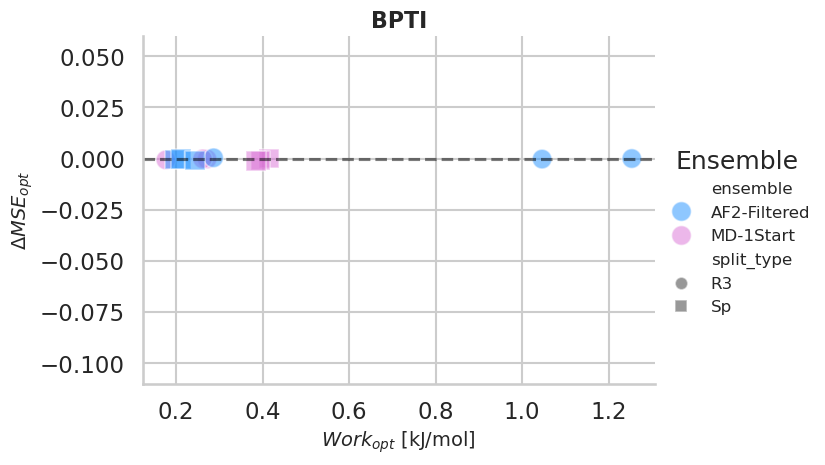

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set context and style
sns.set_context("talk")
sns.set_style("whitegrid")

# Filter the dataframe
_dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(full_dataset_order)]

# Force categorical ordering of ensembles
_dMSE_energy_df["ensemble"] = pd.Categorical(_dMSE_energy_df["ensemble"], 
                                           categories=full_dataset_order, 
                                           ordered=True)

# Create style mapping for split types
split_markers = {"R3": "o", "Sp": "s"}

# Create the FacetGrid
g = sns.FacetGrid(
    _dMSE_energy_df,
    row="protein",
    height=5,
    aspect=1.5,
    sharey=False,
    sharex=False,
    row_order=["BPTI"]
)

# Map the scatterplot to the FacetGrid
g.map_dataframe(
    sns.scatterplot,
    x="delta_G_opt_kj",
    y="dMSE",
    hue="ensemble",
    palette=full_dataset_colours,
    style="split_type",
    markers=split_markers,
    alpha=0.5,
    size="ensemble",
    sizes=full_dataset_sizes
)

# Custom function to set colored titles
def set_colored_titles(figure):
    for ax in figure.axes:
        title = ax.get_title()
        if title:
            # For single row, we only have the protein name
            protein = title
            # Create a colored title
            ax.set_title(protein, fontsize=16, fontweight="bold")

# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}")
set_colored_titles(g.fig)

# Set axis labels using metric mappings
g.set_xlabels(metric_axis_mapping["delta_G_opt_kj"], fontsize=14)
g.set_ylabels(metric_axis_mapping["dMSE"], fontsize=14)

# Add horizontal line at y=0
for ax in g.axes.flat:
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Set axis limits
g.set(ylim=(-0.11, 0.06))

# Customize legend
legend = g.add_legend(title="Ensemble", fontsize=12)
# Update legend title and labels
legend.set_title("Split Types", prop={'size': 12})

# Update legend labels to use split name mapping
for t in legend.get_texts():
    if t.get_text() in split_name_mapping:
        t.set_text(split_name_mapping[t.get_text()])

# Adjust layout
plt.tight_layout()

plt.show()

In [ ]:
dMSE_ensemble_pmf_df.ensemble.unique()

In [ ]:



import seaborn as sns
import matplotlib.pyplot as plt
# Set context and style
# sns.set_context("talk")
sns.set_style("whitegrid")
# # Create a custom palette
_dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad"]#, "af_conftop", "af_confbottom", "af_conf0.0", "af_conf0.1", "af_conf0.2", "af_conf0.3", "af_conf0.4", "af_conf0.5", "af_conf0.6", "af_conf0.7", "af_conf0.8", "af_conf0.9"]
_dataset_order = ["MD_Bad", "af_clean"]
_dataset_order = ["af_dirty", "af_clean", "1Start", "10Start", "TFES"]
_dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin([ "R3", "Sp"])]

# include only the _dataset_order
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# Create the FacetGrid
# Map the boxplot to the FacetGrid
g = sns.FacetGrid(_dMSE_energy_df, row="protein", col="ensemble", height=5, aspect=1, sharey='row', sharex='row', row_order=["BPTI"], col_order=_dataset_order)
g.map_dataframe(sns.boxplot, x="split_type", y="dMSE", hue="split_type", palette={"R3": "green", "Sp": "grey"})
# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}")#, fontsize=16, fontweight="bold")
# g.set_xlabels("energy_difference", fontsize=14)
g.set_ylabels("dMSE")#, fontsize=14)
# # Rotate x-tick labels
# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # Adjust subplot spacing
# g.tight_layout()
# Add legend
# g.set(yscale="log")

# Add a line at y = 0
for ax in g.axes.flat:
    ax.axhline(y=0, color='black', linestyle='--')

# g.add_legend(title="split type")#, fontsize=12)
# Show the plot
# g.set(ylim=(-3, 0))
plt.show()

In [ ]:



import seaborn as sns
import matplotlib.pyplot as plt
# Set context and style
# sns.set_context("talk")
sns.set_style("whitegrid")
# # Create a custom palette
_dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad"]#, "af_conftop", "af_confbottom", "af_conf0.0", "af_conf0.1", "af_conf0.2", "af_conf0.3", "af_conf0.4", "af_conf0.5", "af_conf0.6", "af_conf0.7", "af_conf0.8", "af_conf0.9"]
_dataset_order = ["MD_Bad", "af_clean"]
_dataset_order = ["af_dirty", "af_clean", "1Start", "10Start", "TFES"]
_dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin([ "R3", "Sp"])]

# include only the _dataset_order
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# Create the FacetGrid
# Map the boxplot to the FacetGrid
g = sns.FacetGrid(_dMSE_energy_df, row="protein", col="ensemble", height=5, aspect=1, sharey='row', sharex='row', row_order=["BPTI"], col_order=_dataset_order)
g.map_dataframe(sns.boxplot, x="split_type", y="-Tdelta_S_opt_kj", hue="split_type", palette={"R3": "green", "Sp": "grey"})
# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}")#, fontsize=16, fontweight="bold")
# g.set_xlabels("energy_difference", fontsize=14)
g.set_ylabels("-Tdelta_S_opt_kj")#, fontsize=14)
# # Rotate x-tick labels
# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # Adjust subplot spacing
# g.tight_layout()
# Add legend
# g.set(yscale="log")

# Add a line at y = 0
for ax in g.axes.flat:
    ax.axhline(y=0, color='black', linestyle='--')

# g.add_legend(title="split type")#, fontsize=12)
# Show the plot
# g.set(ylim=(-3, 0))
plt.show()

In [ ]:



import seaborn as sns
import matplotlib.pyplot as plt
# Set context and style
# sns.set_context("talk")
sns.set_style("whitegrid")
# # Create a custom palette
_dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad"]#, "af_conftop", "af_confbottom", "af_conf0.0", "af_conf0.1", "af_conf0.2", "af_conf0.3", "af_conf0.4", "af_conf0.5", "af_conf0.6", "af_conf0.7", "af_conf0.8", "af_conf0.9"]
_dataset_order = ["MD_Bad", "af_clean"]
_dataset_order = ["af_dirty", "af_clean", "1Start", "10Start", "TFES"]
_dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin([ "R3", "Sp"])]

# include only the _dataset_order
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# Create the FacetGrid
# Map the boxplot to the FacetGrid
g = sns.FacetGrid(_dMSE_energy_df, row="protein", col="ensemble", height=5, aspect=1, sharey='row', sharex='row', row_order=["BPTI"], col_order=_dataset_order)
g.map_dataframe(sns.boxplot, x="split_type", y="delta_H_opt_kj", hue="split_type", palette={"R3": "green", "Sp": "grey"})
# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}")#, fontsize=16, fontweight="bold")
# g.set_xlabels("energy_difference", fontsize=14)
g.set_ylabels("delta_H_opt_kj")#, fontsize=14)
# # Rotate x-tick labels
# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # Adjust subplot spacing
# g.tight_layout()
# Add legend
# g.set(yscale="log")

# Add a line at y = 0
for ax in g.axes.flat:
    ax.axhline(y=0, color='black', linestyle='--')

# g.add_legend(title="split type")#, fontsize=12)
# Show the plot
# g.set(ylim=(-3, 0))
plt.show()

In [ ]:



import seaborn as sns
import matplotlib.pyplot as plt
# Set context and style
# sns.set_context("talk")
sns.set_style("whitegrid")
# # # Create a custom palette
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad"]#, "af_conftop", "af_confbottom", "af_conf0.0", "af_conf0.1", "af_conf0.2", "af_conf0.3", "af_conf0.4", "af_conf0.5", "af_conf0.6", "af_conf0.7", "af_conf0.8", "af_conf0.9"]
# _dataset_order = ["MD_Bad", "af_clean"]
_dataset_order = ["af_dirty", "af_clean", "1Start", "10Start", "TFES"]

_dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin([ "R3", "Sp"])]


# include only the _dataset_order
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# Create the FacetGrid
g = sns.FacetGrid(_dMSE_energy_df, row="protein", col="ensemble", height=3, aspect=1.5, sharey='row', sharex='row', row_order=["BPTI"])#, col_order=split_order, sharex=True)
# Map the boxplot to the FacetGrid
g.map_dataframe(sns.boxplot, x="split_type", y="delta_H_opt_kj", hue="protein", palette="Set1")#, order=_dataset_order)
# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}")#, fontsize=16, fontweight="bold")
# g.set_xlabels("energy_difference", fontsize=14)
g.set_ylabels("delta_H_opt_kj")#, fontsize=14)
# # Rotate x-tick labels
# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # Adjust subplot spacing
# g.tight_layout()
# Add legend
# g.set(yscale="log")

# Add a line at y = 0
for ax in g.axes.flat:
    ax.axhline(y=0, color='black', linestyle='--')

# g.add_legend(title="split type")#, fontsize=12)
# Show the plot
# g.set(ylim=(-3, 0))
plt.show()

In [ ]:



import seaborn as sns
import matplotlib.pyplot as plt
# Set context and style
# sns.set_context("talk")
sns.set_style("whitegrid")
# # Create a custom palette
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad"]#, "af_conftop", "af_confbottom", "af_conf0.0", "af_conf0.1", "af_conf0.2", "af_conf0.3", "af_conf0.4", "af_conf0.5", "af_conf0.6", "af_conf0.7", "af_conf0.8", "af_conf0.9"]
# _dataset_order = ["MD_Bad", "af_clean"]
_dataset_order = ["af_dirty", "af_clean", "1Start", "10Start", "TFES"]

_dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin([ "R3", "Sp"])]


# include only the _dataset_order
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# Create the FacetGrid
g = sns.FacetGrid(_dMSE_energy_df, row="protein", col="ensemble", height=3, aspect=1.5, sharey='row', sharex='row', row_order=["BPTI"])#, col_order=split_order, sharex=True)
# Map the boxplot to the FacetGrid
g.map_dataframe(sns.boxplot, x="split_type", y="delta_H_abs_kj", hue="protein", palette="Set1")#, order=_dataset_order)
# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}")#, fontsize=16, fontweight="bold")
# g.set_xlabels("energy_difference", fontsize=14)
g.set_ylabels("delta_H_abs_kj")#, fontsize=14)
# # Rotate x-tick labels
# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # Adjust subplot spacing
# g.tight_layout()
# Add legend
# g.set(yscale="log")

# Add a line at y = 0
# for ax in g.axes.flat:
#     ax.axhline(y=0, color='black', linestyle='--')

# g.add_legend(title="split type")#, fontsize=12)
# Show the plot
# g.set(ylim=(-3, 0))
plt.show()

In [ ]:
ensemble_pmf_df.protein.unique()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
_dataset_order = ["af_dirty", "af_clean", "1Start", "10Start", "TFES"]

# Filter data for specific split types
_ensemble_pmf_df = ensemble_pmf_df[ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]

# Filter for dataset order
_ensemble_pmf_df = _ensemble_pmf_df[_ensemble_pmf_df["ensemble"].isin(_dataset_order)]

# Print data for verification
print(ensemble_pmf_df.head())

# Create color palette
palette = sns.color_palette("Set2", n_colors=len(_ensemble_pmf_df["split_type"].unique()))

# Create FacetGrid
g = sns.FacetGrid(
    _ensemble_pmf_df,
    row="protein",
    col="ensemble",
    height=3,
    aspect=1,
    sharey='row',
    sharex='row'
)

# Map boxplot
g.map_dataframe(
    sns.boxplot,
    x="split_type",
    y="delta_H_abs_kj",
    hue="ensemble",
    palette=palette,
    order=['R3', 'Sp']
)

# Customize plot
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.set_xlabels("Split Type")
g.set_ylabels("ΔH_abs (kJ/mol)")

# Add horizontal line at y=0
for ax in g.axes.flat:
    ax.axhline(y=0, color='black', linestyle='--')

# Adjust layout
plt.subplots_adjust(top=0.95)

# Show plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data for specific split types
_ensemble_pmf_df = ensemble_pmf_df[ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]

# Filter for dataset order
_ensemble_pmf_df = _ensemble_pmf_df[_ensemble_pmf_df["ensemble"].isin(_dataset_order)]

# Print data for verification
print(ensemble_pmf_df.head())

# Create color palette
palette = sns.color_palette("Set2", n_colors=len(_ensemble_pmf_df["split_type"].unique()))

# Create FacetGrid
g = sns.FacetGrid(
    _ensemble_pmf_df,
    row="protein",
    col="ensemble",
    height=3,
    aspect=1,
    sharey='row',
    sharex='row'
)

# Map boxplot
g.map_dataframe(
    sns.boxplot,
    x="split_type",
    y="avg_H_opt_kj",
    hue="ensemble",
    palette=palette,
    order=['R3', 'Sp']
)

# Customize plot
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.set_xlabels("Split Type")
g.set_ylabels("ΔH_opt (kJ/mol)")

# Add horizontal line at y=0
# for ax in g.axes.flat:
#     ax.axhline(y=0, color='black', linestyle='--')

# Adjust layout
plt.subplots_adjust(top=0.95)

# Show plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set up the data
# Filter data for specific split types
_ensemble_pmf_df = ensemble_pmf_df[ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]
_dataset_order = ["af_dirty", "af_clean", "1Start", "10Start", "TFES"]

# Filter for dataset order
_ensemble_pmf_df = _ensemble_pmf_df[_ensemble_pmf_df["ensemble"].isin(_dataset_order)]

# Force the order of the datasets
_ensemble_pmf_df["ensemble"] = pd.Categorical(_ensemble_pmf_df["ensemble"], categories=_dataset_order, ordered=True)

# Define consistent styles for split types
split_styles = {
    'R3': {'marker': 'o', 'color': 'Green'},  # Orange
    'Sp': {'marker': 's', 'color': 'Grey'}   # Blue
}

# Create the FacetGrid
g = sns.FacetGrid(_ensemble_pmf_df, 
                  row="protein", 
                  col="ensemble", 
                  height=5, 
                  aspect=1, 
                  sharey='row', 
                  sharex='row')

# Custom scatter plot function with consistent styling
def custom_scatter(data, **kwargs):
    ax = plt.gca()
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        ax.scatter(subset["-Tdelta_S_opt_kj"], 
                  subset["delta_H_abs_kj"],
                  marker=style['marker'],
                  color=style['color'],
                #   s=subset["avg_H_opt_kj"]*10,
                  label=split_type,
                  alpha=0.4)

# Function to calculate and annotate mean, median, and std dev with consistent styling
def annotate_statistics(data, **kwargs):
    ax = plt.gca()
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        if len(subset) > 0:
            # Calculate statistics
            mean_x = subset["-Tdelta_S_opt_kj"].mean()
            mean_y = subset["delta_H_abs_kj"].mean()
            median_x = subset["-Tdelta_S_opt_kj"].median()
            median_y = subset["delta_H_abs_kj"].median()
            
            # Calculate multivariate standard deviation
            X = np.vstack([subset["-Tdelta_S_opt_kj"], subset["delta_H_abs_kj"]]).T
            cov_matrix = np.cov(X.T)
            mult_std = np.sqrt(np.trace(cov_matrix))
            
            # Plot mean with darker version of split type color
            ax.scatter(mean_x, mean_y, 
                      marker='*', 
                      s=200,
                      color=style['color'], 
                      edgecolor='black',
                      label=f'{split_type} Mean',
                      alpha=0.8,
                      zorder=5)
            
            # # Plot median with lighter version of split type color
            # ax.scatter(median_x, median_y, 
            #           marker='D', 
            #           s=100,
            #           color=style['color'], 
            #           edgecolor='black',
            #           alpha=1,
            #           label=f'{split_type} Median',
            #           zorder=5)
            
            # Add std dev annotation in the corner
            ax.annotate(f'{split_type} σ = {mult_std:.2f}', 
                       xy=(0.02, 0.98 - (0.05 * list(split_styles.keys()).index(split_type))),
                       xycoords='axes fraction',
                       fontsize=8,
                       color=style['color'],
                       bbox=dict(facecolor='white', edgecolor=style['color'], alpha=0.5))

# Apply the plotting functions
g.map_dataframe(custom_scatter)
g.map_dataframe(annotate_statistics)

# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}")
# g.set(yscale="log")

# Add axis labels
g.set_axis_labels("TΔS_opt (kJ/mol)", "ΔH_abs (kJ/mol)")

# Adjust layout
plt.subplots_adjust(top=0.95)

# Add a custom legend
handles = []
labels = []
for split_type, style in split_styles.items():
    # Add scatter plot points
    handles.append(plt.Line2D([0], [0], 
                            marker=style['marker'],
                            color=style['color'],
                            linestyle='None',
                            label=split_type))
    # Add mean markers
    handles.append(plt.Line2D([0], [0], 
                            marker='*',
                            color=style['color'],
                            # markeredgecolor='black',
                            linestyle='None',
                            markersize=10,
                            label=f'{split_type} Mean'))
    # # Add median markers
    # handles.append(plt.Line2D([0], [0], 
    #                         marker='D',
    #                         color=style['color'],
    #                         markeredgecolor='black',
    #                         linestyle='None',
    #                         alpha=0.7,
    #                         markersize=8,
    #                         label=f'{split_type} Median'))
    labels.extend([split_type, f'{split_type} Mean'])

g.fig.legend(handles, labels, 
            loc='center right', 
            bbox_to_anchor=(0.98, 0.5),
            title="Split Types")

plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set up the data
# Filter data for specific split types
_ensemble_pmf_df = ensemble_pmf_df[ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
_dataset_order = ["af_dirty", "af_clean", "1Start", "10Start", "TFES"]

# Filter for dataset order
_ensemble_pmf_df = _ensemble_pmf_df[_ensemble_pmf_df["ensemble"].isin(_dataset_order)]

# Define consistent styles for split types
split_styles = {
    'R3': {'marker': 'o', 'color': 'Green'},  # Orange
    'Sp': {'marker': 's', 'color': 'Grey'}   # Blue
}

# Create the FacetGrid
g = sns.FacetGrid(_ensemble_pmf_df, 
                  row="protein", 
                  col="ensemble", 
                  height=5, 
                  aspect=1, 
                  sharey='row', 
                  sharex='row')

# Custom scatter plot function with consistent styling
def custom_scatter(data, **kwargs):
    ax = plt.gca()
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        ax.scatter(subset["avg_H_opt_kj"], 
                  subset["delta_H_abs_kj"],
                  marker=style['marker'],
                  color=style['color'],
                #   s=subset["avg_H_opt_kj"]*10,
                  label=split_type,
                  alpha=0.6)

# Function to calculate and annotate mean, median, and std dev with consistent styling
def annotate_statistics(data, **kwargs):
    ax = plt.gca()
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        if len(subset) > 0:
            # Calculate statistics
            mean_x = subset["avg_H_opt_kj"].mean()
            mean_y = subset["delta_H_abs_kj"].mean()
            median_x = subset["avg_H_opt_kj"].median()
            median_y = subset["delta_H_abs_kj"].median()
            
            # Calculate multivariate standard deviation
            X = np.vstack([subset["avg_H_opt_kj"], subset["delta_H_abs_kj"]]).T
            cov_matrix = np.cov(X.T)
            mult_std = np.sqrt(np.trace(cov_matrix))
            
            # Plot mean with darker version of split type color
            # ax.scatter(mean_x, mean_y, 
            #           marker='*', 
            #           s=200,
            #           color=style['color'], 
            #           edgecolor='black',
            #           label=f'{split_type} Mean',
            #           zorder=5)
            
            # # Plot median with lighter version of split type color
            # ax.scatter(median_x, median_y, 
            #           marker='D', 
            #           s=100,
            #           color=style['color'], 
            #           edgecolor='black',
            #           alpha=1,
            #           label=f'{split_type} Median',
            #           zorder=5)
            
            # Add std dev annotation in the corner
            ax.annotate(f'{split_type} σ = {mult_std:.2f}', 
                       xy=(0.02, 0.98 - (0.05 * list(split_styles.keys()).index(split_type))),
                       xycoords='axes fraction',
                       fontsize=8,
                       color=style['color'],
                       bbox=dict(facecolor='white', edgecolor=style['color'], alpha=0.5))

# Apply the plotting functions
g.map_dataframe(custom_scatter)
g.map_dataframe(annotate_statistics)

# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}")
# g.set(yscale="log")

# Add axis labels
g.set_axis_labels("ΔH_opt (kJ/mol)", "ΔH_abs (kJ/mol)")

# Adjust layout
plt.subplots_adjust(top=0.95)

# Add a custom legend
handles = []
labels = []
for split_type, style in split_styles.items():
    # Add scatter plot points
    handles.append(plt.Line2D([0], [0], 
                            marker=style['marker'],
                            color=style['color'],
                            linestyle='None',
                            label=split_type))
    # Add mean markers
    # handles.append(plt.Line2D([0], [0], 
    #                         marker='*',
    #                         color=style['color'],
    #                         markeredgecolor='black',
    #                         linestyle='None',
    #                         markersize=10,
    #                         label=f'{split_type} Mean'))
    # # Add median markers
    # handles.append(plt.Line2D([0], [0], 
    #                         marker='D',
    #                         color=style['color'],
    #                         markeredgecolor='black',
    #                         linestyle='None',
    #                         alpha=0.7,
    #                         markersize=8,
    #                         label=f'{split_type} Median'))
    # labels.extend([split_type, f'{split_type} Mean', f'{split_type} Median'])

g.fig.legend(handles, labels, 
            loc='center right', 
            bbox_to_anchor=(0.98, 0.5),
            title="Split Types")

plt.show()

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # Set up the data
# # Filter data for specific split types
# _ensemble_pmf_df = ensemble_pmf_df[ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]

# # Filter for dataset order
# _ensemble_pmf_df = _ensemble_pmf_df[_ensemble_pmf_df["ensemble"].isin(_dataset_order)]

# # Define consistent styles for split types
# split_styles = {
#     'R3': {'marker': 'o', 'color': 'Green'},  # Orange
#     'Sp': {'marker': 's', 'color': 'Grey'}   # Blue
# }

# # Create the FacetGrid
# g = sns.FacetGrid(_ensemble_pmf_df, 
#                   row="protein", 
#                   col="ensemble", 
#                   height=5, 
#                   aspect=1, 
#                   sharey='row', 
#                   sharex='row')

# # Custom scatter plot function with consistent styling
# def custom_scatter(data, **kwargs):
#     ax = plt.gca()
#     for split_type, style in split_styles.items():
#         subset = data[data["split_type"] == split_type]
#         ax.scatter(subset["-avg_TdS_opt_kj"], 
#                   subset["avg_H_opt_kj"],
#                   marker=style['marker'],
#                   color=style['color'],
#                   s=subset["delta_H_abs"],
#                   label=split_type,
#                   alpha=0.6)

# # Function to calculate and annotate mean, median, and std dev with consistent styling
# def annotate_statistics(data, **kwargs):
#     ax = plt.gca()
#     for split_type, style in split_styles.items():
#         subset = data[data["split_type"] == split_type]
#         if len(subset) > 0:
#             # Calculate statistics
#             mean_x = subset["-avg_TdS_opt_kj"].mean()
#             mean_y = subset["avg_H_opt_kj"].mean()
#             median_x = subset["-avg_TdS_opt_kj"].median()
#             median_y = subset["avg_H_opt_kj"].median()
            
#             # Calculate multivariate standard deviation
#             X = np.vstack([subset["-avg_TdS_opt_kj"], subset["avg_H_opt_kj"]]).T
#             cov_matrix = np.cov(X.T)
#             mult_std = np.sqrt(np.trace(cov_matrix))
            
#             # Plot mean with darker version of split type color
#             # ax.scatter(mean_x, mean_y, 
#             #           marker='*', 
#             #           s=200,
#             #           color=style['color'], 
#             #           edgecolor='black',
#             #           label=f'{split_type} Mean',
#             #           zorder=5)
            
#             # # Plot median with lighter version of split type color
#             # ax.scatter(median_x, median_y, 
#             #           marker='D', 
#             #           s=100,
#             #           color=style['color'], 
#             #           edgecolor='black',
#             #           alpha=1,
#             #           label=f'{split_type} Median',
#             #           zorder=5)
            
#             # Add std dev annotation in the corner
#             ax.annotate(f'{split_type} σ = {mult_std:.2f}', 
#                        xy=(0.02, 0.98 - (0.05 * list(split_styles.keys()).index(split_type))),
#                        xycoords='axes fraction',
#                        fontsize=8,
#                        color=style['color'],
#                        bbox=dict(facecolor='white', edgecolor=style['color'], alpha=0.5))

# # Apply the plotting functions
# g.map_dataframe(custom_scatter)
# g.map_dataframe(annotate_statistics)

# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}")
# # g.set(yscale="log")

# # Add axis labels
# g.set_axis_labels("TΔS_opt (kJ/mol)", "ΔH_opt (kJ/mol)")

# # Adjust layout
# plt.subplots_adjust(top=0.95)

# # Add a custom legend
# handles = []
# labels = []
# for split_type, style in split_styles.items():
#     # Add scatter plot points
#     handles.append(plt.Line2D([0], [0], 
#                             marker=style['marker'],
#                             color=style['color'],
#                             linestyle='None',
#                             label=split_type))
#     # Add mean markers
#     # handles.append(plt.Line2D([0], [0], 
#     #                         marker='*',
#     #                         color=style['color'],
#     #                         markeredgecolor='black',
#     #                         linestyle='None',
#     #                         markersize=10,
#     #                         label=f'{split_type} Mean'))
#     # # Add median markers
#     # handles.append(plt.Line2D([0], [0], 
#     #                         marker='D',
#     #                         color=style['color'],
#     #                         markeredgecolor='black',
#     #                         linestyle='None',
#     #                         alpha=0.7,
#     #                         markersize=8,
#     #                         label=f'{split_type} Median'))
#     # labels.extend([split_type, f'{split_type} Mean', f'{split_type} Median'])

# g.fig.legend(handles, labels, 
#             loc='center right', 
#             bbox_to_anchor=(0.98, 0.5),
#             title="Split Types")

# plt.show()

In [ ]:



import seaborn as sns
import matplotlib.pyplot as plt
# Set context and style
# sns.set_context("talk")
sns.set_style("whitegrid")
# # Create a custom palette
_dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad"]#, "af_conftop", "af_confbottom", "af_conf0.0", "af_conf0.1", "af_conf0.2", "af_conf0.3", "af_conf0.4", "af_conf0.5", "af_conf0.6", "af_conf0.7", "af_conf0.8", "af_conf0.9"]
# _dataset_order = ["MD_Bad", "af_clean"]
_dataset_order = ["af_dirty", "af_clean", "1Start", "10Start", "TFES"]

_dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin([ "R3", "Sp"])]


# include only the _dataset_order
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# Create the FacetGrid
g = sns.FacetGrid(_dMSE_energy_df, row="protein", col="ensemble", height=3, aspect=1.5, sharey='row', sharex='row', row_order=["BPTI"])#, col_order=split_order, sharex=True)
# Map the boxplot to the FacetGrid
g.map_dataframe(sns.boxplot, x="split_type", y="delta_H_abs_kj", hue="protein", palette="pastel")#, order=_dataset_order)
# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}")#, fontsize=16, fontweight="bold")
# g.set_xlabels("energy_difference", fontsize=14)
g.set_ylabels("avg_delta_G_kj")#, fontsize=14)
# # Rotate x-tick labels
# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # Adjust subplot spacing
# g.tight_layout()
# Add legend
# g.set(yscale="log")

# Add a line at y = 0
for ax in g.axes.flat:
    ax.axhline(y=0, color='black', linestyle='--')

# g.add_legend(title="split type")#, fontsize=12)
# Show the plot
# g.set(ylim=(-3, 0))
plt.show()

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set context and style
sns.set_style("whitegrid")

# Create the FacetGrid
g = sns.FacetGrid(_dMSE_energy_df, row="protein", col="ensemble", height=3, aspect=1.5, sharey='row', sharex='row', row_order=["BPTI"])

# Map the boxplot to the FacetGrid
g.map_dataframe(sns.boxplot, x="split_type", y="dMSE", hue="split_type", palette="Set2")

# Add a line at y = 0
for ax in g.axes.flat:
    ax.axhline(y=0, color='black', linestyle='--')

# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}")
g.set_ylabels("dMSE")

# Show the plot
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set context and style
sns.set_context("talk")
sns.set_style("whitegrid")

# Define the custom palette and order
_dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]
_dataset_order = ["af_dirty", "af_clean", "1Start", "10Start", "TFES"]

_dataset_colours = {
    "af_dirty": "green",
    "af_clean": "orange",
    "MD_Good": "red",
    "MD_Bad": "blue",
    "MD_Good+Bad": "purple",
    "1Start": "red",
    "10Start": "blue",
    "TFES": "purple"


}

# Filter the dataframe
_dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# Create the FacetGrid
g = sns.FacetGrid(
    _dMSE_energy_df, 
    row="protein",
    height=4, 
    aspect=1.5, 
    sharey=False, 
    sharex=False, 
    row_order=["BPTI"]
)

# Map the scatterplot to the FacetGrid
g.map_dataframe(
    sns.scatterplot, 
    x="delta_H_abs_kj", 
    y="avg_H_opt_kj", 
    hue="ensemble", 
    palette=_dataset_colours, 
    style="split_type",
    alpha=0.7
)

# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
g.set_xlabels("delta_H_abs_kj", fontsize=14)
g.set_ylabels("avg_H_opt_kj", fontsize=14)

# Adjust subplot spacing
g.tight_layout()
for ax in g.axes.flat:
    ax.axhline(y=0, color='black', linestyle='--')

# Add legend
# g.set(xscale="log")
g.set(xlim=(0,1))
g.add_legend(title="Ensemble", fontsize=12)

# Show the plot
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set context and style
sns.set_context("talk")
sns.set_style("whitegrid")

# Define the custom palette and order
_dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]
_dataset_order = ["af_dirty", "af_clean", "1Start", "10Start", "TFES"]

_dataset_colours = {
    "af_dirty": "green",
    "af_clean": "orange",
    "MD_Good": "red",
    "MD_Bad": "blue",
    "MD_Good+Bad": "purple",
    "1Start": "red",
    "10Start": "blue",
    "TFES": "purple"


}

# Define custom sizes for each dataset
_dataset_sizes = {
    "af_dirty": 50,
    "af_clean": 200,
    "MD_Good": 50,
    "MD_Bad": 200,
    "MD_Good+Bad": 50,
    "1Start": 50,
    "10Start": 200,
    "TFES": 50
}

# Filter the dataframe
_dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# Create the FacetGrid
g = sns.FacetGrid(
    _dMSE_energy_df,
    row="protein",
    height=4,
    aspect=1.5,
    sharey=False,
    sharex=False,
    row_order=["BPTI"]
)

# Map the scatterplot to the FacetGrid
g.map_dataframe(
    sns.scatterplot,
    x="quasi_likelihood",
    y="dMSE",
    hue="ensemble",
    palette=_dataset_colours,
    style="split_type",
    alpha=0.7,
    size="ensemble",  # Use 'ensemble' column for size
    sizes=_dataset_sizes  # Use custom sizes
)

# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
g.set_xlabels("likelihood", fontsize=14)
g.set_ylabels("dMSE", fontsize=14)

# Adjust subplot spacing
g.tight_layout()
for ax in g.axes.flat:
    ax.axhline(y=0, color='black', linestyle='--')

# Add legend
# g.set(xlim=(0.4,1))
g.set(ylim=(-0.11, 0.06))
g.add_legend(title="Ensemble", fontsize=12)

# Show the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set context and style
sns.set_context("talk")
sns.set_style("whitegrid")

# Define the custom palette and order
_dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]
_dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad"]
_dataset_order = ["af_dirty", "af_clean", "1Start", "10Start", "TFES"]

_dataset_colours = {
    "af_dirty": "green",
    "af_clean": "orange",
    "MD_Good": "red",
    "MD_Bad": "blue",
    "MD_Good+Bad": "purple",
    "1Start": "red",
    "10Start": "blue",
    "TFES": "purple"


}
# Define custom sizes for each dataset
_dataset_sizes = {
    "af_dirty": 100,
    "af_clean": 200,
    "MD_Good": 100,
    "MD_Bad": 200,
    "MD_Good+Bad": 100,
    "1Start": 200,
    "10Start": 200,
    "TFES": 100
}
# Filter the dataframe
_dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# Create the FacetGrid
g = sns.FacetGrid(
    _dMSE_energy_df,
    row="protein",
    height=5,
    aspect=1.5,
    sharey=False,
    sharex=False,
    row_order=["BPTI"]

)

# Map the scatterplot to the FacetGrid
g.map_dataframe(
    sns.scatterplot,
    x="delta_G_opt_kj",
    y="dMSE",
    hue="ensemble",

    palette=_dataset_colours,
    style="split_type",
    alpha=0.5,
    size="ensemble",  # Use 'ensemble' column for size
    sizes=_dataset_sizes  # Use custom sizes
)

# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
g.set_xlabels("delta_G_opt_kj", fontsize=14)
g.set_ylabels("dMSE", fontsize=14)

# Adjust subplot spacing
g.tight_layout()
for ax in g.axes.flat:
    ax.axhline(y=0, color='black', linestyle='--')

# Add legend
# g.set(xlim=(0.9,1))
g.set(ylim=(-0.11, 0.06))
g.add_legend(title="Ensemble", fontsize=12)
# g.set(xscale="log")
# Show the plot
plt.show()

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # Set up the data
# _dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
# _dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# # Define consistent styles for split types
# split_styles = {
#     'R3': {'marker': 'o', 'color': 'Green'},
#     'Sp': {'marker': 's', 'color': 'Grey'}
# }

# # Create the FacetGrid
# g = sns.FacetGrid(_dMSE_energy_df, 
#                   row="protein", 
#                   col="ensemble", 
#                   height=5, 
#                   aspect=1, 
#                   sharey='row', 
#                   sharex='row')

# # Custom scatter plot function with consistent styling
# def custom_scatter(data, **kwargs):
#     ax = plt.gca()
#     ax.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Add horizontal line at y=0
#     for split_type, style in split_styles.items():
#         subset = data[data["split_type"] == split_type]
#         ax.scatter(subset["-avg_TdS_opt_kj"], 
#                   subset["dMSE"],
#                   marker=style['marker'],
#                   color=style['color'],
#                   s=subset["delta_H_abs"],
#                   label=split_type,
#                   alpha=0.6)

# # Function to calculate and annotate mean, median, and std dev with consistent styling
# def annotate_statistics(data, **kwargs):
#     ax = plt.gca()
#     for split_type, style in split_styles.items():
#         subset = data[data["split_type"] == split_type]
#         if len(subset) > 0:
#             # Calculate statistics
#             mean_x = subset["-avg_TdS_opt_kj"].mean()
#             mean_y = subset["dMSE"].mean()
#             median_x = subset["-avg_TdS_opt_kj"].median()
#             median_y = subset["dMSE"].median()
            
#             # Calculate multivariate standard deviation
#             X = np.vstack([subset["-avg_TdS_opt_kj"], subset["dMSE"]]).T
#             cov_matrix = np.cov(X.T)
#             mult_std = np.sqrt(np.trace(cov_matrix))
            
#             # Add std dev annotation in the corner
#             ax.annotate(f'{split_type} σ = {mult_std:.2f}', 
#                        xy=(0.02, 0.98 - (0.05 * list(split_styles.keys()).index(split_type))),
#                        xycoords='axes fraction',
#                        fontsize=8,
#                        color=style['color'],
#                        bbox=dict(facecolor='white', edgecolor=style['color'], alpha=0.5))

# # Apply the plotting functions
# g.map_dataframe(custom_scatter)
# g.map_dataframe(annotate_statistics)

# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}")

# # Add axis labels
# g.set_axis_labels("TΔS_opt (kJ/mol)", "dMSE")

# # Adjust layout
# plt.subplots_adjust(top=0.95)

# # Add a custom legend
# handles = []
# labels = []
# for split_type, style in split_styles.items():
#     # Add scatter plot points
#     handles.append(plt.Line2D([0], [0], 
#                             marker=style['marker'],
#                             color=style['color'],
#                             linestyle='None',
#                             label=split_type))

# g.fig.legend(handles, labels, 
#             loc='center right', 
#             bbox_to_anchor=(0.98, 0.5),
#             title="Split Types")

# plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set up the data
_dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]
# select BPTI
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["protein"].isin(["BPTI"])]
# Define consistent styles for split types
split_styles = {
    'R3': {'marker': 'o', 'color': 'Green'},
    'Sp': {'marker': 's', 'color': 'Grey'}
}

# Create the FacetGrid
g = sns.FacetGrid(_dMSE_energy_df, 
                #   row="protein", 
                  col="ensemble", 
                  col_wrap=2,
                  height=4, 
                  aspect=1, 
                  sharey='row', 
                  sharex='row')

# Custom scatter plot function with consistent styling
def custom_scatter(data, **kwargs):
    ax = plt.gca()
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Add horizontal line at y=0
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        ax.scatter(subset["avg_G_opt_kj"], 
                  subset["dMSE"],
                  marker=style['marker'],
                  color=style['color'],
                  s=subset["delta_H_abs"],
                  label=split_type,
                  alpha=0.6)

# Function to calculate and annotate mean, median, and std dev with consistent styling
def annotate_statistics(data, **kwargs):
    ax = plt.gca()
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        if len(subset) > 0:
            # Calculate statistics
            mean_x = subset["avg_G_opt_kj"].mean()
            mean_y = subset["dMSE"].mean()
            median_x = subset["avg_G_opt_kj"].median()
            median_y = subset["dMSE"].median()
            
            # Calculate multivariate standard deviation
            X = np.vstack([subset["avg_G_opt_kj"], subset["dMSE"]]).T
            cov_matrix = np.cov(X.T)
            mult_std = np.sqrt(np.trace(cov_matrix))
            
            # Add std dev annotation in the corner
            ax.annotate(f'{split_type} σ = {mult_std:.2f}', 
                       xy=(0.02, 0.98 - (0.05 * list(split_styles.keys()).index(split_type))),
                       xycoords='axes fraction',
                       fontsize=8,
                       color=style['color'],
                       bbox=dict(facecolor='white', edgecolor=style['color'], alpha=0.5))

# Apply the plotting functions
g.map_dataframe(custom_scatter)
g.map_dataframe(annotate_statistics)

# Customize the plot
g.set_titles(row_template="{row_name}", col_template="BPTI | {col_name}")

# Add axis labels
g.set_axis_labels("ΔG_opt (kJ/mol)", "ΔMSE")

# Adjust layout
plt.subplots_adjust(top=0.95)

# Add a custom legend
handles = []
labels = []
for split_type, style in split_styles.items():
    # Add scatter plot points
    handles.append(plt.Line2D([0], [0], 
                            marker=style['marker'],
                            color=style['color'],
                            linestyle='None',
                            label=split_type))

# g.fig.legend(handles, labels, 
#             loc='center right', 
#             bbox_to_anchor=(0.98, 0.5),
#             # title="Split Types"
#             )

plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set up the data
_dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]
# select BPTI
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["protein"].isin(["BPTI"])]
# Define consistent styles for split types
split_styles = {
    'R3': {'marker': 'o', 'color': 'Green'},
    'Sp': {'marker': 's', 'color': 'Grey'}
}

# Create the FacetGrid
g = sns.FacetGrid(_dMSE_energy_df, 
                #   row="protein", 
                  col="ensemble", 
                  col_wrap=2,
                  height=4, 
                  aspect=1, 
                  sharey='row', 
                  sharex='row')

# Custom scatter plot function with consistent styling
def custom_scatter(data, **kwargs):
    ax = plt.gca()
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Add horizontal line at y=0
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        ax.scatter(subset["-avg_TdS_opt_kj"], 
                  subset["delta_H_abs_kj"],
                  marker=style['marker'],
                  color=style['color'],
                #   s=subset["delta_H_abs"],
                  label=split_type,
                  alpha=0.6)

# Function to calculate and annotate mean, median, and std dev with consistent styling
def annotate_statistics(data, **kwargs):
    ax = plt.gca()
    for split_type, style in split_styles.items():
        subset = data[data["split_type"] == split_type]
        if len(subset) > 0:
            # Calculate statistics
            mean_x = subset["-avg_TdS_opt_kj"].mean()
            mean_y = subset["delta_H_abs_kj"].mean()
            median_x = subset["-avg_TdS_opt_kj"].median()
            median_y = subset["delta_H_abs_kj"].median()
            
            # Calculate multivariate standard deviation
            X = np.vstack([subset["-avg_TdS_opt_kj"], subset["delta_H_abs_kj"]]).T
            cov_matrix = np.cov(X.T)
            mult_std = np.sqrt(np.trace(cov_matrix))
            
            # Add std dev annotation in the corner
            ax.annotate(f'{split_type} σ = {mult_std:.2f}', 
                       xy=(0.02, 0.98 - (0.05 * list(split_styles.keys()).index(split_type))),
                       xycoords='axes fraction',
                       fontsize=8,
                       color=style['color'],
                       bbox=dict(facecolor='white', edgecolor=style['color'], alpha=0.5))

# Apply the plotting functions
g.map_dataframe(custom_scatter)
g.map_dataframe(annotate_statistics)

# Customize the plot
g.set_titles(row_template="{row_name}", col_template="BPTI | {col_name}")

# Add axis labels
g.set_axis_labels("-TΔS_opt (kJ/mol)", "-ΔH_abs (kJ/mol)")

# Adjust layout
plt.subplots_adjust(top=0.95)

# Add a custom legend
handles = []
labels = []
for split_type, style in split_styles.items():
    # Add scatter plot points
    handles.append(plt.Line2D([0], [0], 
                            marker=style['marker'],
                            color=style['color'],
                            linestyle='None',
                            label=split_type))

# g.fig.legend(handles, labels, 
#             loc='center right', 
#             bbox_to_anchor=(0.98, 0.5),
#             # title="Split Types"
#             )

plt.show()


In [ ]:
ensemble_pmf_df.quasi_likelihood

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")

# # Define the custom palette and order
# _dataset_order = ["af_clean", "MD_Bad"]
# _dataset_colours = {
#     "af_dirty": "green",
#     "af_clean": "orange",
#     "MD_Good": "red",
#     "MD_Bad": "blue",
#     "MD_Good+Bad": "purple"
# }

# _dataset_point_size = {
#     "af_dirty": 2,
#     "af_clean": 10,
#     "MD_Good": 2,
#     "MD_Bad": 10,
#     "MD_Good+Bad": 2
# }

# # Filter the dataframe
# _dMSE_energy_df = dMSE_ensemble_pmf_df[dMSE_ensemble_pmf_df["split_type"].isin(["R3", "Sp"])]
# _dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(
#     _dMSE_energy_df, 
#     row="protein",
#     height=4, 
#     aspect=1.5, 
#     sharey=False, 
#     sharex=False, 
#     row_order=["BPTI"]
# )

# # Map the scatterplot to the FacetGrid
# g.map_dataframe(
#     sns.scatterplot, 
#     x="likelihood", 
#     y="dMSE", 
#     hue="ensemble", 
#     palette=_dataset_colours, 
#     style="split_type",
#     alpha=0.7
# )

# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("likelihood", fontsize=14)
# g.set_ylabels("dMSE", fontsize=14)

# # Adjust subplot spacing
# g.tight_layout()
# for ax in g.axes.flat:
#     ax.axhline(y=0, color='black', linestyle='--')

# # Add legend
# # g.set(xscale="log")
# g.set(xlim=(0,1))
# g.add_legend(title="Ensemble", fontsize=12)

# # Show the plot
# plt.show()


In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad"]#, "af_conftop", "af_confbottom", "af_conf0.0", "af_conf0.1", "af_conf0.2", "af_conf0.3", "af_conf0.4", "af_conf0.5", "af_conf0.6", "af_conf0.7", "af_conf0.8", "af_conf0.9"]
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]

# _dMSE_energy_df = dMSE_energy_df[MSE_energy_df["split_type"].isin([ "R3", "Sp"])]


# # include only the _dataset_order
# _dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_dMSE_energy_df, row="protein", height=5, aspect=1.5, sharey='row', sharex='row')#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.boxplot, x="ensemble", y="Gfe**(dMSE)", hue="split_type", palette="Set2")#, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# # g.set_xlabels("energy_difference", fontsize=14)
# g.set_ylabels("Gfe**(dMSE)", fontsize=14)
# # # Rotate x-tick labels
# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# # g.set(yscale="log")

# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad"]#, "af_conftop", "af_confbottom", "af_conf0.0", "af_conf0.1", "af_conf0.2", "af_conf0.3", "af_conf0.4", "af_conf0.5", "af_conf0.6", "af_conf0.7", "af_conf0.8", "af_conf0.9"]
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]

# _dMSE_energy_df = dMSE_energy_df[MSE_energy_df["split_type"].isin([ "R3", "Sp"])]


# # include only the _dataset_order
# _dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_dMSE_energy_df, row="protein", height=5, aspect=1.5, sharey='row', sharex='row')#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.boxplot, x="ensemble", y="dMSE/gibbs_free_energy", hue="split_type", palette="Set2")#, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# # g.set_xlabels("energy_difference", fontsize=14)
# g.set_ylabels("dMSE/gibbs_free_energy", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# # g.set(xscale="log")

# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad"]#, "af_conftop", "af_confbottom", "af_conf0.0", "af_conf0.1", "af_conf0.2", "af_conf0.3", "af_conf0.4", "af_conf0.5", "af_conf0.6", "af_conf0.7", "af_conf0.8", "af_conf0.9"]
# _dataset_order = ["af_dirty", "af_clean"]

# _dMSE_energy_df = dMSE_energy_df[MSE_energy_df["split_type"].isin([ "R3", "Sp"])]


# # include only the _dataset_order
# _dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_dMSE_energy_df, row="protein", col="ensemble", height=3, aspect=1.2, sharey=True, sharex=True)#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.boxplot, x="ensemble", y="JSD", hue="split_type", palette="Set2")#, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}")#, fontsize=16, fontweight="bold")
# # g.set_xlabels("energy_difference", fontsize=14)
# g.set_ylabels("JSD")#, fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# # g.set(xscale="log")

# # g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad"]#, "af_conftop", "af_confbottom", "af_conf0.0", "af_conf0.1", "af_conf0.2", "af_conf0.3", "af_conf0.4", "af_conf0.5", "af_conf0.6", "af_conf0.7", "af_conf0.8", "af_conf0.9"]
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]

# _dMSE_energy_df = dMSE_energy_df[dMSE_energy_df["split_type"].isin([ "R3", "Sp"])]


# # include only the _dataset_order
# _dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_dMSE_energy_df, row="protein",col="ensemble", height=5, aspect=1.5, sharey=True, sharex=True)#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.scatterplot, x="energy_difference", y="dMSE", hue="split_type", palette="Set2")#, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("energy_difference", fontsize=14)
# g.set_ylabels("dMSE", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# g.set(xscale="log")

# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]

# _MSE_energy_df = MSE_energy_df[MSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# _MSE_energy_df=MSE_energy_df
# _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_MSE_energy_df, row="protein", col="ensemble",height=5, aspect=1.5, sharey=True, sharex=True)#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.scatterplot, x="%_energy_difference", y="mse", hue="split_type", palette="Set2", style="split_type",alpha=0.7)#, order=_dataset_order)
# #, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("%_energy_difference", fontsize=14)
# g.set_ylabels("MSE", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# g.set(xscale="log")
# # g.set(xlim=(0, 100))
# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



import seaborn as sns
import matplotlib.pyplot as plt
# Set context and style
sns.set_context("talk")
sns.set_style("whitegrid")
# # Create a custom palette
_dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]

_MSE_energy_df = MSE_energy_df[MSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# _MSE_energy_df=MSE_energy_df
# _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"]!="Shaw_400"]
_MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"].isin(_dataset_order)]

# Create the FacetGrid
g = sns.FacetGrid(_MSE_energy_df, row="protein",height=5, aspect=1.5, sharey=False, sharex=False, row_order=["BPTI"])#, col_order=split_order, sharex=True)
# Map the boxplot to the FacetGrid
g.map_dataframe(sns.scatterplot, x="%_energy_difference", y="mse", hue="ensemble", palette="Set1", style="split_type",alpha=0.7)#, order=_dataset_order)
#, order=_dataset_order)
# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
g.set_xlabels("%_energy_difference", fontsize=14)
g.set_ylabels("MSE", fontsize=14)
# # Rotate x-tick labels
# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # Adjust subplot spacing
g.tight_layout()
# Add legend
g.set(xscale="log")
# g.set(xlim=(0, 100))
g.add_legend(title="split type", fontsize=12)
# Show the plot
plt.show()

In [ ]:



import seaborn as sns
import matplotlib.pyplot as plt
# Set context and style
sns.set_context("talk")
sns.set_style("whitegrid")
# # Create a custom palette
_dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]

_dMSE_energy_df = dMSE_energy_df[dMSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# _MSE_energy_df=MSE_energy_df
# _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"]!="Shaw_400"]
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# Create the FacetGrid
g = sns.FacetGrid(_dMSE_energy_df, row="protein",height=4, aspect=1.5, sharey=False, sharex=False, row_order=["BPTI"]) #col_order=split_order, sharex=True)
# Map the boxplot to the FacetGrid
g.map_dataframe(sns.scatterplot, x="gibbs_free_energy", y="dMSE", hue="ensemble", palette="Set1", style="split_type",alpha=0.7)#, order=_dataset_order)
#, order=_dataset_order)
# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
g.set_xlabels("gibbs_free_energy", fontsize=14)
g.set_ylabels("dMSE", fontsize=14)
# # Rotate x-tick labels
# for ax in g.axes.flat:
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # Adjust subplot spacing
g.tight_layout()
# Add legend
g.set(xscale="log")
# g.set(xlim=(0, 100))
g.add_legend(title="split type", fontsize=12)
# Show the plot
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set context and style
sns.set_context("talk")
sns.set_style("whitegrid")

# Define the custom palette and order
_dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]
_dataset_colours = {
    "af_dirty": "green",
    "af_clean": "orange",
    "MD_Good": "red",
    "MD_Bad": "blue",
    "MD_Good+Bad": "purple"
}

# Filter the dataframe
_dMSE_energy_df = dMSE_energy_df[dMSE_energy_df["split_type"].isin(["R3", "Sp"])]
_dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# Create the FacetGrid
g = sns.FacetGrid(
    _dMSE_energy_df, 
    row="protein",
    height=4, 
    aspect=1.5, 
    sharey=False, 
    sharex=False, 
    row_order=["BPTI"]
)

# Map the scatterplot to the FacetGrid
g.map_dataframe(
    sns.scatterplot, 
    x="gibbs_free_energy", 
    y="dMSE", 
    hue="ensemble", 
    palette=_dataset_colours, 
    style="split_type",
    alpha=0.7
)

# Customize the plot
g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
g.set_xlabels("gibbs_free_energy", fontsize=14)
g.set_ylabels("dMSE", fontsize=14)

# Adjust subplot spacing
g.tight_layout()

# Add legend
g.set(xscale="log")
g.add_legend(title="Ensemble", fontsize=12)

# Show the plot
plt.show()


In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]

# _dMSE_energy_df = dMSE_energy_df[dMSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# # _MSE_energy_df=MSE_energy_df
# # _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"]!="Shaw_400"]
# _dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_dMSE_energy_df, row="protein",height=5, aspect=1.5, sharey=False, sharex=False, row_order=["BPTI"]) #col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.scatterplot, x="energy_difference", y="dMSE", hue="ensemble", palette="Set1", style="split_type",alpha=0.7)#, order=_dataset_order)
# #, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("delta H", fontsize=14)
# g.set_ylabels("dMSE", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# g.set(xscale="log")
# # g.set(xlim=(0, 100))
# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]

# _dMSE_energy_df = dMSE_energy_df[dMSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# # _MSE_energy_df=MSE_energy_df
# # _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"]!="Shaw_400"]
# _dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_dMSE_energy_df, row="protein",height=5, aspect=1.5, sharey=False, sharex=False)#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.scatterplot, x="KL_divergence", y="dMSE", hue="ensemble", palette="Set1", style="split_type",alpha=0.7)#, order=_dataset_order)
# #, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("KL", fontsize=14)
# g.set_ylabels("dMSE", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# g.set(xscale="log")
# # g.set(xlim=(0, 100))
# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]

# _dMSE_energy_df = dMSE_energy_df[dMSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# # _MSE_energy_df=MSE_energy_df
# # _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"]!="Shaw_400"]
# _dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_dMSE_energy_df, row="protein",height=5, aspect=1.5, sharey=False, sharex=False)#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.scatterplot, x="JS_divergence", y="entropy_difference", hue="ensemble", palette="Set1", style="split_type",alpha=0.7)#, order=_dataset_order)
# #, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("JSD", fontsize=14)
# g.set_ylabels("delta S", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# # g.set(xscale="log")
# # g.set(xlim=(0, 100))
# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]

# _dMSE_energy_df = dMSE_energy_df[dMSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# # _MSE_energy_df=MSE_energy_df
# # _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"]!="Shaw_400"]
# _dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_dMSE_energy_df, row="protein",height=5, aspect=1.5, sharey=False, sharex=False)#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.scatterplot, x="energy_difference", y="dMSE", hue="ensemble", palette="Set1", style="split_type",alpha=0.7)#, order=_dataset_order)
# #, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("ED", fontsize=14)
# g.set_ylabels("dMSE", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# g.set(xscale="log")
# # g.set(xlim=(0, 100))
# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]

# _dMSE_energy_df = dMSE_energy_df[dMSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# # _MSE_energy_df=MSE_energy_df
# # _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"]!="Shaw_400"]
# _dMSE_energy_df = _dMSE_energy_df[_dMSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_dMSE_energy_df, row="protein",height=5, aspect=1.5, sharey=False, sharex=False)#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.scatterplot, x="JS_divergence", y="dMSE", hue="ensemble", palette="Set1", style="split_type",alpha=0.7)#, order=_dataset_order)
# #, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("JSD", fontsize=14)
# g.set_ylabels("dMSE", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# # g.set(xscale="log")
# # g.set(xlim=(0, 100))
# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]

# _MSE_energy_df = MSE_energy_df[MSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# # _MSE_energy_df=MSE_energy_df
# # _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"]!="Shaw_400"]
# _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_MSE_energy_df, row="protein",height=5, aspect=1.5, sharey=False, sharex=False)#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.scatterplot, x="energy_difference", y="mse", hue="ensemble", palette="Set1", style="split_type",alpha=0.7)#, order=_dataset_order)
# #, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("energy_difference", fontsize=14)
# g.set_ylabels("MSE", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# g.set(xscale="log")
# # g.set(xlim=(0, 100))
# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]

# _MSE_energy_df = MSE_energy_df[MSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# # _MSE_energy_df=MSE_energy_df
# # _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"]!="Shaw_400"]
# _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_MSE_energy_df, row="protein",height=5, aspect=1.5, sharey=False, sharex=False)#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.scatterplot, x="KL_divergence", y="mse", hue="ensemble", palette="Set1", style="split_type",alpha=0.7)#, order=_dataset_order)
# #, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("KL_divergence", fontsize=14)
# g.set_ylabels("MSE", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# g.set(xscale="log")
# # g.set(ylim=(0, 0.6))

# # g.set(xlim=(0, 100))
# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]

# _MSE_energy_df = MSE_energy_df[MSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# # _MSE_energy_df=MSE_energy_df
# # _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"]!="Shaw_400"]
# _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_MSE_energy_df, row="protein",height=5, aspect=1.5, sharey=False, sharex=False)#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.scatterplot, x="%_KL_divergence", y="mse", hue="ensemble", palette="Set1", style="split_type",alpha=0.7)#, order=_dataset_order)
# #, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("%_KL_divergence", fontsize=14)
# g.set_ylabels("MSE", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# g.set(xscale="log")
# # g.set(ylim=(0, 0.6))

# # g.set(xlim=(0, 100))
# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]

# _MSE_energy_df = MSE_energy_df[MSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# # _MSE_energy_df=MSE_energy_df
# # _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"]!="Shaw_400"]
# _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_MSE_energy_df, row="protein",height=5, aspect=1.5, sharey=False, sharex=False)#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.scatterplot, x="enthalpy_difference", y="mse", hue="ensemble", palette="Set1", style="split_type",alpha=0.7)#, order=_dataset_order)
# #, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("enthalpy_difference", fontsize=14)
# g.set_ylabels("MSE", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# g.set(xscale="log")
# # g.set(ylim=(0, 0.6))
# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette
# _dataset_order = ["af_dirty", "af_clean", "MD_Good", "MD_Bad", "MD_Good+Bad"]

# _MSE_energy_df = MSE_energy_df[MSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# # _MSE_energy_df=MSE_energy_df
# # _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"]!="Shaw_400"]
# _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_MSE_energy_df, row="protein",height=5, aspect=1.5, sharey=False, sharex=False)#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.scatterplot, x="entropy_difference", y="mse", hue="ensemble", palette="Set1", style="split_type",alpha=0.7)#, order=_dataset_order)
# #, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("Entropy_difference", fontsize=14)
# g.set_ylabels("MSE", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# g.set(xscale="log")
# # g.set(ylim=(0, 0.6))
# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette

# _MSE_energy_df = MSE_energy_df[MSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# # _MSE_energy_df=MSE_energy_df
# # _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"]!="Shaw_400"]
# _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_MSE_energy_df, row="protein",height=5, aspect=1.5, sharey=True, sharex='row')#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.scatterplot, x="%_energy_difference", y="mse", hue="ensemble", palette="Set1", style="split_type",alpha=0.7)#, order=_dataset_order)
# #, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("%_energy_difference", fontsize=14)
# g.set_ylabels("MSE", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# g.set(xscale="log")
# # g.set(xlim=(0, 100))
# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette

# _MSE_energy_df = MSE_energy_df[MSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# # _MSE_energy_df=MSE_energy_df
# # _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"]!="Shaw_400"]
# _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_MSE_energy_df, row="protein",height=5, aspect=1.5, sharey=False, sharex='row')#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.scatterplot, x="%_energy_difference", y="JS_divergence", hue="ensemble", palette="Set1", style="split_type",alpha=0.7)#, order=_dataset_order)
# #, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("%_energy_difference", fontsize=14)
# g.set_ylabels("JSD", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# g.set(xscale="log")
# # g.set(xlim=(0, 100))
# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette

# _MSE_energy_df = MSE_energy_df[MSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# # _MSE_energy_df=MSE_energy_df
# # _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"]!="Shaw_400"]
# _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_MSE_energy_df, row="protein",height=5, aspect=1.5, sharey='row', sharex='row')#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.scatterplot, x="energy_difference", y="KL_divergence", hue="ensemble", palette="Set1", style="split_type",alpha=0.7)#, order=_dataset_order)
# #, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("energy_difference", fontsize=14)
# g.set_ylabels("KL_divergence", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# g.set(xscale="log")
# g.set(yscale="log")

# # g.set(xlim=(0, 100))
# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette

# _MSE_energy_df = MSE_energy_df[MSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# # _MSE_energy_df=MSE_energy_df
# # _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"]!="Shaw_400"]
# _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_MSE_energy_df, row="protein",height=5, aspect=1.5, sharey='row', sharex='row')#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.scatterplot, x="%_energy_difference", y="%_KL_divergence", hue="ensemble", palette="Set1", style="split_type",alpha=0.7)#, order=_dataset_order)
# #, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("%_energy_difference", fontsize=14)
# g.set_ylabels("%_KL_divergence", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# g.set(xscale="log")
# g.set(yscale="log")

# # g.set(xlim=(0, 100))
# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette

# _MSE_energy_df = MSE_energy_df[MSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# # _MSE_energy_df=MSE_energy_df
# # _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"]!="Shaw_400"]
# _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_MSE_energy_df, row="protein",height=5, aspect=1.5, sharey='row', sharex='row')#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.scatterplot, x="%_energy_difference", y="JS_divergence", hue="ensemble", palette="Set1", style="split_type",alpha=0.7)#, order=_dataset_order)
# #, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("%_energy_difference", fontsize=14)
# g.set_ylabels("JS_divergence", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# g.set(xscale="log")
# # g.set(yscale="log")

# # g.set(ylim=(0, 1))
# g.set(xlim=(0))

# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette

# _MSE_energy_df = MSE_energy_df[MSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# # _MSE_energy_df=MSE_energy_df
# # _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"]!="Shaw_400"]
# _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_MSE_energy_df, row="protein",height=5, aspect=1.5, sharey='row', sharex='row')#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.scatterplot, x="enthalpy", y="KL_divergence", hue="ensemble", palette="Set1", style="split_type",alpha=0.7)#, order=_dataset_order)
# #, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("enthalpy", fontsize=14)
# g.set_ylabels("KL_divergence", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# g.set(xscale="log")
# g.set(yscale="log")

# g.set(ylim=(0, 1))
# g.set(xlim=(0))

# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()

In [ ]:



# import seaborn as sns
# import matplotlib.pyplot as plt
# # Set context and style
# sns.set_context("talk")
# sns.set_style("whitegrid")
# # # Create a custom palette

# _MSE_energy_df = MSE_energy_df[MSE_energy_df["split_type"].isin([ "R3", "Sp"])]
# _MSE_energy_df=MSE_energy_df
# # _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"]!="Shaw_400"]
# _MSE_energy_df = _MSE_energy_df[_MSE_energy_df["ensemble"].isin(_dataset_order)]

# # Create the FacetGrid
# g = sns.FacetGrid(_MSE_energy_df, row="protein",height=5, aspect=1.5, sharey=True, sharex=True)#, row_order=protein_names, col_order=split_order, sharex=True)
# # Map the boxplot to the FacetGrid
# g.map_dataframe(sns.scatterplot, x="%_energy_difference", y="mse", hue="split_type", palette="Set2", style="ensemble",alpha=0.7)#, order=_dataset_order)
# #, order=_dataset_order)
# # Customize the plot
# g.set_titles(row_template="{row_name}", col_template="{col_name}", fontsize=16, fontweight="bold")
# g.set_xlabels("%_energy_difference", fontsize=14)
# g.set_ylabels("MSE", fontsize=14)
# # # Rotate x-tick labels
# # for ax in g.axes.flat:
# #     ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
# # # Adjust subplot spacing
# g.tight_layout()
# # Add legend
# g.set(xscale="log")
# # g.set(xlim=(0, 100))
# g.add_legend(title="split type", fontsize=12)
# # Show the plot
# plt.show()